In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import wandb
import random
from wandb.integration.sb3 import WandbCallback

import gymnasium as gym
from gymnasium import spaces
import os

import stable_baselines3
from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy




In [2]:
StartingVals = np.array([4.0,3.0,2.0]) #update in ENV as well
EpLen = 3


In [3]:
#parameters
tf = 7      #time period of simulation
limit = 35   #limit of angle of beam in degrees
L = 0.3    #beam length
m = 0.023    #ball mass
R = 0.02    #ball radius
g = -9.8      #gravitational acceleration
d = 0.03     #lever arm offset
J = (2/3)*m*R**2    #Moment of inertia of a hollow sphere
#J = (2/5)*m*R**2   #Moment of inertia of a solid sphere

def ballbeammodel(Kp,Kd,Ki):
    dt = 0.014    #time constant
    t = 0
    x = 0.05
    SP = 0.15
    v = 0
    u = 0
    Ierror = 0
    uprev = 0
    
    Ulis = []
    Ulis.append(u)
    Xlis = []
    Xlis.append(x)
    Tlis = []
    Tlis.append(t)
    Vlis = []
    Vlis.append(v)
    
    while (t<tf):
        u = max((-limit*(np.pi/180)),min((limit*(np.pi/180)),Kp*(x-SP)+Kd*v+Ki*((x-SP)*(dt))))*(d/L)
        
        udot = (u-uprev)/dt
        t += dt
        v += ((m*g*np.sin(u)+(m*x*udot**2))/(((J/R**2)+m)))*(dt)
        x += v*(dt)
        x = max(0,min(L,x))
        uprev = u
        
        
        Ulis.append(u)
        Tlis.append(t)
        Vlis.append(v)
        Xlis.append(x)
        
        PO = (np.max(Xlis)-SP)/SP*100
        for i in range(len(Xlis)):
            if Xlis[i]>(SP*1.01) or Xlis[i]<(SP*0.99):
                ST = Tlis[i]
    return Tlis,Xlis,Ulis,Vlis,PO,ST

def costfunc(Kp,Kd,Ki):

    T,X,U,V,PO,ST = ballbeammodel(Kp,Kd,Ki)
    err = []
    for i in range(0,len(X)):
        error = abs(0.15-X[i])*100
        err.append(error)
    q = sp.integrate.trapz(err,T)
    return q,PO,ST

costfunc(8.0,4.0,2.0)

(7.44286740482461, 8.627570582575036, 3.6259999999999772)

In [4]:
class BallBeamEnv(gym.Env):
    metadata = {"render_modes":["human"]}
    
    def __init__(self,render_mode=None):
        self.action_space = spaces.Box(-1.0,1.0,(3,))
        self.observation_space = spaces.Box(-1.0,1.0,(3,))
        self.state = StartingVals
        self.episode_length = EpLen
        self.state_to_print = [0,0,0]
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode
        
        
    def reset(self,seed=None,options = None):
        super().reset(seed=seed)
        self.state[0]=4.0
        self.state[1]=3.0
        self.state[2]=2.0
        self.episode_length = EpLen
        info = {}
        
        if self.render_mode == "human":
            print("State: ",self.state_to_print)
            
        return self.state,info
    
    def step(self,action):
        
        self.state[0]+= action[0]
        self.state[1]+= action[1]
        self.state[2]+= action[2]*0.7
        
        Kp = self.state[0]
        Kd = self.state[1]
        Ki = self.state[2]
        
        q,PO,ST = costfunc(Kp,Kd,Ki)
        
        Outcome = np.zeros(3)
        Outcome[0]=PO
        Outcome[1]=ST
        Outcome[2]=q
        
        if ST <= 1:
            R1 = 100 - 100*ST
        if ST> 1 and ST<=2:
            R1 = -100*(ST-1)
        if ST>2:
            R1 = -200
        R1 *= 2
        
        if PO >=0 and PO<=1:
            R2 = 50 -50*PO   
        if PO>1:
            R2 = 10 - 10*PO  
        if PO < 0 and PO>=-1:
            R2 = 50 +50*PO
        if PO<-1:
            R2 = 10 + 10*PO
            
#         if Kd < 2 :
#             R3 = 30 + Kd*20
#         if Kd >=2 and Kd<6:
#             R3 = 180-30*Kd
#         if Kd>=6:
#             R3 = -100
        
        R4 = 0
        if Kp<=0:
            R4 -= -100*abs(Kp)-100
        if Ki <=0:
            R4 -= -100*abs(Ki)-100
        if Ki>0:
            R4+=200
        if Kd <=0:
            R4 -= -100*abs(Kd)-100
        
        if q >=0 and q<100:
            R5 = 100-q
        if q>=100 and q<200:
            R5 = 20-q/10
        if q>=200:
            R5 = -1000
        if q<0:
            R5 = -1000-q*100
            
        R = R1+R2+R4+R5
        if self.episode_length ==1:
            R = R*1
            
        self.episode_length -= 1

        if self.episode_length <= 0:
            self.state_to_print = [self.state[0],self.state[1],self.state[2]]
            done = True
            wandb.log({"Reward":R,
                      "IAE":q,
                      "PO":PO,
                      "ST":ST,
                      "Kp":Kp,
                      "Kd":Kd,
                      "Ki":Ki,
                      "State":self.state_to_print})
            print("Outcome: ",Outcome)
        else:
            done = False
        
        
        info = {}
        
        return self.state,R,done,False,info
    
    def render(self):
        if self.render_mode=="human":
            Kp = self.state_to_print[0]
            Kd = self.state_to_print[1]
            Ki = self.state_to_print[2]
            
            T,X,U,V,PO,ST = ballbeammodel(Kp,Kd,Ki)
            
            plt.plot(T,X,label = 'response')
            #plt.axhline(0.15,linestyle='dotted',color = 'r',label = 'setpoint')
            plt.legend()
            plt.xlabel('Time [s]')
            plt.ylabel('Distance [m]')

In [5]:
env = BallBeamEnv(render_mode = "human")
env = gym.wrappers.RecordEpisodeStatistics(env)

In [45]:
env.observation_space
env.state

array([3.92768025, 4.59471798, 3.35372458])

In [12]:
env.reset()
env.state

State:  [0, 0, 0]


C:\Users\Rynie\anaconda3\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.state` for environment variables or `env.get_wrapper_attr('state')` that will search the reminding wrappers.
  logger.warn(


array([4., 3., 2.])

In [6]:
log_path = os.path.join('Training','Logs_Final')
model = SAC('MlpPolicy',env,learning_rate=0.00005, verbose=1,tensorboard_log=log_path)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [10]:
wandb.finish()

IAE,▁▁▁▁▅▅█▇██▄▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂▂▂
PO,▃▅▅▄█▂▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
Reward,▇▅▅▆▁▆▅▅▅▅▇█████████████████████████████
ST,▂█▆▆███████▅▃▃▃▂▃▃▁▂▃▄▃▂▂▃▃▃▃▃▁▂▃▃▃▂▃▂▂▃
IAE,13.77636
PO,-0.05729
Reward,-66.64104
ST,4.452


In [7]:


config = {
    "policy_type": "MlpPolicy",
    "total_timesteps": 30000,
    "env_name": "BallBeamEnv",
    "starting values":StartingVals,
    "ep length":EpLen
}
run = wandb.init(
    project="Long Runs",
    config=config,
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    save_code=True,  # optional
)

model.learn(total_timesteps= 30000,callback=WandbCallback())

wandb: Currently logged in as: pr_nel. Use `wandb login --relogin` to force relogin


State:  [0, 0, 0]
Logging to Training\Logs_Final\SAC_13
Outcome:  [ 0.45244262  2.87       11.48762401]
State:  [3.605374753475189, 4.17639946937561, 2.581106173992157]
Outcome:  [29.7676218   7.         14.29866957]
State:  [5.52178692817688, 1.5277854204177856, 1.6845226526260377]
Outcome:  [21.81020918  5.992      11.15785595]
State:  [5.906173348426819, 2.126994490623474, 2.5719280600547787]
Outcome:  [2.48946928 3.836      9.82423082]
State:  [4.311540484428406, 3.894526481628418, 1.5487521052360536]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -694     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 35       |
|    time_elapsed    | 0        |
|    total_timesteps | 12       |
---------------------------------
Outcome:  [ 3.61072307  4.214      10.68142219]
State:  [3.6299282908439636, 3.3655468225479126, 1.2341337144374847]
Outcome:  [19.12695943  7.      

Outcome:  [-1.51499723e-03  4.06000000e+00  1.37185100e+01]
State:  [3.1462711691856384, 4.405377924442291, 1.5408884406089782]
Outcome:  [39.92013788  7.         28.15804239]
State:  [1.6896292567253113, 0.5498849153518677, 1.7690292596817017]
Outcome:  [18.14758302  6.986      12.2719204 ]
State:  [4.119226336479187, 2.0254772901535034, 1.8561081886291504]
Outcome:  [5.70230077 3.836      9.91933374]
State:  [4.199503540992737, 3.2862988710403442, 2.4300403833389286]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -630     |
| time/              |          |
|    episodes        | 44       |
|    fps             | 31       |
|    time_elapsed    | 4        |
|    total_timesteps | 132      |
| train/             |          |
|    actor_loss      | -0.955   |
|    critic_loss     | 5.32e+04 |
|    ent_coef        | 0.998    |
|    ent_coef_loss   | -0.0077  |
|    learning_rate   | 5e-05    |
|    n_updates  

Outcome:  [7.42588684 3.164      8.41932868]
State:  [5.877808094024658, 3.607975721359253, 2.406441670656204]
Outcome:  [3.91120828 3.542      8.93081434]
State:  [5.075266718864441, 3.9178483486175537, 2.0298828184604645]
Outcome:  [-0.10308707  4.774      14.62471736]
State:  [3.321632444858551, 4.974237442016602, 2.2338814795017248]
Outcome:  [5.40073468 3.402      8.73056892]
State:  [5.32708203792572, 3.7448586225509644, 2.3128391861915585]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -613     |
| time/              |          |
|    episodes        | 76       |
|    fps             | 26       |
|    time_elapsed    | 8        |
|    total_timesteps | 228      |
| train/             |          |
|    actor_loss      | 2.7      |
|    critic_loss     | 5.13e+04 |
|    ent_coef        | 0.994    |
|    ent_coef_loss   | -0.0322  |
|    learning_rate   | 5e-05    |
|    n_updates       | 127      |
-----

Outcome:  [18.55464315  5.768      10.13870805]
State:  [6.092808246612549, 2.4283421635627747, 2.575441616773605]
Outcome:  [1.88097612 3.808      9.98476065]
State:  [4.2490686774253845, 4.013749301433563, 1.7449304938316343]
Outcome:  [ 5.68058589  4.676      12.13033168]
State:  [2.8431314826011658, 2.7124000191688538, 2.1149362087249757]
Outcome:  [11.25355209  5.25       10.49055522]
State:  [4.296913921833038, 2.6582164764404297, 1.6191144466400147]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -602     |
| time/              |          |
|    episodes        | 108      |
|    fps             | 24       |
|    time_elapsed    | 13       |
|    total_timesteps | 324      |
| train/             |          |
|    actor_loss      | 8.16     |
|    critic_loss     | 4.51e+04 |
|    ent_coef        | 0.989    |
|    ent_coef_loss   | -0.0565  |
|    learning_rate   | 5e-05    |
|    n_updates       | 223   

Outcome:  [10.73411902  5.306      10.57074733]
State:  [4.16087931394577, 2.6691094636917114, 1.8899253427982328]
Outcome:  [-9.74223341e-03  3.76600000e+00  1.20494562e+01]
State:  [4.399142742156982, 5.442963719367981, 2.177514535188675]
Outcome:  [-0.1741664   5.25       16.75781382]
State:  [2.3400557041168213, 4.018722832202911, 2.2867043673992153]
Outcome:  [5.28348028 3.724      9.54611135]
State:  [4.521603107452393, 3.4631460905075073, 0.7182436525821686]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -593     |
| time/              |          |
|    episodes        | 140      |
|    fps             | 24       |
|    time_elapsed    | 17       |
|    total_timesteps | 420      |
| train/             |          |
|    actor_loss      | 16.4     |
|    critic_loss     | 3.62e+04 |
|    ent_coef        | 0.984    |
|    ent_coef_loss   | -0.0803  |
|    learning_rate   | 5e-05    |
|    n_updates      

Outcome:  [13.65876233  6.328      13.01938241]
State:  [3.02616685628891, 2.0469995737075806, 2.3003242135047914]
Outcome:  [3.74997765 3.598      9.09099613]
State:  [4.906651556491852, 3.885806143283844, 2.3800743281841275]
Outcome:  [ 0.23112478  3.388      12.9792731 ]
State:  [2.9822770953178406, 3.9264904260635376, 2.131253045797348]
Outcome:  [11.98097138  5.236      10.5239856 ]
State:  [4.361357092857361, 2.610035240650177, 2.577056014537811]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -561     |
| time/              |          |
|    episodes        | 172      |
|    fps             | 23       |
|    time_elapsed    | 21       |
|    total_timesteps | 516      |
| train/             |          |
|    actor_loss      | 28.1     |
|    critic_loss     | 4.08e+04 |
|    ent_coef        | 0.979    |
|    ent_coef_loss   | -0.104   |
|    learning_rate   | 5e-05    |
|    n_updates       | 415      |

Outcome:  [ 1.92681144  4.55       11.94370422]
State:  [3.0087087750434875, 3.3742969632148743, 1.57254541516304]
Outcome:  [ 6.5551778   3.864      10.16723923]
State:  [4.047927737236023, 3.112786889076233, 2.7770516633987428]
Outcome:  [12.64545615  5.026      10.20339996]
State:  [4.761550664901733, 2.654460847377777, 1.202593106031418]
Outcome:  [ 7.46993417  5.082      13.65514445]
State:  [2.289176821708679, 2.2643245458602905, 2.738548821210861]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -526     |
| time/              |          |
|    episodes        | 204      |
|    fps             | 23       |
|    time_elapsed    | 26       |
|    total_timesteps | 612      |
| train/             |          |
|    actor_loss      | 43.4     |
|    critic_loss     | 3.05e+04 |
|    ent_coef        | 0.975    |
|    ent_coef_loss   | -0.127   |
|    learning_rate   | 5e-05    |
|    n_updates       | 511     

Outcome:  [ 9.36963804  4.998      10.00113374]
State:  [4.441801846027374, 2.9089489579200745, 2.784995895624161]
Outcome:  [ 3.62639633  3.976      10.08543166]
State:  [4.057420551776886, 3.5504238605499268, 0.7656740605831147]
Outcome:  [ 0.52503312  3.248      13.20296757]
State:  [2.734616756439209, 3.6068928241729736, 1.6473723113536836]
Outcome:  [-0.01787729  4.242      14.04779282]
State:  [3.0949699878692627, 4.458143413066864, 2.6088109135627744]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -470     |
| time/              |          |
|    episodes        | 236      |
|    fps             | 22       |
|    time_elapsed    | 30       |
|    total_timesteps | 708      |
| train/             |          |
|    actor_loss      | 63.1     |
|    critic_loss     | 2.81e+04 |
|    ent_coef        | 0.97     |
|    ent_coef_loss   | -0.149   |
|    learning_rate   | 5e-05    |
|    n_updates       | 607 

Outcome:  [ 1.17834311  4.55       13.00027167]
State:  [2.6442962884902954, 3.3398780822753906, 1.8356837391853333]
Outcome:  [ 0.76658884  2.94       12.34461892]
State:  [3.018233835697174, 3.6978772282600403, 2.3596170008182527]
Outcome:  [3.80916593 3.598      9.08483753]
State:  [4.916597485542297, 3.8764277696609497, 2.04590984582901]
Outcome:  [1.03521958 3.15       9.41979223]
State:  [4.951334178447723, 4.601389229297638, 1.7449266970157624]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -432     |
| time/              |          |
|    episodes        | 268      |
|    fps             | 22       |
|    time_elapsed    | 35       |
|    total_timesteps | 804      |
| train/             |          |
|    actor_loss      | 87.8     |
|    critic_loss     | 1.8e+04  |
|    ent_coef        | 0.966    |
|    ent_coef_loss   | -0.161   |
|    learning_rate   | 5e-05    |
|    n_updates       | 703      |


Outcome:  [0.46866564 2.296      9.15097343]
State:  [5.543535351753235, 5.141412377357483, 1.3575479209423065]
Outcome:  [-1.58269398  7.         21.47704556]
State:  [2.0039021968841553, 4.46458375453949, 1.6050792038440704]
Outcome:  [ 1.34527436  3.766      10.37367926]
State:  [4.032495081424713, 4.065819025039673, 2.7916602253913876]
Outcome:  [2.64645849 3.668      9.34756722]
State:  [4.717927992343903, 4.036495685577393, 1.7324665904045107]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -394     |
| time/              |          |
|    episodes        | 300      |
|    fps             | 22       |
|    time_elapsed    | 39       |
|    total_timesteps | 900      |
| train/             |          |
|    actor_loss      | 113      |
|    critic_loss     | 1.83e+04 |
|    ent_coef        | 0.961    |
|    ent_coef_loss   | -0.169   |
|    learning_rate   | 5e-05    |
|    n_updates       | 799      |
--

Outcome:  [-0.05092476  4.382      13.60108694]
State:  [3.704495131969452, 5.171559572219849, 2.714021515846252]
Outcome:  [-0.02607481  4.242      13.78324566]
State:  [3.323099195957184, 4.689132809638977, 2.189382755756378]
Outcome:  [-1.35675785  7.         20.21477167]
State:  [2.540678083896637, 5.337041854858398, 2.460647767782212]
Outcome:  [-1.922166    7.         21.61563637]
State:  [2.3757635354995728, 5.402164459228516, 3.2338361501693726]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -353     |
| time/              |          |
|    episodes        | 332      |
|    fps             | 22       |
|    time_elapsed    | 44       |
|    total_timesteps | 996      |
| train/             |          |
|    actor_loss      | 142      |
|    critic_loss     | 1.21e+04 |
|    ent_coef        | 0.958    |
|    ent_coef_loss   | -0.163   |
|    learning_rate   | 5e-05    |
|    n_updates       | 895      

Outcome:  [-0.41012401  5.838      16.39671159]
State:  [3.396643877029419, 5.704497456550598, 1.739133757352829]
Outcome:  [-2.21933651  7.         22.16000467]
State:  [2.406787931919098, 5.6327279806137085, 3.2364211559295653]
Outcome:  [-0.77895665  6.622      18.20635573]
State:  [2.9633848667144775, 5.53791081905365, 1.4418991088867186]
Outcome:  [-0.25359099  5.39       15.53440474]
State:  [3.443199574947357, 5.493919253349304, 2.742385399341583]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -329     |
| time/              |          |
|    episodes        | 364      |
|    fps             | 22       |
|    time_elapsed    | 49       |
|    total_timesteps | 1092     |
| train/             |          |
|    actor_loss      | 167      |
|    critic_loss     | 1.31e+04 |
|    ent_coef        | 0.954    |
|    ent_coef_loss   | -0.152   |
|    learning_rate   | 5e-05    |
|    n_updates       | 991     

Outcome:  [-2.86008273  7.         23.49799655]
State:  [2.235228717327118, 5.553104639053345, 1.86533203125]
Outcome:  [-3.49143094  7.         24.72723658]
State:  [2.0252987146377563, 5.366827487945557, 2.490809005498886]
Outcome:  [-0.07170813  4.522      13.60531903]
State:  [3.940524399280548, 5.511650323867798, 3.08242906332016]
Outcome:  [-0.08811063  4.648      14.01191297]
State:  [3.7250457406044006, 5.353153109550476, 2.513862895965576]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -314     |
| time/              |          |
|    episodes        | 396      |
|    fps             | 22       |
|    time_elapsed    | 53       |
|    total_timesteps | 1188     |
| train/             |          |
|    actor_loss      | 192      |
|    critic_loss     | 1.27e+04 |
|    ent_coef        | 0.951    |
|    ent_coef_loss   | -0.14    |
|    learning_rate   | 5e-05    |
|    n_updates       | 1087     |
---

Outcome:  [-3.25283561  7.         24.12849499]
State:  [2.222642481327057, 5.751445055007935, 3.2415228247642514]
Outcome:  [-3.45773896  7.         24.61386942]
State:  [2.078172981739044, 5.479127645492554, 2.515715700387955]
Outcome:  [-8.91700191  7.         31.76984084]
State:  [1.569822609424591, 5.8417686223983765, 2.6745202362537386]
Outcome:  [-1.98260917  7.         21.54781025]
State:  [2.5626314878463745, 5.79818856716156, 2.8604776382446286]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -319     |
| time/              |          |
|    episodes        | 428      |
|    fps             | 22       |
|    time_elapsed    | 58       |
|    total_timesteps | 1284     |
| train/             |          |
|    actor_loss      | 215      |
|    critic_loss     | 1.18e+04 |
|    ent_coef        | 0.948    |
|    ent_coef_loss   | -0.11    |
|    learning_rate   | 5e-05    |
|    n_updates       | 1183   

Outcome:  [-0.47379078  5.992      16.62111012]
State:  [3.4575612545013428, 5.899053335189819, 2.1001317143440246]
Outcome:  [-1.42601442  7.         20.17747479]
State:  [2.734513282775879, 5.735753178596497, 2.4048623621463774]
Outcome:  [-12.05065973   7.          35.04333103]
State:  [1.3143970966339111, 5.683154940605164, 2.250860214233398]
Outcome:  [-6.802921    7.         29.30521141]
State:  [1.771288514137268, 5.810020208358765, 1.4540529251098633]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -339     |
| time/              |          |
|    episodes        | 460      |
|    fps             | 21       |
|    time_elapsed    | 62       |
|    total_timesteps | 1380     |
| train/             |          |
|    actor_loss      | 234      |
|    critic_loss     | 1.4e+04  |
|    ent_coef        | 0.946    |
|    ent_coef_loss   | -0.101   |
|    learning_rate   | 5e-05    |
|    n_updates       | 127

Outcome:  [-11.88663745   7.          34.83248005]
State:  [1.3716650605201721, 5.861180067062378, 1.996676993370056]
Outcome:  [-12.23260818   7.          35.20776243]
State:  [1.3042757511138916, 5.718982934951782, 2.8131980180740355]
Outcome:  [-5.42651009  7.         27.54202607]
State:  [1.8741252422332764, 5.691421866416931, 2.3428372025489805]
Outcome:  [-7.14049879  7.         30.21906489]
State:  [1.3754456639289856, 4.675660610198975, 1.4666704952716827]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -360     |
| time/              |          |
|    episodes        | 492      |
|    fps             | 21       |
|    time_elapsed    | 67       |
|    total_timesteps | 1476     |
| train/             |          |
|    actor_loss      | 252      |
|    critic_loss     | 1.2e+04  |
|    ent_coef        | 0.944    |
|    ent_coef_loss   | -0.0771  |
|    learning_rate   | 5e-05    |
|    n_updates       

Outcome:  [-16.48109691   7.          38.98609379]
State:  [1.1208100318908691, 5.876819610595703, 2.3244714617729185]
Outcome:  [-10.417346     7.          33.33776181]
State:  [1.4923598170280457, 5.944694757461548, 1.9954163670539855]
Outcome:  [-12.42475583   7.          35.32758679]
State:  [1.3571348786354065, 5.9464510679244995, 2.110559856891632]
Outcome:  [-15.95167349   7.          38.53764155]
State:  [1.148543655872345, 5.863032698631287, 1.9515733242034912]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -386     |
| time/              |          |
|    episodes        | 524      |
|    fps             | 21       |
|    time_elapsed    | 72       |
|    total_timesteps | 1572     |
| train/             |          |
|    actor_loss      | 269      |
|    critic_loss     | 1.49e+04 |
|    ent_coef        | 0.943    |
|    ent_coef_loss   | -0.0619  |
|    learning_rate   | 5e-05    |
|    n_updates 

Outcome:  [-7.76339766  7.         30.42676094]
State:  [1.718661606311798, 5.933007478713989, 1.2072342753410341]
Outcome:  [-5.53975861  7.         27.76236196]
State:  [1.8195056319236755, 5.533438563346863, 1.2453152120113373]
Outcome:  [-7.04940496  7.         29.60725441]
State:  [1.7426052689552307, 5.8189544677734375, 1.9104330718517304]
Outcome:  [-13.61347796   7.          36.44851081]
State:  [1.29265558719635, 5.917307138442993, 1.218583083152771]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -402     |
| time/              |          |
|    episodes        | 556      |
|    fps             | 21       |
|    time_elapsed    | 77       |
|    total_timesteps | 1668     |
| train/             |          |
|    actor_loss      | 281      |
|    critic_loss     | 1.51e+04 |
|    ent_coef        | 0.941    |
|    ent_coef_loss   | -0.0433  |
|    learning_rate   | 5e-05    |
|    n_updates       | 156

Outcome:  [-9.25578728  7.         32.19236559]
State:  [1.5106651186943054, 5.6824116706848145, 1.7509571671485902]
Outcome:  [-9.5090886   7.         32.45316644]
State:  [1.5130467414855957, 5.718820333480835, 0.9341517984867096]
Outcome:  [-8.66206943  7.         31.52437064]
State:  [1.5690773725509644, 5.727419853210449, 1.859467244148254]
Outcome:  [-9.71890913  7.         32.65477322]
State:  [1.5088846683502197, 5.787627339363098, 1.4634124100208281]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -417     |
| time/              |          |
|    episodes        | 588      |
|    fps             | 21       |
|    time_elapsed    | 82       |
|    total_timesteps | 1764     |
| train/             |          |
|    actor_loss      | 293      |
|    critic_loss     | 1.57e+04 |
|    ent_coef        | 0.94     |
|    ent_coef_loss   | -0.0414  |
|    learning_rate   | 5e-05    |
|    n_updates       | 166

Outcome:  [-10.47662427   7.          33.403765  ]
State:  [1.4917036890983582, 5.927692532539368, 1.4160637795925142]
Outcome:  [-14.93558701   7.          37.66947913]
State:  [1.1844436526298523, 5.798215389251709, 2.021159738302231]
Outcome:  [-17.30283713   7.          39.68480566]
State:  [1.0911242961883545, 5.838325023651123, 1.2112626969814302]
Outcome:  [-14.96952995   7.          37.6622823 ]
State:  [1.2200428247451782, 5.944744825363159, 1.582890444993973]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -427     |
| time/              |          |
|    episodes        | 620      |
|    fps             | 21       |
|    time_elapsed    | 86       |
|    total_timesteps | 1860     |
| train/             |          |
|    actor_loss      | 307      |
|    critic_loss     | 1.74e+04 |
|    ent_coef        | 0.94     |
|    ent_coef_loss   | -0.00365 |
|    learning_rate   | 5e-05    |
|    n_updates  

Outcome:  [-14.7335185    7.          37.45780566]
State:  [1.224815547466278, 5.926468133926392, 1.8456017315387725]
Outcome:  [-13.34468115   7.          36.29085549]
State:  [1.2354297041893005, 5.5941163301467896, 1.1091253459453583]
Outcome:  [-8.48503849  7.         31.28935226]
State:  [1.6289896965026855, 5.836917877197266, 0.9258154094219209]
Outcome:  [-16.87562726   7.          39.31076048]
State:  [1.1145603656768799, 5.911468505859375, 1.9414870619773863]
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 3         |
|    ep_rew_mean     | -430      |
| time/              |           |
|    episodes        | 652       |
|    fps             | 21        |
|    time_elapsed    | 91        |
|    total_timesteps | 1956      |
| train/             |           |
|    actor_loss      | 312       |
|    critic_loss     | 1.75e+04  |
|    ent_coef        | 0.939     |
|    ent_coef_loss   | -0.000331 |
|    learning_rate   | 5e-05     |
| 

Outcome:  [-14.81061329   7.          37.54407912]
State:  [1.2093307375907898, 5.855943918228149, 1.5825289964675904]
Outcome:  [-9.24722795  7.         32.11557641]
State:  [1.5878449082374573, 5.892133355140686, 0.5036111116409303]
Outcome:  [-4.28258086  7.         25.81876918]
State:  [2.0855749249458313, 5.80491042137146, 1.6536785304546355]
Outcome:  [-7.03825259  7.         29.58827525]
State:  [1.7676979899406433, 5.834090709686279, 0.5449744164943697]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -430     |
| time/              |          |
|    episodes        | 684      |
|    fps             | 21       |
|    time_elapsed    | 96       |
|    total_timesteps | 2052     |
| train/             |          |
|    actor_loss      | 322      |
|    critic_loss     | 1.95e+04 |
|    ent_coef        | 0.94     |
|    ent_coef_loss   | 0.0107   |
|    learning_rate   | 5e-05    |
|    n_updates       | 1

Outcome:  [-14.79601144   7.          37.51980271]
State:  [1.220478117465973, 5.900523066520691, 1.5232686698436735]
Outcome:  [-10.9497349    7.          33.89964742]
State:  [1.4462009072303772, 5.879221200942993, 1.3960819303989411]
Outcome:  [-11.01566229   7.          33.99301466]
State:  [1.4171831011772156, 5.787948846817017, 1.4747224152088163]
Outcome:  [-18.37474394   7.          40.5505621 ]
State:  [1.0643399357795715, 5.899129629135132, 0.5872461616992949]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -433     |
| time/              |          |
|    episodes        | 716      |
|    fps             | 21       |
|    time_elapsed    | 100      |
|    total_timesteps | 2148     |
| train/             |          |
|    actor_loss      | 326      |
|    critic_loss     | 1.77e+04 |
|    ent_coef        | 0.94     |
|    ent_coef_loss   | 0.0206   |
|    learning_rate   | 5e-05    |
|    n_updates 

Outcome:  [-13.73543124   7.          36.55324063]
State:  [1.3015088438987732, 5.944610595703125, 0.5350408613681794]
Outcome:  [-15.86392341   7.          38.44014043]
State:  [1.1927841305732727, 5.953789830207825, 0.42184263467788696]
Outcome:  [-3.53471821  7.         24.69946403]
State:  [2.1272271275520325, 5.577114224433899, 0.984835284948349]
Outcome:  [-9.2186152   7.         32.09266923]
State:  [1.5784659385681152, 5.865840673446655, 0.8073091506958009]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -434     |
| time/              |          |
|    episodes        | 748      |
|    fps             | 21       |
|    time_elapsed    | 105      |
|    total_timesteps | 2244     |
| train/             |          |
|    actor_loss      | 334      |
|    critic_loss     | 1.83e+04 |
|    ent_coef        | 0.941    |
|    ent_coef_loss   | 0.0227   |
|    learning_rate   | 5e-05    |
|    n_updates      

Outcome:  [-8.92540984  7.         31.77374009]
State:  [1.5918933749198914, 5.858636140823364, 1.394357717037201]
Outcome:  [-15.20633345   7.          37.86955215]
State:  [1.2286337614059448, 5.949224472045898, 0.16191537380218524]
Outcome:  [-13.1563598    7.          36.02338828]
State:  [1.3333085775375366, 5.925652623176575, 0.3262798666954041]
Outcome:  [-11.783497     7.          34.76031933]
State:  [1.3685107231140137, 5.763219356536865, 0.9614947974681856]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -436     |
| time/              |          |
|    episodes        | 780      |
|    fps             | 21       |
|    time_elapsed    | 109      |
|    total_timesteps | 2340     |
| train/             |          |
|    actor_loss      | 341      |
|    critic_loss     | 1.91e+04 |
|    ent_coef        | 0.942    |
|    ent_coef_loss   | 0.0288   |
|    learning_rate   | 5e-05    |
|    n_updates   

Outcome:  [-12.19559877   7.          35.10427175]
State:  [1.3858932852745056, 5.959466099739075, 1.300440180301666]
Outcome:  [-4.65823307  7.         26.35274684]
State:  [2.086652398109436, 5.905484199523926, 0.24736204743385315]
Outcome:  [-5.10626931  7.         27.00697421]
State:  [2.019971787929535, 5.909791469573975, 0.5571280658245087]
Outcome:  [-12.02679783   7.          34.94191808]
State:  [1.3988940119743347, 5.956904411315918, 1.0908151388168335]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -431     |
| time/              |          |
|    episodes        | 812      |
|    fps             | 21       |
|    time_elapsed    | 114      |
|    total_timesteps | 2436     |
| train/             |          |
|    actor_loss      | 349      |
|    critic_loss     | 1.88e+04 |
|    ent_coef        | 0.943    |
|    ent_coef_loss   | 0.0231   |
|    learning_rate   | 5e-05    |
|    n_updates       |

Outcome:  [-9.97524029  7.         32.88980743]
State:  [1.5388009548187256, 5.903418779373169, 0.2122441709041596]
Outcome:  [-15.23703017   7.          37.94186815]
State:  [1.1860771179199219, 5.7691813707351685, 0.38458619117736814]
Outcome:  [-18.34671383   7.          40.52807228]
State:  [1.070860505104065, 5.8980042934417725, 0.19257774949073814]
Outcome:  [-6.2594306   7.         28.57952822]
State:  [1.8799786567687988, 5.9051337242126465, 0.16191570758819596]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -428     |
| time/              |          |
|    episodes        | 844      |
|    fps             | 21       |
|    time_elapsed    | 118      |
|    total_timesteps | 2532     |
| train/             |          |
|    actor_loss      | 351      |
|    critic_loss     | 2.02e+04 |
|    ent_coef        | 0.944    |
|    ent_coef_loss   | 0.0315   |
|    learning_rate   | 5e-05    |
|    n_updates 

Outcome:  [-9.1759567   7.         32.07755453]
State:  [1.5562837719917297, 5.767746210098267, 0.6541424691677096]
Outcome:  [-14.58619776   7.          37.32358363]
State:  [1.2482233047485352, 5.9385857582092285, 0.917796325683594]
Outcome:  [-10.31080294   7.          33.23415531]
State:  [1.506315529346466, 5.9224947690963745, 1.1304359555244448]
Outcome:  [-3.68847639  7.         24.8229125 ]
State:  [2.2282474040985107, 5.892220616340637, 1.1589457869529727]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -427     |
| time/              |          |
|    episodes        | 876      |
|    fps             | 21       |
|    time_elapsed    | 123      |
|    total_timesteps | 2628     |
| train/             |          |
|    actor_loss      | 356      |
|    critic_loss     | 1.9e+04  |
|    ent_coef        | 0.945    |
|    ent_coef_loss   | 0.0378   |
|    learning_rate   | 5e-05    |
|    n_updates      

Outcome:  [-8.80043431  7.         31.63497588]
State:  [1.6180332899093628, 5.85996675491333, 0.29088594913482657]
Outcome:  [-12.78804882   7.          35.67332946]
State:  [1.353372037410736, 5.943278908729553, 0.7450515508651734]
Outcome:  [-8.12157849  7.         30.84901838]
State:  [1.6891804933547974, 5.9167720079422, 0.600396704673767]
Outcome:  [-8.27752172  7.         31.01901365]
State:  [1.6875972747802734, 5.944780230522156, 0.3116223633289339]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -429     |
| time/              |          |
|    episodes        | 908      |
|    fps             | 21       |
|    time_elapsed    | 128      |
|    total_timesteps | 2724     |
| train/             |          |
|    actor_loss      | 359      |
|    critic_loss     | 1.83e+04 |
|    ent_coef        | 0.946    |
|    ent_coef_loss   | 0.0152   |
|    learning_rate   | 5e-05    |
|    n_updates       | 2623

Outcome:  [-13.63273015   7.          36.45223091]
State:  [1.3153308629989624, 5.9712220430374146, 0.39230970740318294]
Outcome:  [-14.43231481   7.          37.19109886]
State:  [1.2438626289367676, 5.91826593875885, 1.5011600613594054]
Outcome:  [-8.84272513  7.         31.65934768]
State:  [1.6222490072250366, 5.931546211242676, 1.2120339095592498]
Outcome:  [-13.55922925   7.          36.39187411]
State:  [1.3093008995056152, 5.943251967430115, 0.6695559561252598]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -433     |
| time/              |          |
|    episodes        | 940      |
|    fps             | 21       |
|    time_elapsed    | 132      |
|    total_timesteps | 2820     |
| train/             |          |
|    actor_loss      | 352      |
|    critic_loss     | 1.89e+04 |
|    ent_coef        | 0.946    |
|    ent_coef_loss   | 0.0239   |
|    learning_rate   | 5e-05    |
|    n_updates  

Outcome:  [-10.19564587   7.          33.10399948]
State:  [1.531300127506256, 5.958560943603516, 0.6372126340866089]
Outcome:  [-11.08147421   7.          34.03816992]
State:  [1.4259420037269592, 5.8584699630737305, 1.82420175075531]
Outcome:  [-10.50903158   7.          33.46086465]
State:  [1.476771891117096, 5.847246527671814, 0.8034122824668886]
Outcome:  [-5.75211037  7.         27.91599259]
State:  [1.9132516980171204, 5.880529522895813, 1.4602656424045561]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -428     |
| time/              |          |
|    episodes        | 972      |
|    fps             | 21       |
|    time_elapsed    | 137      |
|    total_timesteps | 2916     |
| train/             |          |
|    actor_loss      | 354      |
|    critic_loss     | 1.52e+04 |
|    ent_coef        | 0.947    |
|    ent_coef_loss   | 0.0151   |
|    learning_rate   | 5e-05    |
|    n_updates      

Outcome:  [-12.86370009   7.          35.74683148]
State:  [1.3474630117416382, 5.934972643852234, 0.7041338086128237]
Outcome:  [-7.41147743  7.         30.01015315]
State:  [1.7576665878295898, 5.9275325536727905, 0.7200671255588533]
Outcome:  [-13.31474221   7.          36.17361627]
State:  [1.3198224902153015, 5.914323568344116, 0.44701214432716396]
Outcome:  [-10.47034144   7.          33.41274293]
State:  [1.4882721900939941, 5.875308036804199, 0.7060890018939973]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -426     |
| time/              |          |
|    episodes        | 1004     |
|    fps             | 21       |
|    time_elapsed    | 141      |
|    total_timesteps | 3012     |
| train/             |          |
|    actor_loss      | 358      |
|    critic_loss     | 1.42e+04 |
|    ent_coef        | 0.947    |
|    ent_coef_loss   | 0.00935  |
|    learning_rate   | 5e-05    |
|    n_updates 

Outcome:  [-8.51848524  7.         31.30383079]
State:  [1.6524323225021362, 5.909149646759033, 0.5611204802989962]
Outcome:  [-9.34277117  7.         32.20420647]
State:  [1.594994306564331, 5.940892696380615, 0.42600966095924375]
Outcome:  [-7.5432255   7.         30.16336935]
State:  [1.7549100518226624, 5.941128373146057, 0.30125801563262955]
Outcome:  [-7.41125294  7.         29.99432037]
State:  [1.777106761932373, 5.974954605102539, 0.3941176593303679]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -423     |
| time/              |          |
|    episodes        | 1036     |
|    fps             | 21       |
|    time_elapsed    | 146      |
|    total_timesteps | 3108     |
| train/             |          |
|    actor_loss      | 360      |
|    critic_loss     | 1.83e+04 |
|    ent_coef        | 0.948    |
|    ent_coef_loss   | 0.0118   |
|    learning_rate   | 5e-05    |
|    n_updates       | 300

Outcome:  [-15.39643287   7.          38.04697577]
State:  [1.205761969089508, 5.903842329978943, 0.4248797118663789]
Outcome:  [-12.09478524   7.          35.00813429]
State:  [1.3864085674285889, 5.95533287525177, 1.6467309832572936]
Outcome:  [-8.26397527  7.         31.00065115]
State:  [1.6886523962020874, 5.953866958618164, 0.5158569276332856]
Outcome:  [-10.42217508   7.          33.33757377]
State:  [1.511324405670166, 5.962510704994202, 0.9524510741233827]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -425     |
| time/              |          |
|    episodes        | 1068     |
|    fps             | 21       |
|    time_elapsed    | 151      |
|    total_timesteps | 3204     |
| train/             |          |
|    actor_loss      | 353      |
|    critic_loss     | 1.58e+04 |
|    ent_coef        | 0.948    |
|    ent_coef_loss   | 0.0173   |
|    learning_rate   | 5e-05    |
|    n_updates      

Outcome:  [-7.84468753  7.         30.5411639 ]
State:  [1.6944408416748047, 5.874982714653015, 1.1274926304817203]
Outcome:  [-11.08786226   7.          34.037423  ]
State:  [1.443004846572876, 5.883043527603149, 1.02348570227623]
Outcome:  [-6.52234264  7.         28.91358858]
State:  [1.8519062399864197, 5.9175883531570435, 0.36122484207153327]
Outcome:  [-6.81403986  7.         29.28564434]
State:  [1.8089505434036255, 5.906012058258057, 0.9118251442909242]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -422     |
| time/              |          |
|    episodes        | 1100     |
|    fps             | 21       |
|    time_elapsed    | 156      |
|    total_timesteps | 3300     |
| train/             |          |
|    actor_loss      | 359      |
|    critic_loss     | 1.56e+04 |
|    ent_coef        | 0.948    |
|    ent_coef_loss   | 0.0064   |
|    learning_rate   | 5e-05    |
|    n_updates       | 3

Outcome:  [-11.68900428   7.          34.61942438]
State:  [1.4149339199066162, 5.932467937469482, 1.0691477954387665]
Outcome:  [-2.95342138  7.         23.48563339]
State:  [2.4254082441329956, 5.970055341720581, 0.13845610022544874]
Outcome:  [-8.39880391  7.         31.15014216]
State:  [1.6826202273368835, 5.967097640037537, 0.37015103101730357]
Outcome:  [-12.40487498   7.          35.34021104]
State:  [1.3456411957740784, 5.831708550453186, 1.0550812184810638]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -417     |
| time/              |          |
|    episodes        | 1132     |
|    fps             | 21       |
|    time_elapsed    | 160      |
|    total_timesteps | 3396     |
| train/             |          |
|    actor_loss      | 357      |
|    critic_loss     | 1.76e+04 |
|    ent_coef        | 0.949    |
|    ent_coef_loss   | 0.0011   |
|    learning_rate   | 5e-05    |
|    n_updates    

Outcome:  [-11.05580309   7.          33.97598157]
State:  [1.4593839049339294, 5.9857248067855835, 1.8869511425495147]
Outcome:  [-7.91449005  7.         30.66002787]
State:  [1.6560850739479065, 5.7639031410217285, 0.9974530637264253]
Outcome:  [-9.56933863  7.         32.45432819]
State:  [1.572249948978424, 5.9201812744140625, 0.36238433122634883]
Outcome:  [-11.52574274   7.          34.46419628]
State:  [1.42412930727005, 5.913448929786682, 0.8363214552402496]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -417     |
| time/              |          |
|    episodes        | 1164     |
|    fps             | 21       |
|    time_elapsed    | 165      |
|    total_timesteps | 3492     |
| train/             |          |
|    actor_loss      | 350      |
|    critic_loss     | 1.41e+04 |
|    ent_coef        | 0.949    |
|    ent_coef_loss   | 0.00848  |
|    learning_rate   | 5e-05    |
|    n_updates     

Outcome:  [-5.37079326  7.         27.38237863]
State:  [1.9762624502182007, 5.9065330028533936, 1.0643202900886535]
Outcome:  [-10.22649397   7.          33.15014004]
State:  [1.5124006271362305, 5.910815596580505, 0.9128774464130405]
Outcome:  [-8.23502549  7.         30.9662203 ]
State:  [1.6845656037330627, 5.957959294319153, 1.0803135633468628]
Outcome:  [-8.9368957   7.         31.78099832]
State:  [1.610181450843811, 5.8757182359695435, 0.37043716907501234]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -417     |
| time/              |          |
|    episodes        | 1196     |
|    fps             | 21       |
|    time_elapsed    | 170      |
|    total_timesteps | 3588     |
| train/             |          |
|    actor_loss      | 359      |
|    critic_loss     | 1.54e+04 |
|    ent_coef        | 0.95     |
|    ent_coef_loss   | 0.0205   |
|    learning_rate   | 5e-05    |
|    n_updates       

Outcome:  [-11.10046093   7.          34.02964872]
State:  [1.4651651978492737, 5.954355597496033, 0.6813063502311707]
Outcome:  [-4.18313064  7.         25.59644715]
State:  [2.174014627933502, 5.973025321960449, 1.2086731851100923]
Outcome:  [-9.91560149  7.         32.81159679]
State:  [1.54543137550354, 5.955284476280212, 1.064255201816559]
Outcome:  [-7.89696384  7.         30.59790018]
State:  [1.703565001487732, 5.888155698776245, 0.4180130660533906]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -414     |
| time/              |          |
|    episodes        | 1228     |
|    fps             | 21       |
|    time_elapsed    | 174      |
|    total_timesteps | 3684     |
| train/             |          |
|    actor_loss      | 353      |
|    critic_loss     | 1.48e+04 |
|    ent_coef        | 0.951    |
|    ent_coef_loss   | 0.0259   |
|    learning_rate   | 5e-05    |
|    n_updates       | 3583 

Outcome:  [-4.9664862  7.        26.8175184]
State:  [2.0315123200416565, 5.877819299697876, 0.27230783700943006]
Outcome:  [-5.44469773  7.         27.50050876]
State:  [1.9565054178237915, 5.8653833866119385, 0.738474214076996]
Outcome:  [-10.33519053   7.          33.30644022]
State:  [1.4720996618270874, 5.766852855682373, 0.4936340391635894]
Outcome:  [-6.4393      7.         28.81282209]
State:  [1.8415911793708801, 5.901999831199646, 1.3836254954338072]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -411     |
| time/              |          |
|    episodes        | 1260     |
|    fps             | 21       |
|    time_elapsed    | 179      |
|    total_timesteps | 3780     |
| train/             |          |
|    actor_loss      | 348      |
|    critic_loss     | 1.47e+04 |
|    ent_coef        | 0.952    |
|    ent_coef_loss   | 0.0181   |
|    learning_rate   | 5e-05    |
|    n_updates       | 36

Outcome:  [-9.34541809  7.         32.20215868]
State:  [1.6002710461616516, 5.957107186317444, 0.35840693712234506]
Outcome:  [-6.13104558  7.         28.39628779]
State:  [1.9073635935783386, 5.949501872062683, 0.33949820995330815]
Outcome:  [-5.52634977  7.         27.58146707]
State:  [1.9828283786773682, 5.953090667724609, 0.3410504817962649]
Outcome:  [-7.2918558   7.         29.85436789]
State:  [1.7762587666511536, 5.962309837341309, 1.0218400537967682]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -405     |
| time/              |          |
|    episodes        | 1292     |
|    fps             | 21       |
|    time_elapsed    | 184      |
|    total_timesteps | 3876     |
| train/             |          |
|    actor_loss      | 346      |
|    critic_loss     | 1.53e+04 |
|    ent_coef        | 0.954    |
|    ent_coef_loss   | 0.0206   |
|    learning_rate   | 5e-05    |
|    n_updates       | 3

Outcome:  [-4.01937028  7.         25.33370471]
State:  [2.2173361778259277, 5.976739287376404, 0.1993063747882845]
Outcome:  [-1.17386817  7.         19.50865135]
State:  [2.8078560829162598, 5.618859887123108, 0.38903906345367434]
Outcome:  [-10.89650974   7.          33.84490781]
State:  [1.463375449180603, 5.882710099220276, 0.4941572487354282]
Outcome:  [-2.02089492  7.         21.57939321]
State:  [2.6407236456871033, 5.918061375617981, 0.7146179020404817]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -405     |
| time/              |          |
|    episodes        | 1324     |
|    fps             | 20       |
|    time_elapsed    | 189      |
|    total_timesteps | 3972     |
| train/             |          |
|    actor_loss      | 346      |
|    critic_loss     | 1.43e+04 |
|    ent_coef        | 0.956    |
|    ent_coef_loss   | 0.0146   |
|    learning_rate   | 5e-05    |
|    n_updates       | 

Outcome:  [-5.72918012  7.         27.89671032]
State:  [1.9184221625328064, 5.848444700241089, 0.4894577085971835]
Outcome:  [-4.6970387   7.         26.55264188]
State:  [1.9325888752937317, 5.556670546531677, 1.4095865368843077]
Outcome:  [-9.11934081  7.         31.97792252]
State:  [1.5990643501281738, 5.886597275733948, 0.3243913888931276]
Outcome:  [-7.92360624  7.         30.62232004]
State:  [1.700171947479248, 5.908465623855591, 0.9259842216968536]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -399     |
| time/              |          |
|    episodes        | 1356     |
|    fps             | 20       |
|    time_elapsed    | 194      |
|    total_timesteps | 4068     |
| train/             |          |
|    actor_loss      | 346      |
|    critic_loss     | 1.35e+04 |
|    ent_coef        | 0.958    |
|    ent_coef_loss   | 0.0183   |
|    learning_rate   | 5e-05    |
|    n_updates       | 3967

Outcome:  [-5.62739026  7.         27.75366008]
State:  [1.9296163320541382, 5.860972762107849, 0.8998531162738801]
Outcome:  [-10.63086427   7.          33.56541987]
State:  [1.481645107269287, 5.915545225143433, 1.1214406311511995]
Outcome:  [-7.37223157  7.         29.96555715]
State:  [1.7592238187789917, 5.919630527496338, 0.7077528417110444]
Outcome:  [-4.98005157  7.         26.81137653]
State:  [2.0510842204093933, 5.946720361709595, 0.5608262896537781]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -392     |
| time/              |          |
|    episodes        | 1388     |
|    fps             | 20       |
|    time_elapsed    | 198      |
|    total_timesteps | 4164     |
| train/             |          |
|    actor_loss      | 341      |
|    critic_loss     | 1.41e+04 |
|    ent_coef        | 0.96     |
|    ent_coef_loss   | 0.0231   |
|    learning_rate   | 5e-05    |
|    n_updates       | 4

Outcome:  [-4.17458293  7.         25.60332826]
State:  [2.162350296974182, 5.920407056808472, 0.6572974979877474]
Outcome:  [-7.66429053  7.         30.36235269]
State:  [1.6715351343154907, 5.77656364440918, 1.7982786774635315]
Outcome:  [-8.2430021   7.         31.07023953]
State:  [1.596343457698822, 5.67243492603302, 1.2521522760391235]
Outcome:  [-8.0888577   7.         30.79391713]
State:  [1.704902172088623, 5.971113681793213, 0.8561331987380982]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -389     |
| time/              |          |
|    episodes        | 1420     |
|    fps             | 20       |
|    time_elapsed    | 203      |
|    total_timesteps | 4260     |
| train/             |          |
|    actor_loss      | 340      |
|    critic_loss     | 1.36e+04 |
|    ent_coef        | 0.962    |
|    ent_coef_loss   | 0.016    |
|    learning_rate   | 5e-05    |
|    n_updates       | 4159    

Outcome:  [-2.50270886  7.         22.61464488]
State:  [2.508715271949768, 5.937317848205566, 0.9530415415763855]
Outcome:  [-6.28243771  7.         28.59330504]
State:  [1.8832069039344788, 5.951329350471497, 0.855947655439377]
Outcome:  [-7.07219519  7.         29.59396643]
State:  [1.7893866896629333, 5.939682483673096, 1.1643959283828735]
Outcome:  [-5.3523257   7.         27.35989952]
State:  [1.9753656387329102, 5.8974339962005615, 1.0674392700195314]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -387     |
| time/              |          |
|    episodes        | 1452     |
|    fps             | 20       |
|    time_elapsed    | 208      |
|    total_timesteps | 4356     |
| train/             |          |
|    actor_loss      | 338      |
|    critic_loss     | 1.39e+04 |
|    ent_coef        | 0.964    |
|    ent_coef_loss   | 0.0194   |
|    learning_rate   | 5e-05    |
|    n_updates       | 4255

Outcome:  [-7.72070963  7.         30.37138806]
State:  [1.7352949976921082, 5.948668718338013, 0.6513700425624849]
Outcome:  [-8.98454373  7.         31.80913448]
State:  [1.627733826637268, 5.954036235809326, 0.43627570867538473]
Outcome:  [-7.83613253  7.         30.52623678]
State:  [1.704908549785614, 5.88987672328949, 0.7610613465309142]
Outcome:  [-5.91817139  7.         28.12365385]
State:  [1.9195265769958496, 5.923426508903503, 0.6373249948024751]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -387     |
| time/              |          |
|    episodes        | 1484     |
|    fps             | 20       |
|    time_elapsed    | 212      |
|    total_timesteps | 4452     |
| train/             |          |
|    actor_loss      | 328      |
|    critic_loss     | 1.19e+04 |
|    ent_coef        | 0.966    |
|    ent_coef_loss   | 0.0112   |
|    learning_rate   | 5e-05    |
|    n_updates       | 4351 

Outcome:  [-6.36760649  7.         28.70430111]
State:  [1.8598253726959229, 5.949045658111572, 1.7782041609287262]
Outcome:  [-5.09925173  7.         26.98325661]
State:  [2.021150529384613, 5.946719169616699, 1.5090430438518525]
Outcome:  [-6.56894135  7.         28.96296034]
State:  [1.8386679291725159, 5.946545362472534, 1.6251636922359467]
Outcome:  [-7.92963535  7.         30.61332121]
State:  [1.710329830646515, 5.958089351654053, 1.2368078827857971]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -377     |
| time/              |          |
|    episodes        | 1516     |
|    fps             | 20       |
|    time_elapsed    | 217      |
|    total_timesteps | 4548     |
| train/             |          |
|    actor_loss      | 333      |
|    critic_loss     | 1.2e+04  |
|    ent_coef        | 0.968    |
|    ent_coef_loss   | 0.00916  |
|    learning_rate   | 5e-05    |
|    n_updates       | 4447 

Outcome:  [-3.72774043  7.         24.8769749 ]
State:  [2.2446129322052, 5.921228289604187, 0.33227053284645086]
Outcome:  [-7.89274441  7.         30.58566786]
State:  [1.7036643028259277, 5.91049063205719, 0.9240657031536104]
Outcome:  [-4.96082552  7.         26.85154668]
State:  [1.9817012548446655, 5.768715023994446, 0.9977666556835174]
Outcome:  [-6.5428608   7.         28.94395046]
State:  [1.8500759601593018, 5.905394554138184, 0.04248252511024486]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -375     |
| time/              |          |
|    episodes        | 1548     |
|    fps             | 20       |
|    time_elapsed    | 222      |
|    total_timesteps | 4644     |
| train/             |          |
|    actor_loss      | 328      |
|    critic_loss     | 8.49e+03 |
|    ent_coef        | 0.97     |
|    ent_coef_loss   | 0.0203   |
|    learning_rate   | 5e-05    |
|    n_updates       | 4543 

Outcome:  [-2.90422069  7.         23.41242357]
State:  [2.404314637184143, 5.923076629638672, 0.947504782676697]
Outcome:  [-6.32564777  7.         28.66199366]
State:  [1.8642600178718567, 5.914782524108887, 0.9796761214733125]
Outcome:  [-9.27117509  7.         32.13573953]
State:  [1.5661924481391907, 5.911043167114258, 2.293613612651825]
Outcome:  [-3.40064738  7.         24.3213814 ]
State:  [2.2871285676956177, 5.9116904735565186, 1.4431930720806123]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -368     |
| time/              |          |
|    episodes        | 1580     |
|    fps             | 20       |
|    time_elapsed    | 226      |
|    total_timesteps | 4740     |
| train/             |          |
|    actor_loss      | 320      |
|    critic_loss     | 1e+04    |
|    ent_coef        | 0.972    |
|    ent_coef_loss   | 0.00558  |
|    learning_rate   | 5e-05    |
|    n_updates       | 4639 

Outcome:  [-2.96738925  7.         23.5277816 ]
State:  [2.400528609752655, 5.932247281074524, 0.4896202623844148]
Outcome:  [-2.62414708  7.         22.87106773]
State:  [2.4695005416870117, 5.913415908813477, 0.7457654774188996]
Outcome:  [-3.2983227   7.         24.21614809]
State:  [2.2359877824783325, 5.736279249191284, 1.1822784304618834]
Outcome:  [-3.37401195  7.         24.29247328]
State:  [2.2700167298316956, 5.868924617767334, 1.7415741920471193]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -367     |
| time/              |          |
|    episodes        | 1612     |
|    fps             | 20       |
|    time_elapsed    | 231      |
|    total_timesteps | 4836     |
| train/             |          |
|    actor_loss      | 329      |
|    critic_loss     | 9.25e+03 |
|    ent_coef        | 0.973    |
|    ent_coef_loss   | 0.00497  |
|    learning_rate   | 5e-05    |
|    n_updates       | 4735

Outcome:  [-4.43805582  7.         25.99519097]
State:  [2.1220791339874268, 5.968174576759338, 1.8387145578861235]
Outcome:  [-2.49930567  7.         22.60196704]
State:  [2.5086594820022583, 5.950344085693359, 1.4569612026214602]
Outcome:  [-2.55167757  7.         22.7175596 ]
State:  [2.496073067188263, 5.930499792098999, 0.7227440476417544]
Outcome:  [-6.05296013  7.         28.29592903]
State:  [1.8985839486122131, 5.942405700683594, 1.4504034340381624]
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 3         |
|    ep_rew_mean     | -358      |
| time/              |           |
|    episodes        | 1644      |
|    fps             | 20        |
|    time_elapsed    | 235       |
|    total_timesteps | 4932      |
| train/             |           |
|    actor_loss      | 320       |
|    critic_loss     | 1.03e+04  |
|    ent_coef        | 0.974     |
|    ent_coef_loss   | -0.000727 |
|    learning_rate   | 5e-05     |
|    n_updat

Outcome:  [-2.41113637  7.         22.41465143]
State:  [2.5361421704292297, 5.960792899131775, 1.5272880375385287]
Outcome:  [-2.56609362  7.         22.80919465]
State:  [2.431186318397522, 5.791264891624451, 0.467234069108963]
Outcome:  [-2.88144673  7.         23.34963917]
State:  [2.4293469190597534, 5.969054222106934, 1.0049690902233124]
Outcome:  [-2.15838709  7.         21.90671845]
State:  [2.5836002826690674, 5.880633592605591, 0.4814705014228823]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -346     |
| time/              |          |
|    episodes        | 1676     |
|    fps             | 20       |
|    time_elapsed    | 240      |
|    total_timesteps | 5028     |
| train/             |          |
|    actor_loss      | 317      |
|    critic_loss     | 1.05e+04 |
|    ent_coef        | 0.975    |
|    ent_coef_loss   | -0.0017  |
|    learning_rate   | 5e-05    |
|    n_updates       | 4927 

Outcome:  [-4.12294697  7.         25.55551249]
State:  [2.1368215680122375, 5.8350019454956055, 0.6684474110603333]
Outcome:  [-3.06487943  7.         23.71943815]
State:  [2.349234938621521, 5.908211708068848, 1.8597667753696443]
Outcome:  [-1.24676093  7.         19.60547338]
State:  [2.8960739374160767, 5.845086336135864, 0.886105763912201]
Outcome:  [-3.18858239  7.         23.9807791 ]
State:  [2.2956661581993103, 5.825321078300476, 1.235339766740799]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -333     |
| time/              |          |
|    episodes        | 1708     |
|    fps             | 20       |
|    time_elapsed    | 245      |
|    total_timesteps | 5124     |
| train/             |          |
|    actor_loss      | 307      |
|    critic_loss     | 7.98e+03 |
|    ent_coef        | 0.975    |
|    ent_coef_loss   | -0.00379 |
|    learning_rate   | 5e-05    |
|    n_updates       | 5023 

Outcome:  [-1.34508438  7.         19.88897576]
State:  [2.8456512689590454, 5.852689623832703, 1.5652951240539552]
Outcome:  [-1.10156983  7.         19.09141253]
State:  [3.0281344652175903, 5.970923662185669, 1.9277839779853823]
Outcome:  [-4.37533548  7.         25.91806224]
State:  [2.12240993976593, 5.917445540428162, 1.1163577795028685]
Outcome:  [-3.08346461  7.         23.83240498]
State:  [2.279980957508087, 5.728124260902405, 0.8742248594760895]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -322     |
| time/              |          |
|    episodes        | 1740     |
|    fps             | 20       |
|    time_elapsed    | 249      |
|    total_timesteps | 5220     |
| train/             |          |
|    actor_loss      | 324      |
|    critic_loss     | 1.29e+04 |
|    ent_coef        | 0.976    |
|    ent_coef_loss   | 0.00118  |
|    learning_rate   | 5e-05    |
|    n_updates       | 5119  

Outcome:  [-2.33084477  7.         22.25486263]
State:  [2.5456621646881104, 5.938813090324402, 1.676786869764328]
Outcome:  [-0.60931276  6.3        17.25363625]
State:  [3.365776240825653, 5.944453120231628, 1.114729529619217]
Outcome:  [-1.89087113  7.         21.26931506]
State:  [2.6846861839294434, 5.931322336196899, 1.0690773248672483]
Outcome:  [-0.57958881  6.23       17.12069086]
State:  [3.3831030130386353, 5.938232660293579, 1.5567023456096651]
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 3         |
|    ep_rew_mean     | -319      |
| time/              |           |
|    episodes        | 1772      |
|    fps             | 20        |
|    time_elapsed    | 254       |
|    total_timesteps | 5316      |
| train/             |           |
|    actor_loss      | 310       |
|    critic_loss     | 8e+03     |
|    ent_coef        | 0.976     |
|    ent_coef_loss   | -0.000644 |
|    learning_rate   | 5e-05     |
|    n_updates

Outcome:  [-1.1038911   7.         19.13293573]
State:  [2.996537148952484, 5.9045902490615845, 1.3150681018829347]
Outcome:  [-2.80595727  7.         23.22155263]
State:  [2.425651788711548, 5.929354190826416, 1.252121776342392]
Outcome:  [-1.09863777  7.         19.10231115]
State:  [3.019475221633911, 5.931188583374023, 0.9941333949565889]
Outcome:  [-1.21338164  7.         19.4726575 ]
State:  [2.9507786631584167, 5.907733917236328, 0.6887660920619966]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -309     |
| time/              |          |
|    episodes        | 1804     |
|    fps             | 20       |
|    time_elapsed    | 259      |
|    total_timesteps | 5412     |
| train/             |          |
|    actor_loss      | 314      |
|    critic_loss     | 9.09e+03 |
|    ent_coef        | 0.977    |
|    ent_coef_loss   | 0.00635  |
|    learning_rate   | 5e-05    |
|    n_updates       | 5311  

Outcome:  [-2.64380908  7.         22.96129815]
State:  [2.399974226951599, 5.79912805557251, 1.600209265947342]
Outcome:  [-1.16750212  7.         19.31955816]
State:  [2.984142303466797, 5.931691646575928, 0.9421118438243866]
Outcome:  [-0.86125514  6.762      18.38336062]
State:  [3.053445518016815, 5.756747484207153, 1.0236883103847505]
Outcome:  [-0.66078491  6.398      17.46659327]
State:  [3.3454278111457825, 5.970303773880005, 0.5482769787311554]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -299     |
| time/              |          |
|    episodes        | 1836     |
|    fps             | 20       |
|    time_elapsed    | 263      |
|    total_timesteps | 5508     |
| train/             |          |
|    actor_loss      | 308      |
|    critic_loss     | 7.63e+03 |
|    ent_coef        | 0.978    |
|    ent_coef_loss   | 0.00152  |
|    learning_rate   | 5e-05    |
|    n_updates       | 5407    

Outcome:  [-0.7115183   6.496      17.69485785]
State:  [3.285484254360199, 5.944810390472412, 0.6427231073379516]
Outcome:  [-0.45106852  5.936      16.50447766]
State:  [3.484696090221405, 5.891724944114685, 1.6493387281894687]
Outcome:  [-0.72412536  6.524      17.73871163]
State:  [3.2791303396224976, 5.959270119667053, 1.0526999056339266]
Outcome:  [-2.19709176  7.         21.96649683]
State:  [2.583696484565735, 5.9368064403533936, 1.6228040337562561]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -285     |
| time/              |          |
|    episodes        | 1868     |
|    fps             | 20       |
|    time_elapsed    | 268      |
|    total_timesteps | 5604     |
| train/             |          |
|    actor_loss      | 302      |
|    critic_loss     | 1.02e+04 |
|    ent_coef        | 0.979    |
|    ent_coef_loss   | -0.00374 |
|    learning_rate   | 5e-05    |
|    n_updates       | 5503 

Outcome:  [-0.79701531  6.65       18.05016797]
State:  [3.201852023601532, 5.919290781021118, 0.8306052446365357]
Outcome:  [-0.26751889  5.432      15.46586606]
State:  [3.626818835735321, 5.724483489990234, 1.0379773139953612]
Outcome:  [-0.3021903  5.53      15.5860282]
State:  [3.724049210548401, 5.91379714012146, 0.4681353747844697]
Outcome:  [-1.10366347  7.         19.12331281]
State:  [3.0123429894447327, 5.921743988990784, 0.9135594964027405]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -273     |
| time/              |          |
|    episodes        | 1900     |
|    fps             | 20       |
|    time_elapsed    | 273      |
|    total_timesteps | 5700     |
| train/             |          |
|    actor_loss      | 310      |
|    critic_loss     | 7.64e+03 |
|    ent_coef        | 0.981    |
|    ent_coef_loss   | 0.00533  |
|    learning_rate   | 5e-05    |
|    n_updates       | 5599     |

Outcome:  [-0.41576154  5.852      16.25787822]
State:  [3.5937474370002747, 5.9759604930877686, 1.29484104514122]
Outcome:  [-0.23049347  5.292      15.06331298]
State:  [3.825853407382965, 5.891343712806702, 1.4309687435626985]
Outcome:  [-0.91038306  6.846      18.44794879]
State:  [3.1524531841278076, 5.963128328323364, 0.8083774328231812]
Outcome:  [-0.78748982  6.636      17.9930238 ]
State:  [3.2282201051712036, 5.956433534622192, 1.1232775807380677]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -259     |
| time/              |          |
|    episodes        | 1932     |
|    fps             | 20       |
|    time_elapsed    | 277      |
|    total_timesteps | 5796     |
| train/             |          |
|    actor_loss      | 297      |
|    critic_loss     | 9.13e+03 |
|    ent_coef        | 0.983    |
|    ent_coef_loss   | 0.0046   |
|    learning_rate   | 5e-05    |
|    n_updates       | 5695 

Outcome:  [-0.2707826   5.432      15.36674748]
State:  [3.769073247909546, 5.905714750289917, 0.7059363365173341]
Outcome:  [-0.62577579  6.328      17.32174731]
State:  [3.3592894077301025, 5.954748153686523, 1.0082502067089083]
Outcome:  [-1.20633296  7.         19.42012866]
State:  [2.9753634333610535, 5.969251036643982, 1.7032247245311736]
Outcome:  [-0.13714818  4.886      14.12456504]
State:  [4.1218714118003845, 5.959346055984497, 1.737051099538803]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -247     |
| time/              |          |
|    episodes        | 1964     |
|    fps             | 20       |
|    time_elapsed    | 282      |
|    total_timesteps | 5892     |
| train/             |          |
|    actor_loss      | 292      |
|    critic_loss     | 8.05e+03 |
|    ent_coef        | 0.986    |
|    ent_coef_loss   | 0.00326  |
|    learning_rate   | 5e-05    |
|    n_updates       | 5791 

Outcome:  [-0.12471838  4.816      13.96637586]
State:  [4.187581539154053, 5.976306915283203, 1.192357850074768]
Outcome:  [-0.15636399  4.984      14.38979952]
State:  [3.9982917308807373, 5.8810566663742065, 1.4052986800670624]
Outcome:  [-0.27632804  5.446      15.41606002]
State:  [3.749180316925049, 5.892638325691223, 0.675407934188843]
Outcome:  [-0.23710232  5.306      15.06847368]
State:  [3.8777921199798584, 5.964516878128052, 0.9809069991111756]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -240     |
| time/              |          |
|    episodes        | 1996     |
|    fps             | 20       |
|    time_elapsed    | 287      |
|    total_timesteps | 5988     |
| train/             |          |
|    actor_loss      | 291      |
|    critic_loss     | 9.34e+03 |
|    ent_coef        | 0.989    |
|    ent_coef_loss   | 0.00319  |
|    learning_rate   | 5e-05    |
|    n_updates       | 5887  

Outcome:  [-0.04624098  4.256      12.71305079]
State:  [4.572457849979401, 5.959624648094177, 1.775241768360138]
Outcome:  [-0.08821389  4.606      13.51170519]
State:  [4.29384708404541, 5.925597429275513, 0.9501683950424195]
Outcome:  [-0.46622113  5.978      16.54907007]
State:  [3.5091516375541687, 5.952904462814331, 1.7625064134597779]
Outcome:  [-0.09652798  4.662      13.61831563]
State:  [4.274652183055878, 5.946044445037842, 0.9924529492855074]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -233     |
| time/              |          |
|    episodes        | 2028     |
|    fps             | 20       |
|    time_elapsed    | 291      |
|    total_timesteps | 6084     |
| train/             |          |
|    actor_loss      | 292      |
|    critic_loss     | 9.04e+03 |
|    ent_coef        | 0.993    |
|    ent_coef_loss   | 0.00111  |
|    learning_rate   | 5e-05    |
|    n_updates       | 5983    

Outcome:  [-0.07468731  4.508      13.38616957]
State:  [4.252704918384552, 5.813776254653931, 0.9519952058792115]
Outcome:  [-0.19364743  5.152      14.7417407 ]
State:  [3.9113504886627197, 5.896905183792114, 1.5563113570213318]
Outcome:  [-0.21527644  5.236      14.96064505]
State:  [3.8334954977035522, 5.85582172870636, 1.1259857118129728]
Outcome:  [-0.23506615  5.306      15.08157986]
State:  [3.8512659072875977, 5.9195966720581055, 0.5774414896965027]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -225     |
| time/              |          |
|    episodes        | 2060     |
|    fps             | 20       |
|    time_elapsed    | 296      |
|    total_timesteps | 6180     |
| train/             |          |
|    actor_loss      | 290      |
|    critic_loss     | 8.14e+03 |
|    ent_coef        | 0.998    |
|    ent_coef_loss   | 0.000823 |
|    learning_rate   | 5e-05    |
|    n_updates       | 6079

Outcome:  [-0.15045977  4.956      14.32718731]
State:  [4.0223100781440735, 5.881410598754883, 0.9488023340702059]
Outcome:  [-0.04248668  4.214      12.69642265]
State:  [4.534108757972717, 5.874939322471619, 0.336994355916977]
Outcome:  [-0.10110062  4.69       13.68415626]
State:  [4.256228387355804, 5.944006681442261, 0.7569850265979767]
Outcome:  [-0.09343057  4.634      13.59237226]
State:  [4.266577363014221, 5.921259522438049, 0.8848732173442841]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -219     |
| time/              |          |
|    episodes        | 2092     |
|    fps             | 20       |
|    time_elapsed    | 301      |
|    total_timesteps | 6276     |
| train/             |          |
|    actor_loss      | 291      |
|    critic_loss     | 1.05e+04 |
|    ent_coef        | 1        |
|    ent_coef_loss   | -0.00185 |
|    learning_rate   | 5e-05    |
|    n_updates       | 6175   

Outcome:  [-0.35030861  5.67       15.87792325]
State:  [3.676016926765442, 5.955199599266052, 0.7647062063217164]
Outcome:  [-0.04503351  4.242      12.7597719 ]
State:  [4.508284389972687, 5.871427774429321, 0.4237457990646364]
Outcome:  [-0.02449226  3.976      12.12995812]
State:  [4.785706460475922, 5.932137727737427, 0.30734497904777547]
Outcome:  [-0.13416587  4.872      14.10003813]
State:  [4.12669175863266, 5.945696830749512, 1.233044946193695]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -218     |
| time/              |          |
|    episodes        | 2124     |
|    fps             | 20       |
|    time_elapsed    | 305      |
|    total_timesteps | 6372     |
| train/             |          |
|    actor_loss      | 271      |
|    critic_loss     | 5.95e+03 |
|    ent_coef        | 1.01     |
|    ent_coef_loss   | -0.00437 |
|    learning_rate   | 5e-05    |
|    n_updates       | 6271    

Outcome:  [-0.03052747  4.06       12.3297338 ]
State:  [4.6994946002960205, 5.9266955852508545, 0.7842228412628174]
Outcome:  [-0.06913489  4.466      13.18974109]
State:  [4.4055335521698, 5.93908417224884, 1.0349825859069826]
Outcome:  [-0.17956019  5.082      14.58204993]
State:  [3.992006540298462, 5.937522530555725, 0.776611351966858]
Outcome:  [-0.17363009  5.054      14.51789686]
State:  [4.013694226741791, 5.947216749191284, 0.9426857888698579]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -219     |
| time/              |          |
|    episodes        | 2156     |
|    fps             | 20       |
|    time_elapsed    | 310      |
|    total_timesteps | 6468     |
| train/             |          |
|    actor_loss      | 280      |
|    critic_loss     | 9.77e+03 |
|    ent_coef        | 1.02     |
|    ent_coef_loss   | -0.0105  |
|    learning_rate   | 5e-05    |
|    n_updates       | 6367     

Outcome:  [-0.02231291  3.948      12.13276617]
State:  [4.717347264289856, 5.847228288650513, 0.2989263951778413]
Outcome:  [-0.06634018  4.438      13.12075872]
State:  [4.450470507144928, 5.962906718254089, 0.7006874680519104]
Outcome:  [-0.01341334  3.766      11.68599537]
State:  [4.9419132471084595, 5.915462613105774, 0.7324036478996276]
Outcome:  [-0.15385017  4.97       14.38100109]
State:  [3.9939393997192383, 5.8567668199539185, 0.7231099605560304]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -217     |
| time/              |          |
|    episodes        | 2188     |
|    fps             | 20       |
|    time_elapsed    | 315      |
|    total_timesteps | 6564     |
| train/             |          |
|    actor_loss      | 271      |
|    critic_loss     | 7.71e+03 |
|    ent_coef        | 1.02     |
|    ent_coef_loss   | -0.0166  |
|    learning_rate   | 5e-05    |
|    n_updates       | 6463

Outcome:  [-0.04183318  4.2        12.62589789]
State:  [4.599656701087952, 5.938443183898926, 0.8833750188350677]
Outcome:  [-0.02448527  3.976      12.09021624]
State:  [4.83263623714447, 5.975520968437195, 0.51184002161026]
Outcome:  [-0.02184992  3.934      12.02704848]
State:  [4.826180100440979, 5.940398573875427, 0.7234497964382173]
Outcome:  [-0.0182943   3.878      11.92745474]
State:  [4.82896226644516, 5.897738218307495, 0.857322061061859]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -216     |
| time/              |          |
|    episodes        | 2220     |
|    fps             | 20       |
|    time_elapsed    | 319      |
|    total_timesteps | 6660     |
| train/             |          |
|    actor_loss      | 270      |
|    critic_loss     | 6.53e+03 |
|    ent_coef        | 1.03     |
|    ent_coef_loss   | -0.0262  |
|    learning_rate   | 5e-05    |
|    n_updates       | 6559     |
-

Outcome:  [-0.13990999  4.9        14.20247422]
State:  [4.068150699138641, 5.894186615943909, 0.7998437345027924]
Outcome:  [-0.05460259  4.326      12.87681151]
State:  [4.545933783054352, 5.982990741729736, 0.8494642794132233]
Outcome:  [-0.03480329  4.116      12.44835973]
State:  [4.66235077381134, 5.9320210218429565, 0.61774919629097]
Outcome:  [-0.03249515  4.088      12.38383795]
State:  [4.685278832912445, 5.931147933006287, 0.619906371831894]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -213     |
| time/              |          |
|    episodes        | 2252     |
|    fps             | 20       |
|    time_elapsed    | 324      |
|    total_timesteps | 6756     |
| train/             |          |
|    actor_loss      | 259      |
|    critic_loss     | 7.9e+03  |
|    ent_coef        | 1.04     |
|    ent_coef_loss   | -0.0282  |
|    learning_rate   | 5e-05    |
|    n_updates       | 6655     |

Outcome:  [-4.11379200e-03  3.47200000e+00  1.10332178e+01]
State:  [5.233389258384705, 5.921774744987488, 0.4277312457561494]
Outcome:  [-0.06934855  4.466      13.19193484]
State:  [4.409097731113434, 5.941099762916565, 0.8344298481941226]
Outcome:  [-0.03496089  4.13       12.44468183]
State:  [4.673932075500488, 5.941237211227417, 0.3962024867534638]
Outcome:  [-0.04244467  4.214      12.61068021]
State:  [4.636924505233765, 5.974371910095215, 0.5705855250358581]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -212     |
| time/              |          |
|    episodes        | 2284     |
|    fps             | 20       |
|    time_elapsed    | 329      |
|    total_timesteps | 6852     |
| train/             |          |
|    actor_loss      | 249      |
|    critic_loss     | 7.03e+03 |
|    ent_coef        | 1.04     |
|    ent_coef_loss   | -0.0427  |
|    learning_rate   | 5e-05    |
|    n_updates    

Outcome:  [-0.02075665  3.92       11.98630364]
State:  [4.845788896083832, 5.939469575881958, 0.40602301359176646]
Outcome:  [-0.03269421  4.102      12.39075261]
State:  [4.682565271854401, 5.929824709892273, 0.5585171163082124]
Outcome:  [-0.07362764  4.508      13.40698966]
State:  [4.220535635948181, 5.767639994621277, 0.40928485393524183]
Outcome:  [-0.08163461  4.55       13.39883683]
State:  [4.347452640533447, 5.939777255058289, 0.39343097805976873]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -210     |
| time/              |          |
|    episodes        | 2316     |
|    fps             | 20       |
|    time_elapsed    | 333      |
|    total_timesteps | 6948     |
| train/             |          |
|    actor_loss      | 253      |
|    critic_loss     | 7.13e+03 |
|    ent_coef        | 1.05     |
|    ent_coef_loss   | -0.0681  |
|    learning_rate   | 5e-05    |
|    n_updates       | 6847

Outcome:  [-0.0266201   4.018      12.21628616]
State:  [4.741025030612946, 5.916369557380676, 0.26705387830734284]
Outcome:  [-0.03376137  4.116      12.42494144]
State:  [4.666555404663086, 5.925541996955872, 0.5693289875984193]
Outcome:  [-0.04133531  4.2        12.62196304]
State:  [4.602710723876953, 5.928646683692932, 0.23049567341804522]
Outcome:  [-1.09019300e-02  3.71000000e+00  1.16021088e+01]
State:  [4.943726599216461, 5.866167068481445, 0.15410599112510714]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -210     |
| time/              |          |
|    episodes        | 2348     |
|    fps             | 20       |
|    time_elapsed    | 338      |
|    total_timesteps | 7044     |
| train/             |          |
|    actor_loss      | 238      |
|    critic_loss     | 6.49e+03 |
|    ent_coef        | 1.06     |
|    ent_coef_loss   | -0.0616  |
|    learning_rate   | 5e-05    |
|    n_updates 

Outcome:  [-9.69303602e-03  3.66800000e+00  1.14387726e+01]
State:  [5.076890230178833, 5.952226281166077, 0.6637449502944945]
Outcome:  [-0.05881196  4.368      12.97612223]
State:  [4.507215321063995, 5.965285778045654, 0.24285364151001]
Outcome:  [-1.04048298e-02  3.68200000e+00  1.14823388e+01]
State:  [5.065617203712463, 5.952369332313538, 0.14956061840057389]
Outcome:  [-0.01938282  3.892      11.93374189]
State:  [4.8665741086006165, 5.93759822845459, 0.2901401042938233]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -208     |
| time/              |          |
|    episodes        | 2380     |
|    fps             | 20       |
|    time_elapsed    | 342      |
|    total_timesteps | 7140     |
| train/             |          |
|    actor_loss      | 238      |
|    critic_loss     | 6.69e+03 |
|    ent_coef        | 1.07     |
|    ent_coef_loss   | -0.0919  |
|    learning_rate   | 5e-05    |
|    n_

Outcome:  [-0.05889594  4.368      12.99556676]
State:  [4.482896208763123, 5.943098545074463, 0.332096004486084]
Outcome:  [-0.02610082  4.018      12.26421974]
State:  [4.667762517929077, 5.8466432094573975, 0.30203010439872746]
Outcome:  [-0.01502439  3.794      11.73008641]
State:  [4.956802666187286, 5.9508140087127686, 0.4543698728084565]
Outcome:  [-0.01962492  3.892      11.94958453]
State:  [4.852230370044708, 5.931175947189331, 0.4991472661495209]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -207     |
| time/              |          |
|    episodes        | 2412     |
|    fps             | 20       |
|    time_elapsed    | 347      |
|    total_timesteps | 7236     |
| train/             |          |
|    actor_loss      | 227      |
|    critic_loss     | 4.98e+03 |
|    ent_coef        | 1.08     |
|    ent_coef_loss   | -0.111   |
|    learning_rate   | 5e-05    |
|    n_updates       | 7135 

Outcome:  [-0.01939842  3.892      12.00753532]
State:  [4.77821683883667, 5.861923575401306, 0.1992208003997804]
Outcome:  [-7.99885616e-03  3.61200000e+00  1.13337620e+01]
State:  [5.123383104801178, 5.945081472396851, 0.1508548319339753]
Outcome:  [-0.0165484   3.836      11.78683209]
State:  [4.944718956947327, 5.965051293373108, 0.49848365783691423]
Outcome:  [-0.02151413  3.92       11.98964246]
State:  [4.868399620056152, 5.967095732688904, 0.28121187090873745]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -207     |
| time/              |          |
|    episodes        | 2444     |
|    fps             | 20       |
|    time_elapsed    | 352      |
|    total_timesteps | 7332     |
| train/             |          |
|    actor_loss      | 223      |
|    critic_loss     | 5.59e+03 |
|    ent_coef        | 1.09     |
|    ent_coef_loss   | -0.122   |
|    learning_rate   | 5e-05    |
|    n_updates   

Outcome:  [-2.42626567e-03  3.36000000e+00  1.07593104e+01]
State:  [5.416454970836639, 5.981152415275574, 0.24991042017936732]
Outcome:  [-0.02947916  4.046      12.28807036]
State:  [4.7318620681762695, 5.937582612037659, 0.1889755308628085]
Outcome:  [-8.36946255e-03  3.62600000e+00  1.13451040e+01]
State:  [5.130235075950623, 5.958606004714966, 0.12602394819259666]
Outcome:  [-0.01651993  3.836      11.80532158]
State:  [4.921729922294617, 5.944537401199341, 0.4120733857154846]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -209     |
| time/              |          |
|    episodes        | 2476     |
|    fps             | 20       |
|    time_elapsed    | 356      |
|    total_timesteps | 7428     |
| train/             |          |
|    actor_loss      | 225      |
|    critic_loss     | 5.74e+03 |
|    ent_coef        | 1.09     |
|    ent_coef_loss   | -0.137   |
|    learning_rate   | 5e-05    |
|  

Outcome:  [-0.02191414  3.934      12.01786859]
State:  [4.847755193710327, 5.9528738260269165, 0.15135017037391674]
Outcome:  [-4.36136454e-04  3.24800000e+00  1.06347334e+01]
State:  [5.3303892612457275, 5.823911070823669, 0.6458773851394654]
Outcome:  [-0.01679751  3.836      11.82468642]
State:  [4.91115140914917, 5.937318682670593, 0.19140887260437023]
Outcome:  [-1.13945521e-02  3.72400000e+00  1.15907678e+01]
State:  [4.9764931201934814, 5.903279781341553, 0.34481066465377835]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -209     |
| time/              |          |
|    episodes        | 2508     |
|    fps             | 20       |
|    time_elapsed    | 361      |
|    total_timesteps | 7524     |
| train/             |          |
|    actor_loss      | 223      |
|    critic_loss     | 4.69e+03 |
|    ent_coef        | 1.1      |
|    ent_coef_loss   | -0.143   |
|    learning_rate   | 5e-05    |
|

Outcome:  [-7.51502207e-03  3.59800000e+00  1.12796844e+01]
State:  [5.160570681095123, 5.9629374742507935, 0.26737773418426514]
Outcome:  [-7.8486087e-03  3.6120000e+00  1.1337882e+01]
State:  [5.110378801822662, 5.931454420089722, 0.1281222105026245]
Outcome:  [-1.03116076e-02  3.68200000e+00  1.14656333e+01]
State:  [5.078852117061615, 5.9631218910217285, 0.35527790188789377]
Outcome:  [-0.01508357  3.808      11.75822477]
State:  [4.927643120288849, 5.925100564956665, 0.2162925779819489]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -208     |
| time/              |          |
|    episodes        | 2540     |
|    fps             | 20       |
|    time_elapsed    | 366      |
|    total_timesteps | 7620     |
| train/             |          |
|    actor_loss      | 213      |
|    critic_loss     | 5.34e+03 |
|    ent_coef        | 1.11     |
|    ent_coef_loss   | -0.188   |
|    learning_rate   | 5e-0

Outcome:  [-1.09336679e-02  3.71000000e+00  1.15741508e+01]
State:  [4.974445164203644, 5.894179105758667, 0.444173961877823]
Outcome:  [-5.98685302e-03  3.54200000e+00  1.11455672e+01]
State:  [5.234185695648193, 5.975494027137756, 0.04590604305267354]
Outcome:  [-0.01336171  3.766      11.65432412]
State:  [4.986373424530029, 5.944321274757385, 0.18401847481727618]
Outcome:  [-1.09566267e-02  3.72400000e+00  1.16821279e+01]
State:  [4.844887614250183, 5.795578122138977, 0.7277465403079988]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -208     |
| time/              |          |
|    episodes        | 2572     |
|    fps             | 20       |
|    time_elapsed    | 370      |
|    total_timesteps | 7716     |
| train/             |          |
|    actor_loss      | 207      |
|    critic_loss     | 4.36e+03 |
|    ent_coef        | 1.12     |
|    ent_coef_loss   | -0.163   |
|    learning_rate   | 5e-0

Outcome:  [-9.78315097e-03  3.66800000e+00  1.14432850e+01]
State:  [5.08425760269165, 5.953310489654541, 0.06447818875312805]
Outcome:  [-0.01176397  3.724      11.60787125]
State:  [4.975497007369995, 5.906579613685608, 0.10534728169441232]
Outcome:  [-1.10088757e-02  3.71000000e+00  1.15732516e+01]
State:  [4.9844032526016235, 5.899127960205078, 0.05299340486526505]
Outcome:  [-0.01738641  3.864      11.94590319]
State:  [4.784280300140381, 5.840723156929016, 0.25086796879768397]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -208     |
| time/              |          |
|    episodes        | 2604     |
|    fps             | 20       |
|    time_elapsed    | 375      |
|    total_timesteps | 7812     |
| train/             |          |
|    actor_loss      | 206      |
|    critic_loss     | 5.71e+03 |
|    ent_coef        | 1.12     |
|    ent_coef_loss   | -0.232   |
|    learning_rate   | 5e-05    |
| 

Outcome:  [-7.60994112e-03  3.61200000e+00  1.13922197e+01]
State:  [5.032248616218567, 5.867134094238281, 0.1611507534980775]
Outcome:  [-0.01344883  3.766      11.68441809]
State:  [4.950191080570221, 5.918803811073303, 0.3835365176200868]
Outcome:  [-0.03225181  4.088      12.32689308]
State:  [4.755650579929352, 5.988332629203796, 0.28919578194618223]
Outcome:  [-9.72181202e-03  3.66800000e+00  1.14760035e+01]
State:  [5.034971475601196, 5.918546795845032, 0.5100059509277346]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -208     |
| time/              |          |
|    episodes        | 2636     |
|    fps             | 20       |
|    time_elapsed    | 380      |
|    total_timesteps | 7908     |
| train/             |          |
|    actor_loss      | 210      |
|    critic_loss     | 5.19e+03 |
|    ent_coef        | 1.13     |
|    ent_coef_loss   | -0.214   |
|    learning_rate   | 5e-05    |
|    

Outcome:  [-1.05387541e-02  3.69600000e+00  1.15567755e+01]
State:  [4.980790495872498, 5.888937711715698, 0.1955167353153231]
Outcome:  [-1.01597066e-02  3.69600000e+00  1.16189167e+01]
State:  [4.8910534381866455, 5.8113638162612915, 0.1845320463180542]
Outcome:  [-0.01468095  3.794      11.74508515]
State:  [4.9254110455513, 5.919004678726196, 0.39983820915222174]
Outcome:  [-3.87740434e-03  3.48600000e+00  1.11410194e+01]
State:  [5.096491038799286, 5.8154425621032715, 0.19175822138786336]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -208     |
| time/              |          |
|    episodes        | 2668     |
|    fps             | 20       |
|    time_elapsed    | 384      |
|    total_timesteps | 8004     |
| train/             |          |
|    actor_loss      | 194      |
|    critic_loss     | 5.7e+03  |
|    ent_coef        | 1.14     |
|    ent_coef_loss   | -0.243   |
|    learning_rate   | 5e

Outcome:  [-1.03824622e-02  3.68200000e+00  1.14912210e+01]
State:  [5.055056393146515, 5.942492246627808, 0.044891500473022594]
Outcome:  [-7.12893219e-03  3.59800000e+00  1.13200680e+01]
State:  [5.088691413402557, 5.900176167488098, 0.33671639561653166]
Outcome:  [-6.42746611e-04  3.33200000e+00  1.09378291e+01]
State:  [5.057079374790192, 5.666452884674072, 0.17790910601615917]
Outcome:  [-0.01743211  3.85       11.83437291]
State:  [4.921858370304108, 5.95616614818573, 0.24289436340332038]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -207     |
| time/              |          |
|    episodes        | 2700     |
|    fps             | 20       |
|    time_elapsed    | 389      |
|    total_timesteps | 8100     |
| train/             |          |
|    actor_loss      | 201      |
|    critic_loss     | 3.89e+03 |
|    ent_coef        | 1.15     |
|    ent_coef_loss   | -0.286   |
|    learning_rate   | 5

Outcome:  [-0.01169743  3.71       11.52956518]
State:  [5.068092405796051, 5.979775428771973, 0.17394497990608215]
Outcome:  [-0.01211765  3.724      11.57208451]
State:  [5.0363717675209045, 5.960629820823669, 0.022004210948944336]
Outcome:  [-0.01368389  3.794      11.86467659]
State:  [4.751634895801544, 5.758420825004578, 0.07737939357757584]
Outcome:  [-0.01896314  3.878      11.88200763]
State:  [4.919816434383392, 5.974302887916565, 0.073951828479767]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -206     |
| time/              |          |
|    episodes        | 2732     |
|    fps             | 20       |
|    time_elapsed    | 393      |
|    total_timesteps | 8196     |
| train/             |          |
|    actor_loss      | 196      |
|    critic_loss     | 4.19e+03 |
|    ent_coef        | 1.15     |
|    ent_coef_loss   | -0.259   |
|    learning_rate   | 5e-05    |
|    n_updates       | 809

Outcome:  [-0.02662925  4.004      12.1961743 ]
State:  [4.7657705545425415, 5.938785910606384, 0.3058194518089295]
Outcome:  [-0.06426195  4.424      13.08881533]
State:  [4.4595813155174255, 5.954858899116516, 0.3859298884868624]
Outcome:  [-1.15174496e-02  3.71000000e+00  1.15385314e+01]
State:  [5.048346161842346, 5.960802316665649, 0.18544682860374473]
Outcome:  [-0.01329051  3.766      11.65860626]
State:  [4.978675663471222, 5.936397194862366, 0.14106910228729275]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -206     |
| time/              |          |
|    episodes        | 2764     |
|    fps             | 20       |
|    time_elapsed    | 398      |
|    total_timesteps | 8292     |
| train/             |          |
|    actor_loss      | 190      |
|    critic_loss     | 3.05e+03 |
|    ent_coef        | 1.16     |
|    ent_coef_loss   | -0.294   |
|    learning_rate   | 5e-05    |
|    n_updates

Outcome:  [-7.44200640e-03  3.59800000e+00  1.13387257e+01]
State:  [5.087441504001617, 5.904110550880432, 0.0876371383666994]
Outcome:  [-0.02669663  4.018      12.21054001]
State:  [4.75262576341629, 5.92541229724884, 0.1025969684123994]
Outcome:  [-0.01190696  3.724      11.54929151]
State:  [5.052655875682831, 5.971765995025635, 0.2046728193759918]
Outcome:  [-0.04775296  4.27       12.73825277]
State:  [4.5914353132247925, 5.970956087112427, 0.39977470636367807]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -205     |
| time/              |          |
|    episodes        | 2796     |
|    fps             | 20       |
|    time_elapsed    | 403      |
|    total_timesteps | 8388     |
| train/             |          |
|    actor_loss      | 192      |
|    critic_loss     | 3.5e+03  |
|    ent_coef        | 1.17     |
|    ent_coef_loss   | -0.32    |
|    learning_rate   | 5e-05    |
|    n_updates    

Outcome:  [-0.01840208  3.864      11.87588779]
State:  [4.905019044876099, 5.956024169921875, 0.24875218272209176]
Outcome:  [-0.01223978  3.738      11.58704739]
State:  [5.01826286315918, 5.952381253242493, 0.3791441440582274]
Outcome:  [-0.02294118  3.948      12.05679821]
State:  [4.828792691230774, 5.951752662658691, 0.35899936556816103]
Outcome:  [-0.01769435  3.864      11.89626375]
State:  [4.85516220331192, 5.903807520866394, 0.21334887742996234]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 2828     |
|    fps             | 20       |
|    time_elapsed    | 407      |
|    total_timesteps | 8484     |
| train/             |          |
|    actor_loss      | 191      |
|    critic_loss     | 3.21e+03 |
|    ent_coef        | 1.17     |
|    ent_coef_loss   | -0.334   |
|    learning_rate   | 5e-05    |
|    n_updates       | 8383  

Outcome:  [-5.53362296e-03  3.52800000e+00  1.11725778e+01]
State:  [5.1724958419799805, 5.917191505432129, 0.011510062217712558]
Outcome:  [-8.50709527e-03  3.64000000e+00  1.14531728e+01]
State:  [5.004076302051544, 5.867692232131958, 0.36309587955474865]
Outcome:  [-0.02007191  3.892      11.92819784]
State:  [4.896103203296661, 5.9729286432266235, 0.37246671319007907]
Outcome:  [-0.03217542  4.088      12.35845964]
State:  [4.714233160018921, 5.949430584907532, 0.23846710920333875]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 2860     |
|    fps             | 20       |
|    time_elapsed    | 412      |
|    total_timesteps | 8580     |
| train/             |          |
|    actor_loss      | 192      |
|    critic_loss     | 4.11e+03 |
|    ent_coef        | 1.18     |
|    ent_coef_loss   | -0.371   |
|    learning_rate   | 5e-05    |

Outcome:  [-0.02146485  3.92       11.9800258 ]
State:  [4.878517985343933, 5.975508689880371, 0.31135554313659664]
Outcome:  [-0.03623598  4.144      12.47342946]
State:  [4.668467223644257, 5.948256492614746, 0.42543600797653214]
Outcome:  [-0.01985481  3.892      11.95095826]
State:  [4.86220246553421, 5.93941330909729, 0.221958512067795]
Outcome:  [-0.02125455  3.92       11.98952112]
State:  [4.860487163066864, 5.956534147262573, 0.24439619183540362]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 2892     |
|    fps             | 20       |
|    time_elapsed    | 416      |
|    total_timesteps | 8676     |
| train/             |          |
|    actor_loss      | 186      |
|    critic_loss     | 3.08e+03 |
|    ent_coef        | 1.19     |
|    ent_coef_loss   | -0.344   |
|    learning_rate   | 5e-05    |
|    n_updates       | 8575   

Outcome:  [-0.01639461  3.822      11.7978382 ]
State:  [4.928163409233093, 5.946447849273682, 0.27943575382232655]
Outcome:  [-8.55046452e-03  3.66800000e+00  1.15928276e+01]
State:  [4.84832763671875, 5.748163223266602, 0.25088724493980435]
Outcome:  [-0.0205863   3.906      11.97244029]
State:  [4.860981464385986, 5.94719922542572, 0.15283046960830704]
Outcome:  [-0.01601412  3.822      11.76293946]
State:  [4.957549750804901, 5.96465802192688, 0.25290089249610903]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 2924     |
|    fps             | 20       |
|    time_elapsed    | 421      |
|    total_timesteps | 8772     |
| train/             |          |
|    actor_loss      | 175      |
|    critic_loss     | 3.25e+03 |
|    ent_coef        | 1.2      |
|    ent_coef_loss   | -0.371   |
|    learning_rate   | 5e-05    |
|    n_updates   

Outcome:  [-0.01997844  3.892      11.92591251]
State:  [4.897474050521851, 5.97138249874115, 0.25035932064056393]
Outcome:  [-0.04146587  4.2        12.65674819]
State:  [4.559865772724152, 5.891974329948425, 0.41427061557769773]
Outcome:  [-6.32465417e-03  3.59800000e+00  1.14774846e+01]
State:  [4.866329371929169, 5.716842889785767, 0.4501723468303682]
Outcome:  [-0.01363347  3.78       11.75879864]
State:  [4.868548572063446, 5.855345249176025, 0.34600778818130484]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 2956     |
|    fps             | 20       |
|    time_elapsed    | 426      |
|    total_timesteps | 8868     |
| train/             |          |
|    actor_loss      | 182      |
|    critic_loss     | 2.69e+03 |
|    ent_coef        | 1.2      |
|    ent_coef_loss   | -0.34    |
|    learning_rate   | 5e-05    |
|    n_updates  

Outcome:  [-0.01607227  3.836      11.84815624]
State:  [4.856037735939026, 5.880676865577698, 0.17149448990821847]
Outcome:  [-9.77858220e-03  3.68200000e+00  1.15361269e+01]
State:  [4.967374563217163, 5.8658469915390015, 0.39459334611892705]
Outcome:  [-8.99181272e-03  3.64000000e+00  1.13971460e+01]
State:  [5.098441183567047, 5.948984384536743, 0.2071007788181306]
Outcome:  [-6.74051902e-03  3.59800000e+00  1.13882566e+01]
State:  [4.992356240749359, 5.815684795379639, 0.032516050338745384]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 2988     |
|    fps             | 20       |
|    time_elapsed    | 430      |
|    total_timesteps | 8964     |
| train/             |          |
|    actor_loss      | 178      |
|    critic_loss     | 3.61e+03 |
|    ent_coef        | 1.21     |
|    ent_coef_loss   | -0.367   |
|    learning_rate   | 

Outcome:  [-1.02810420e-02  3.69600000e+00  1.15243941e+01]
State:  [5.008450746536255, 5.9050575494766235, 0.14379250407218924]
Outcome:  [-6.38663554e-03  3.58400000e+00  1.13327006e+01]
State:  [5.0331791043281555, 5.839904427528381, 0.26561138033866893]
Outcome:  [-0.01483686  3.794      11.7440587 ]
State:  [4.937434136867523, 5.927550315856934, 0.07045053839683546]
Outcome:  [-0.01570865  3.822      11.81064037]
State:  [4.887307286262512, 5.901662826538086, 0.2241393446922304]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 3020     |
|    fps             | 20       |
|    time_elapsed    | 435      |
|    total_timesteps | 9060     |
| train/             |          |
|    actor_loss      | 179      |
|    critic_loss     | 2.67e+03 |
|    ent_coef        | 1.22     |
|    ent_coef_loss   | -0.357   |
|    learning_rate   | 5e-05    |
|

Outcome:  [-1.04381566e-02  3.71000000e+00  1.16093618e+01]
State:  [4.914057970046997, 5.834770917892456, 0.20355100631713874]
Outcome:  [-7.66827506e-03  3.62600000e+00  1.14345547e+01]
State:  [4.985643804073334, 5.833553433418274, 0.1928960144519808]
Outcome:  [-1.07725714e-02  3.71000000e+00  1.16356746e+01]
State:  [4.894993603229523, 5.828324198722839, 0.4183161020278932]
Outcome:  [-0.01297131  3.766      11.68650731]
State:  [4.9296029806137085, 5.892779469490051, 0.2640912353992462]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 3052     |
|    fps             | 20       |
|    time_elapsed    | 440      |
|    total_timesteps | 9156     |
| train/             |          |
|    actor_loss      | 183      |
|    critic_loss     | 3.46e+03 |
|    ent_coef        | 1.22     |
|    ent_coef_loss   | -0.41    |
|    learning_rate   | 5e-

Outcome:  [-0.02382329  3.962      12.07524067]
State:  [4.83529794216156, 5.966269016265869, 0.21017916202545173]
Outcome:  [-0.03199875  4.088      12.37038537]
State:  [4.695579349994659, 5.930042505264282, 0.17668423652648924]
Outcome:  [-0.01404266  3.78       11.67218689]
State:  [4.993011891841888, 5.961036443710327, 0.1664236545562744]
Outcome:  [-0.02891658  4.046      12.26394255]
State:  [4.746951997280121, 5.945042252540588, 0.1750785589218139]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 3084     |
|    fps             | 20       |
|    time_elapsed    | 444      |
|    total_timesteps | 9252     |
| train/             |          |
|    actor_loss      | 177      |
|    critic_loss     | 2.24e+03 |
|    ent_coef        | 1.23     |
|    ent_coef_loss   | -0.431   |
|    learning_rate   | 5e-05    |
|    n_updates       | 9151  

Outcome:  [-0.01503946  3.808      11.75061072]
State:  [4.936401665210724, 5.930681586265564, 0.13723398447036772]
Outcome:  [-0.01499508  3.808      11.77238322]
State:  [4.906300663948059, 5.906678915023804, 0.2568795800209047]
Outcome:  [-0.03032514  4.06       12.30727006]
State:  [4.727119147777557, 5.945076584815979, 0.43485828638076807]
Outcome:  [-0.01729416  3.85       11.84312789]
State:  [4.904295861721039, 5.940795660018921, 0.35455863475799565]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 3116     |
|    fps             | 20       |
|    time_elapsed    | 449      |
|    total_timesteps | 9348     |
| train/             |          |
|    actor_loss      | 177      |
|    critic_loss     | 3.36e+03 |
|    ent_coef        | 1.24     |
|    ent_coef_loss   | -0.433   |
|    learning_rate   | 5e-05    |
|    n_updates       | 9247

Outcome:  [-0.01891527  3.892      11.99658567]
State:  [4.774938762187958, 5.853386282920837, 0.24568460583686835]
Outcome:  [-0.02745355  4.018      12.24861919]
State:  [4.724325120449066, 5.910636782646179, 0.27016872763633737]
Outcome:  [-0.01655727  3.836      11.84594467]
State:  [4.87469619512558, 5.904697418212891, 0.294717311859131]
Outcome:  [-0.04755557  4.27       12.76262443]
State:  [4.55599445104599, 5.936085104942322, 0.4376145660877227]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 3148     |
|    fps             | 20       |
|    time_elapsed    | 454      |
|    total_timesteps | 9444     |
| train/             |          |
|    actor_loss      | 172      |
|    critic_loss     | 2.6e+03  |
|    ent_coef        | 1.24     |
|    ent_coef_loss   | -0.447   |
|    learning_rate   | 5e-05    |
|    n_updates       | 9343    

Outcome:  [-0.018522    3.864      11.87641543]
State:  [4.905684113502502, 5.960769891738892, 0.4606838941574099]
Outcome:  [-0.02667269  4.004      12.19214454]
State:  [4.774276852607727, 5.944823741912842, 0.14805136322975165]
Outcome:  [-0.01711098  3.836      11.81410555]
State:  [4.93477737903595, 5.9626922607421875, 0.2826318800449373]
Outcome:  [-5.83552476e-03  3.57000000e+00  1.13754947e+01]
State:  [4.953996419906616, 5.768373966217041, 0.30452982783317567]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 3180     |
|    fps             | 20       |
|    time_elapsed    | 458      |
|    total_timesteps | 9540     |
| train/             |          |
|    actor_loss      | 171      |
|    critic_loss     | 1.98e+03 |
|    ent_coef        | 1.25     |
|    ent_coef_loss   | -0.472   |
|    learning_rate   | 5e-05    |
|    n_updates  

Outcome:  [-0.01843523  3.878      11.93800499]
State:  [4.83150714635849, 5.892926931381226, 0.10289382934570312]
Outcome:  [-0.01537538  3.808      11.72996422]
State:  [4.974546194076538, 5.96803617477417, 0.19845159053802508]
Outcome:  [-0.01464536  3.794      11.70628104]
State:  [4.970614314079285, 5.956506252288818, 0.4975781798362734]
Outcome:  [-0.01645942  3.836      11.79742825]
State:  [4.927002549171448, 5.949887275695801, 0.5743951082229612]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 3212     |
|    fps             | 20       |
|    time_elapsed    | 463      |
|    total_timesteps | 9636     |
| train/             |          |
|    actor_loss      | 170      |
|    critic_loss     | 2.78e+03 |
|    ent_coef        | 1.26     |
|    ent_coef_loss   | -0.454   |
|    learning_rate   | 5e-05    |
|    n_updates       | 9535   

Outcome:  [-0.03270968  4.102      12.39287421]
State:  [4.683766663074493, 5.927926659584045, 0.31156774759292605]
Outcome:  [-0.01489962  3.794      11.71853453]
State:  [4.9689459800720215, 5.956521391868591, 0.25873050689697275]
Outcome:  [-0.01792519  3.878      12.02943944]
State:  [4.70063978433609, 5.781183242797852, 0.5208330929279329]
Outcome:  [-8.53887360e-03  3.62600000e+00  1.13668904e+01]
State:  [5.111558794975281, 5.949006795883179, 0.20512272119522101]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 3244     |
|    fps             | 20       |
|    time_elapsed    | 467      |
|    total_timesteps | 9732     |
| train/             |          |
|    actor_loss      | 171      |
|    critic_loss     | 2.65e+03 |
|    ent_coef        | 1.26     |
|    ent_coef_loss   | -0.447   |
|    learning_rate   | 5e-05    |
|    n_updates 

Outcome:  [-0.01840171  3.864      11.88138638]
State:  [4.894497394561768, 5.950216054916382, 0.507613915205002]
Outcome:  [-4.94008707e-03  3.51400000e+00  1.11755310e+01]
State:  [5.125740110874176, 5.869848012924194, 0.3561946868896484]
Outcome:  [-0.01961214  3.906      12.06864587]
State:  [4.7106494307518005, 5.809090971946716, 0.3390068769454957]
Outcome:  [-0.0122454   3.752      11.71992542]
State:  [4.857630014419556, 5.825003981590271, 0.4625522196292876]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 3276     |
|    fps             | 20       |
|    time_elapsed    | 472      |
|    total_timesteps | 9828     |
| train/             |          |
|    actor_loss      | 168      |
|    critic_loss     | 2.2e+03  |
|    ent_coef        | 1.27     |
|    ent_coef_loss   | -0.505   |
|    learning_rate   | 5e-05    |
|    n_updates    

Outcome:  [-0.0190292   3.878      11.90155157]
State:  [4.895001292228699, 5.956394195556641, 0.25469244718551665]
Outcome:  [-0.01958745  3.892      11.95981387]
State:  [4.839431464672089, 5.918874144554138, 0.4191688835620881]
Outcome:  [-0.01312873  3.78       11.80932285]
State:  [4.794577181339264, 5.784175872802734, 0.04817382693290728]
Outcome:  [-9.51195244e-03  3.69600000e+00  1.16233888e+01]
State:  [4.853541553020477, 5.773221135139465, 0.48006284236907965]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 3308     |
|    fps             | 20       |
|    time_elapsed    | 477      |
|    total_timesteps | 9924     |
| train/             |          |
|    actor_loss      | 164      |
|    critic_loss     | 2.33e+03 |
|    ent_coef        | 1.27     |
|    ent_coef_loss   | -0.519   |
|    learning_rate   | 5e-05    |
|    n_updates 

Outcome:  [-0.02186861  3.934      12.02370676]
State:  [4.832326412200928, 5.944741725921631, 0.6256757795810701]
Outcome:  [-0.01869891  3.878      11.91344337]
State:  [4.864408910274506, 5.929580092430115, 0.5556100070476533]
Outcome:  [-0.0217831   3.934      12.04377517]
State:  [4.805509626865387, 5.9198654890060425, 0.5632777810096742]
Outcome:  [-0.01663411  3.836      11.79361731]
State:  [4.944510042667389, 5.961986541748047, 0.1383966445922854]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 3340     |
|    fps             | 20       |
|    time_elapsed    | 482      |
|    total_timesteps | 10020    |
| train/             |          |
|    actor_loss      | 169      |
|    critic_loss     | 2.32e+03 |
|    ent_coef        | 1.28     |
|    ent_coef_loss   | -0.508   |
|    learning_rate   | 5e-05    |
|    n_updates       | 9919  

Outcome:  [-0.03976084  4.186      12.5599321 ]
State:  [4.641112208366394, 5.955130100250244, 0.5204319655895234]
Outcome:  [-0.02655763  4.018      12.22436001]
State:  [4.7256171107292175, 5.9053404331207275, 0.5297449290752412]
Outcome:  [-1.00043595e-02  3.71000000e+00  1.16744439e+01]
State:  [4.82043981552124, 5.754208445549011, 0.25945853590965273]
Outcome:  [-0.02311605  3.948      12.08324656]
State:  [4.80191034078598, 5.929986834526062, 0.308724516630173]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 3372     |
|    fps             | 20       |
|    time_elapsed    | 486      |
|    total_timesteps | 10116    |
| train/             |          |
|    actor_loss      | 163      |
|    critic_loss     | 2.33e+03 |
|    ent_coef        | 1.29     |
|    ent_coef_loss   | -0.557   |
|    learning_rate   | 5e-05    |
|    n_updates    

Outcome:  [-0.02498372  3.976      12.11874027]
State:  [4.81141471862793, 5.963092684745789, 0.5343838036060333]
Outcome:  [-0.01969741  3.892      11.92683769]
State:  [4.885498583316803, 5.958349227905273, 0.32869351506233224]
Outcome:  [-0.021853    3.948      12.09576478]
State:  [4.74412477016449, 5.868030786514282, 0.5690843641757967]
Outcome:  [-0.03006134  4.06       12.29070727]
State:  [4.743001282215118, 5.954726338386536, 0.2827232122421264]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 3404     |
|    fps             | 20       |
|    time_elapsed    | 491      |
|    total_timesteps | 10212    |
| train/             |          |
|    actor_loss      | 165      |
|    critic_loss     | 2.16e+03 |
|    ent_coef        | 1.29     |
|    ent_coef_loss   | -0.459   |
|    learning_rate   | 5e-05    |
|    n_updates       | 10111   

Outcome:  [-0.01582486  3.836      11.86861402]
State:  [4.818860411643982, 5.849440693855286, 0.4397647738456727]
Outcome:  [-0.03727243  4.158      12.51660902]
State:  [4.641246855258942, 5.9303505420684814, 0.26493980288505575]
Outcome:  [-0.0296859   4.06       12.34746719]
State:  [4.660862505435944, 5.878949522972107, 0.4125612974166871]
Outcome:  [-0.02283338  3.948      12.0300189 ]
State:  [4.861866772174835, 5.97672426700592, 0.16742346882820136]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 3436     |
|    fps             | 20       |
|    time_elapsed    | 496      |
|    total_timesteps | 10308    |
| train/             |          |
|    actor_loss      | 158      |
|    critic_loss     | 1.92e+03 |
|    ent_coef        | 1.3      |
|    ent_coef_loss   | -0.467   |
|    learning_rate   | 5e-05    |
|    n_updates       | 10207

Outcome:  [-0.04177293  4.214      12.75420495]
State:  [4.449360013008118, 5.790684342384338, 0.4044507145881652]
Outcome:  [-0.02025939  3.92       12.06706046]
State:  [4.731281757354736, 5.835835099220276, 0.43308275341987607]
Outcome:  [-0.01604946  3.836      11.89349546]
State:  [4.795420527458191, 5.834994435310364, 0.5816975951194765]
Outcome:  [-0.02108695  3.934      12.0762326 ]
State:  [4.745959937572479, 5.858647346496582, 0.43529154062271136]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 3468     |
|    fps             | 20       |
|    time_elapsed    | 501      |
|    total_timesteps | 10404    |
| train/             |          |
|    actor_loss      | 166      |
|    critic_loss     | 2.28e+03 |
|    ent_coef        | 1.31     |
|    ent_coef_loss   | -0.458   |
|    learning_rate   | 5e-05    |
|    n_updates       | 10303

Outcome:  [-0.03285027  4.088      12.35185595]
State:  [4.733376860618591, 5.97957181930542, 0.7252425193786622]
Outcome:  [-0.03598548  4.144      12.52837672]
State:  [4.591924667358398, 5.877908945083618, 0.6017026007175446]
Outcome:  [-0.04294718  4.228      12.69743178]
State:  [4.542004644870758, 5.886536478996277, 0.3774267315864565]
Outcome:  [-0.01440788  3.794      11.77783601]
State:  [4.873981416225433, 5.87359094619751, 0.47868493199348455]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 3500     |
|    fps             | 20       |
|    time_elapsed    | 505      |
|    total_timesteps | 10500    |
| train/             |          |
|    actor_loss      | 155      |
|    critic_loss     | 1.99e+03 |
|    ent_coef        | 1.31     |
|    ent_coef_loss   | -0.472   |
|    learning_rate   | 5e-05    |
|    n_updates       | 10399   

Outcome:  [-0.02304724  3.962      12.1861468 ]
State:  [4.673180401325226, 5.819534778594971, 0.45731853842735315]
Outcome:  [-0.03473885  4.13       12.55209769]
State:  [4.537454187870026, 5.814608812332153, 0.41340944766998305]
Outcome:  [-0.02644806  4.004      12.18936669]
State:  [4.770470976829529, 5.939695477485657, 0.2058716535568239]
Outcome:  [-0.04913552  4.284      12.77620411]
State:  [4.573068022727966, 5.96244215965271, 0.30219524502754214]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 3532     |
|    fps             | 20       |
|    time_elapsed    | 510      |
|    total_timesteps | 10596    |
| train/             |          |
|    actor_loss      | 163      |
|    critic_loss     | 1.65e+03 |
|    ent_coef        | 1.32     |
|    ent_coef_loss   | -0.527   |
|    learning_rate   | 5e-05    |
|    n_updates       | 10495

Outcome:  [-9.72042364e-03  3.69600000e+00  1.16039641e+01]
State:  [4.887924671173096, 5.801385998725891, 0.2521384418010713]
Outcome:  [-0.02505843  3.99       12.20270166]
State:  [4.710321247577667, 5.8748743534088135, 0.4861274421215058]
Outcome:  [-8.55158758e-03  3.66800000e+00  1.15504531e+01]
State:  [4.892849862575531, 5.784470796585083, 0.456280839443207]
Outcome:  [-0.02517579  3.99       12.1384894 ]
State:  [4.7927350997924805, 5.948581218719482, 0.5039547443389893]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 3564     |
|    fps             | 20       |
|    time_elapsed    | 515      |
|    total_timesteps | 10692    |
| train/             |          |
|    actor_loss      | 162      |
|    critic_loss     | 2.44e+03 |
|    ent_coef        | 1.32     |
|    ent_coef_loss   | -0.574   |
|    learning_rate   | 5e-05    |
|    

Outcome:  [-0.04368866  4.228      12.67219014]
State:  [4.58682119846344, 5.936844229698181, 0.541811627149582]
Outcome:  [-0.04653031  4.256      12.74967742]
State:  [4.5483744740486145, 5.923705339431763, 0.6351612687110902]
Outcome:  [-0.02441794  3.976      12.13283877]
State:  [4.777684211730957, 5.926206946372986, 0.46545298695564263]
Outcome:  [-0.05458284  4.34       12.97593969]
State:  [4.42630398273468, 5.861958265304565, 0.535380905866623]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 3596     |
|    fps             | 20       |
|    time_elapsed    | 519      |
|    total_timesteps | 10788    |
| train/             |          |
|    actor_loss      | 160      |
|    critic_loss     | 1.64e+03 |
|    ent_coef        | 1.33     |
|    ent_coef_loss   | -0.495   |
|    learning_rate   | 5e-05    |
|    n_updates       | 10687    

Outcome:  [-0.05430046  4.34       12.93683863]
State:  [4.469602525234222, 5.901689887046814, 0.49514095783233647]
Outcome:  [-0.03019432  4.06       12.32822063]
State:  [4.694972991943359, 5.917156100273132, 0.6146825790405275]
Outcome:  [-0.04126946  4.2        12.62463169]
State:  [4.587790668010712, 5.923618912696838, 0.9541719079017641]
Outcome:  [-0.0318321   4.088      12.39115572]
State:  [4.66358095407486, 5.901296496391296, 0.31889860630035416]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 3628     |
|    fps             | 20       |
|    time_elapsed    | 524      |
|    total_timesteps | 10884    |
| train/             |          |
|    actor_loss      | 158      |
|    critic_loss     | 1.99e+03 |
|    ent_coef        | 1.34     |
|    ent_coef_loss   | -0.513   |
|    learning_rate   | 5e-05    |
|    n_updates       | 10783 

Outcome:  [-0.02422469  3.976      12.15728945]
State:  [4.744699418544769, 5.892717599868774, 0.26046807169914254]
Outcome:  [-0.035592    4.13       12.51049125]
State:  [4.608280003070831, 5.886062264442444, 0.3391844093799593]
Outcome:  [-0.07686717  4.522      13.33785028]
State:  [4.345275163650513, 5.918833017349243, 0.8586666762828827]
Outcome:  [-0.04556864  4.242      12.70275725]
State:  [4.58457750082016, 5.953256368637085, 0.82330304980278]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 3660     |
|    fps             | 20       |
|    time_elapsed    | 529      |
|    total_timesteps | 10980    |
| train/             |          |
|    actor_loss      | 157      |
|    critic_loss     | 1.93e+03 |
|    ent_coef        | 1.34     |
|    ent_coef_loss   | -0.504   |
|    learning_rate   | 5e-05    |
|    n_updates       | 10879    

Outcome:  [-0.04503531  4.242      12.70212518]
State:  [4.578667461872101, 5.939113140106201, 0.4941960096359254]
Outcome:  [-0.02967828  4.06       12.32677929]
State:  [4.684563338756561, 5.901371598243713, 0.5149333834648133]
Outcome:  [-0.07021501  4.466      13.2158158 ]
State:  [4.3937461376190186, 5.930163621902466, 0.8017833650112154]
Outcome:  [-0.02297395  3.962      12.12368357]
State:  [4.7490004897117615, 5.881521821022034, 0.22901929616928118]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 3692     |
|    fps             | 20       |
|    time_elapsed    | 533      |
|    total_timesteps | 11076    |
| train/             |          |
|    actor_loss      | 161      |
|    critic_loss     | 1.4e+03  |
|    ent_coef        | 1.35     |
|    ent_coef_loss   | -0.622   |
|    learning_rate   | 5e-05    |
|    n_updates       | 1097

Outcome:  [-0.02760414  4.032      12.2974151 ]
State:  [4.66593873500824, 5.863037467002869, 0.4760031282901766]
Outcome:  [-0.03602535  4.144      12.55052946]
State:  [4.570732414722443, 5.854401111602783, 0.2608016908168793]
Outcome:  [-0.02442079  3.976      12.12159777]
State:  [4.793728232383728, 5.9385316371917725, 0.32575290203094476]
Outcome:  [-0.04737938  4.27       12.78627619]
State:  [4.517534375190735, 5.903200268745422, 0.8246553421020508]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 3724     |
|    fps             | 20       |
|    time_elapsed    | 538      |
|    total_timesteps | 11172    |
| train/             |          |
|    actor_loss      | 166      |
|    critic_loss     | 1.99e+03 |
|    ent_coef        | 1.36     |
|    ent_coef_loss   | -0.537   |
|    learning_rate   | 5e-05    |
|    n_updates       | 11071 

Outcome:  [-0.04440763  4.242      12.75567634]
State:  [4.493658542633057, 5.859345078468323, 0.9162937462329863]
Outcome:  [-0.0213249   3.948      12.17220341]
State:  [4.642038464546204, 5.771088480949402, 0.31291248798370364]
Outcome:  [-0.05838895  4.368      12.99336644]
State:  [4.472070038318634, 5.933448910713196, 0.6463122248649597]
Outcome:  [-0.02105682  3.934      12.06963723]
State:  [4.755546987056732, 5.864255309104919, 0.2497831225395204]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 3756     |
|    fps             | 20       |
|    time_elapsed    | 543      |
|    total_timesteps | 11268    |
| train/             |          |
|    actor_loss      | 165      |
|    critic_loss     | 2.05e+03 |
|    ent_coef        | 1.36     |
|    ent_coef_loss   | -0.654   |
|    learning_rate   | 5e-05    |
|    n_updates       | 11167 

Outcome:  [-0.04126481  4.2        12.64787787]
State:  [4.565229594707489, 5.896495461463928, 0.5001149952411651]
Outcome:  [-0.0299303   4.06       12.36519058]
State:  [4.644223868846893, 5.86773157119751, 0.5124387502670288]
Outcome:  [-0.02140299  3.976      12.3448994 ]
State:  [4.450995206832886, 5.610471963882446, 0.4844688177108766]
Outcome:  [-0.05239514  4.312      12.8518949 ]
State:  [4.536975026130676, 5.956426978111267, 0.680456990003586]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 3788     |
|    fps             | 20       |
|    time_elapsed    | 547      |
|    total_timesteps | 11364    |
| train/             |          |
|    actor_loss      | 151      |
|    critic_loss     | 1.07e+03 |
|    ent_coef        | 1.37     |
|    ent_coef_loss   | -0.512   |
|    learning_rate   | 5e-05    |
|    n_updates       | 11263    

Outcome:  [-0.015962    3.85       11.98998679]
State:  [4.685085892677307, 5.739596605300903, 0.31648662686347984]
Outcome:  [-0.0341275   4.116      12.49030741]
State:  [4.5958640575408936, 5.86379075050354, 0.5153777778148652]
Outcome:  [-0.0637017   4.424      13.11417021]
State:  [4.40938526391983, 5.910120010375977, 1.0155849874019625]
Outcome:  [-0.07501797  4.508      13.36060332]
State:  [4.294976651668549, 5.851782917976379, 0.4681242346763612]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 3820     |
|    fps             | 20       |
|    time_elapsed    | 552      |
|    total_timesteps | 11460    |
| train/             |          |
|    actor_loss      | 156      |
|    critic_loss     | 1.81e+03 |
|    ent_coef        | 1.37     |
|    ent_coef_loss   | -0.6     |
|    learning_rate   | 5e-05    |
|    n_updates       | 11359  

Outcome:  [-0.03000691  4.074      12.39868168]
State:  [4.608719348907471, 5.834136128425598, 0.31062008738517766]
Outcome:  [-0.053763    4.34       12.97224729]
State:  [4.420026004314423, 5.846444606781006, 0.24686074256896984]
Outcome:  [-0.05772526  4.382      13.12787606]
State:  [4.298297107219696, 5.758648872375488, 0.6651632905006408]
Outcome:  [-0.03456243  4.116      12.47152763]
State:  [4.62794429063797, 5.89817202091217, 0.604007810354233]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 3852     |
|    fps             | 20       |
|    time_elapsed    | 556      |
|    total_timesteps | 11556    |
| train/             |          |
|    actor_loss      | 149      |
|    critic_loss     | 1.53e+03 |
|    ent_coef        | 1.38     |
|    ent_coef_loss   | -0.543   |
|    learning_rate   | 5e-05    |
|    n_updates       | 11455   

Outcome:  [-0.02159219  3.934      12.07305144]
State:  [4.766933441162109, 5.8815600872039795, 0.32929082512855534]
Outcome:  [-0.04339611  4.228      12.78231476]
State:  [4.444912850856781, 5.802426338195801, 0.6736325263977052]
Outcome:  [-0.05645043  4.354      12.93617606]
State:  [4.514599502086639, 5.956232905387878, 0.20410325527191164]
Outcome:  [-0.03510765  4.13       12.48912456]
State:  [4.618944585323334, 5.8952556848526, 0.6324664473533632]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 3884     |
|    fps             | 20       |
|    time_elapsed    | 561      |
|    total_timesteps | 11652    |
| train/             |          |
|    actor_loss      | 152      |
|    critic_loss     | 979      |
|    ent_coef        | 1.39     |
|    ent_coef_loss   | -0.625   |
|    learning_rate   | 5e-05    |
|    n_updates       | 11551 

Outcome:  [-0.06888199  4.466      13.30003068]
State:  [4.275220811367035, 5.798182249069214, 0.46782641410827663]
Outcome:  [-0.0603673   4.396      13.05917172]
State:  [4.422244310379028, 5.900056481361389, 0.8661104798316956]
Outcome:  [-0.01445027  3.808      11.83739862]
State:  [4.804078161716461, 5.818132042884827, 0.5562731981277467]
Outcome:  [-0.04222235  4.228      12.74874426]
State:  [4.463397026062012, 5.808683633804321, 0.508325630426407]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 3916     |
|    fps             | 20       |
|    time_elapsed    | 565      |
|    total_timesteps | 11748    |
| train/             |          |
|    actor_loss      | 152      |
|    critic_loss     | 2.04e+03 |
|    ent_coef        | 1.39     |
|    ent_coef_loss   | -0.617   |
|    learning_rate   | 5e-05    |
|    n_updates       | 11647  

Outcome:  [-0.02658528  4.018      12.28408084]
State:  [4.652994513511658, 5.842403769493103, 0.5957180678844453]
Outcome:  [-0.02974963  4.074      12.45184832]
State:  [4.539357244968414, 5.770108938217163, 0.35482345223426826]
Outcome:  [-0.06929752  4.466      13.23464119]
State:  [4.361010253429413, 5.886406898498535, 0.42077130675315877]
Outcome:  [-0.03379053  4.116      12.43372782]
State:  [4.655339539051056, 5.9165143966674805, 0.6413219153881073]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 3948     |
|    fps             | 20       |
|    time_elapsed    | 570      |
|    total_timesteps | 11844    |
| train/             |          |
|    actor_loss      | 149      |
|    critic_loss     | 909      |
|    ent_coef        | 1.4      |
|    ent_coef_loss   | -0.614   |
|    learning_rate   | 5e-05    |
|    n_updates       | 1174

Outcome:  [-0.02370603  3.962      12.1059553 ]
State:  [4.789916753768921, 5.928244948387146, 0.4426706731319428]
Outcome:  [-0.04138879  4.214      12.76310468]
State:  [4.4265769720077515, 5.770792126655579, 0.7405221164226532]
Outcome:  [-0.03254101  4.102      12.46137522]
State:  [4.58537620306015, 5.846534252166748, 1.0525362253189088]
Outcome:  [-0.0513296   4.326      13.12646382]
State:  [4.199013113975525, 5.620086669921875, 0.4985376477241518]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 3980     |
|    fps             | 20       |
|    time_elapsed    | 575      |
|    total_timesteps | 11940    |
| train/             |          |
|    actor_loss      | 161      |
|    critic_loss     | 1.95e+03 |
|    ent_coef        | 1.41     |
|    ent_coef_loss   | -0.654   |
|    learning_rate   | 5e-05    |
|    n_updates       | 11839  

Outcome:  [-0.03103527  4.074      12.35776424]
State:  [4.681577920913696, 5.912347793579102, 0.5238882780075074]
Outcome:  [-0.05289388  4.34       13.03441378]
State:  [4.330471932888031, 5.754648685455322, 0.3114497959613801]
Outcome:  [-0.05447428  4.34       13.00272596]
State:  [4.387425601482391, 5.827913284301758, 0.8689103186130527]
Outcome:  [-0.05655124  4.354      12.96907708]
State:  [4.470112979412079, 5.918255686759949, 0.5636106908321383]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 4012     |
|    fps             | 20       |
|    time_elapsed    | 579      |
|    total_timesteps | 12036    |
| train/             |          |
|    actor_loss      | 152      |
|    critic_loss     | 1.66e+03 |
|    ent_coef        | 1.41     |
|    ent_coef_loss   | -0.595   |
|    learning_rate   | 5e-05    |
|    n_updates       | 11935  

Outcome:  [-0.09067013  4.62       13.60247144]
State:  [4.220487833023071, 5.855904698371887, 0.6366308450698854]
Outcome:  [-0.02323274  3.976      12.19341923]
State:  [4.669908583164215, 5.818804860115051, 0.45649671554565446]
Outcome:  [-0.06808886  4.452      13.21743818]
State:  [4.360590577125549, 5.8812302350997925, 0.5778153717517854]
Outcome:  [-0.0707374   4.48       13.22736447]
State:  [4.3918978571891785, 5.927105069160461, 0.5054308712482455]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 4044     |
|    fps             | 20       |
|    time_elapsed    | 584      |
|    total_timesteps | 12132    |
| train/             |          |
|    actor_loss      | 160      |
|    critic_loss     | 1e+03    |
|    ent_coef        | 1.42     |
|    ent_coef_loss   | -0.682   |
|    learning_rate   | 5e-05    |
|    n_updates       | 1203

Outcome:  [-0.03956092  4.186      12.5975036 ]
State:  [4.590024352073669, 5.905433773994446, 0.48880186080932625]
Outcome:  [-0.0395104   4.186      12.60239466]
State:  [4.5842567682266235, 5.898338437080383, 0.3888759672641755]
Outcome:  [-0.05709022  4.368      13.06884969]
State:  [4.357684910297394, 5.812185764312744, 0.6092240929603576]
Outcome:  [-0.01718932  3.892      12.19514387]
State:  [4.499707400798798, 5.601519823074341, 0.29414370059967054]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 4076     |
|    fps             | 20       |
|    time_elapsed    | 589      |
|    total_timesteps | 12228    |
| train/             |          |
|    actor_loss      | 150      |
|    critic_loss     | 1.86e+03 |
|    ent_coef        | 1.43     |
|    ent_coef_loss   | -0.449   |
|    learning_rate   | 5e-05    |
|    n_updates       | 1212

Outcome:  [-0.06667234  4.452      13.22660758]
State:  [4.325747728347778, 5.839171290397644, 0.6602499186992643]
Outcome:  [-0.02178564  3.948      12.13802361]
State:  [4.69609272480011, 5.822175145149231, 0.25508777499198915]
Outcome:  [-0.03191942  4.102      12.5376009 ]
State:  [4.4895824790000916, 5.746862173080444, 0.4729960501194001]
Outcome:  [-0.04794556  4.284      12.92606694]
State:  [4.3648101687431335, 5.7578959465026855, 0.5663289189338686]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 4108     |
|    fps             | 20       |
|    time_elapsed    | 593      |
|    total_timesteps | 12324    |
| train/             |          |
|    actor_loss      | 155      |
|    critic_loss     | 1.59e+03 |
|    ent_coef        | 1.43     |
|    ent_coef_loss   | -0.686   |
|    learning_rate   | 5e-05    |
|    n_updates       | 1222

Outcome:  [-0.0339672   4.13       12.61724334]
State:  [4.444827616214752, 5.723523139953613, 0.4212721109390261]
Outcome:  [-0.04961697  4.298      12.86406483]
State:  [4.472154200077057, 5.870099663734436, 0.3844103276729586]
Outcome:  [-8.41176399e-03  3.78000000e+00  1.21679798e+01]
State:  [4.276825964450836, 5.310327410697937, 0.400965863466263]
Outcome:  [-0.03305217  4.102      12.4676467 ]
State:  [4.599247097969055, 5.855555534362793, 0.3995844066143037]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -205     |
| time/              |          |
|    episodes        | 4140     |
|    fps             | 20       |
|    time_elapsed    | 598      |
|    total_timesteps | 12420    |
| train/             |          |
|    actor_loss      | 154      |
|    critic_loss     | 1.16e+03 |
|    ent_coef        | 1.44     |
|    ent_coef_loss   | -0.698   |
|    learning_rate   | 5e-05    |
|    n_updates     

Outcome:  [-0.06660018  4.452      13.27103977]
State:  [4.270797312259674, 5.784724712371826, 0.7379020214080811]
Outcome:  [-0.02130327  3.948      12.16451145]
State:  [4.65188205242157, 5.777887463569641, 0.19810720682144178]
Outcome:  [-0.08761074  4.606      13.55388517]
State:  [4.237766265869141, 5.859622836112976, 0.6554250001907351]
Outcome:  [-0.04663887  4.256      12.78468889]
State:  [4.514073610305786, 5.885355472564697, 0.1488086402416231]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -205     |
| time/              |          |
|    episodes        | 4172     |
|    fps             | 20       |
|    time_elapsed    | 603      |
|    total_timesteps | 12516    |
| train/             |          |
|    actor_loss      | 152      |
|    critic_loss     | 1.51e+03 |
|    ent_coef        | 1.45     |
|    ent_coef_loss   | -0.599   |
|    learning_rate   | 5e-05    |
|    n_updates       | 12415  

Outcome:  [-0.03730647  4.172      12.63174507]
State:  [4.499654293060303, 5.802327871322632, 0.45186914801597616]
Outcome:  [-0.04555214  4.256      12.75434646]
State:  [4.525274634361267, 5.891690254211426, 0.4389557600021364]
Outcome:  [-0.04612656  4.256      12.79267223]
State:  [4.490812301635742, 5.8625160455703735, 0.3832111179828645]
Outcome:  [-0.0565176   4.368      13.17409029]
State:  [4.223698258399963, 5.68080472946167, 0.8571134448051454]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 4204     |
|    fps             | 20       |
|    time_elapsed    | 607      |
|    total_timesteps | 12612    |
| train/             |          |
|    actor_loss      | 154      |
|    critic_loss     | 1.48e+03 |
|    ent_coef        | 1.45     |
|    ent_coef_loss   | -0.708   |
|    learning_rate   | 5e-05    |
|    n_updates       | 12511 

Outcome:  [-0.02907492  4.074      12.51303195]
State:  [4.455754339694977, 5.687754034996033, 0.245387452840805]
Outcome:  [-0.04637378  4.256      12.75435375]
State:  [4.541094779968262, 5.913908243179321, 0.5094539105892183]
Outcome:  [-0.05666394  4.354      13.00971747]
State:  [4.4219242334365845, 5.871915102005005, 0.5731496691703797]
Outcome:  [-0.01238983  3.78       11.89015166]
State:  [4.6767308712005615, 5.6789727210998535, 0.12674767971038836]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 4236     |
|    fps             | 20       |
|    time_elapsed    | 612      |
|    total_timesteps | 12708    |
| train/             |          |
|    actor_loss      | 148      |
|    critic_loss     | 1.35e+03 |
|    ent_coef        | 1.46     |
|    ent_coef_loss   | -0.603   |
|    learning_rate   | 5e-05    |
|    n_updates       | 1260

Outcome:  [-0.04438951  4.242      12.83381968]
State:  [4.405658781528473, 5.77113938331604, 0.5507362306118011]
Outcome:  [-0.07736968  4.536      13.42920585]
State:  [4.245315074920654, 5.8151527643203735, 0.593144202232361]
Outcome:  [-0.02251303  4.004      12.4671187 ]
State:  [4.349313676357269, 5.535693883895874, 0.5744468033313752]
Outcome:  [-0.02681963  4.06       12.62550084]
State:  [4.277444779872894, 5.517724871635437, 0.9251243889331817]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -205     |
| time/              |          |
|    episodes        | 4268     |
|    fps             | 20       |
|    time_elapsed    | 617      |
|    total_timesteps | 12804    |
| train/             |          |
|    actor_loss      | 147      |
|    critic_loss     | 1.07e+03 |
|    ent_coef        | 1.47     |
|    ent_coef_loss   | -0.609   |
|    learning_rate   | 5e-05    |
|    n_updates       | 12703   

Outcome:  [-0.06832299  4.452      13.20445887]
State:  [4.377138257026672, 5.902474761009216, 0.8061475336551664]
Outcome:  [-0.08308108  4.578      13.48579091]
State:  [4.257737576961517, 5.857812404632568, 0.6396124720573427]
Outcome:  [-0.05473416  4.34       12.97455297]
State:  [4.431929409503937, 5.86727237701416, 0.44913652539253257]
Outcome:  [-0.04478484  4.256      12.93673702]
State:  [4.292453944683075, 5.670353889465332, 0.8119013786315921]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -205     |
| time/              |          |
|    episodes        | 4300     |
|    fps             | 20       |
|    time_elapsed    | 621      |
|    total_timesteps | 12900    |
| train/             |          |
|    actor_loss      | 151      |
|    critic_loss     | 1.46e+03 |
|    ent_coef        | 1.47     |
|    ent_coef_loss   | -0.676   |
|    learning_rate   | 5e-05    |
|    n_updates       | 12799  

Outcome:  [-0.06113782  4.396      13.08326771]
State:  [4.408175468444824, 5.8886964321136475, 0.7019524335861208]
Outcome:  [-0.05408189  4.326      12.8920442 ]
State:  [4.522925794124603, 5.950686812400818, 0.39057927727699276]
Outcome:  [-0.06137356  4.41       13.12122157]
State:  [4.368762791156769, 5.8483054637908936, 0.5008111894130708]
Outcome:  [-0.03944719  4.186      12.61127131]
State:  [4.571686625480652, 5.886347770690918, 0.4070798635482791]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -205     |
| time/              |          |
|    episodes        | 4332     |
|    fps             | 20       |
|    time_elapsed    | 626      |
|    total_timesteps | 12996    |
| train/             |          |
|    actor_loss      | 154      |
|    critic_loss     | 1.37e+03 |
|    ent_coef        | 1.48     |
|    ent_coef_loss   | -0.616   |
|    learning_rate   | 5e-05    |
|    n_updates       | 1289

Outcome:  [-0.03986267  4.2        12.74817277]
State:  [4.4185404777526855, 5.74663233757019, 0.3690021812915804]
Outcome:  [-0.06621956  4.438      13.20812711]
State:  [4.343945920467377, 5.851649641990662, 0.4364286243915559]
Outcome:  [-0.02395071  4.004      12.38603362]
State:  [4.470025539398193, 5.653852581977844, 0.513103860616684]
Outcome:  [-0.05665874  4.354      13.00332314]
State:  [4.427588939666748, 5.87944495677948, 0.7199357390403748]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 4364     |
|    fps             | 20       |
|    time_elapsed    | 631      |
|    total_timesteps | 13092    |
| train/             |          |
|    actor_loss      | 140      |
|    critic_loss     | 619      |
|    ent_coef        | 1.48     |
|    ent_coef_loss   | -0.603   |
|    learning_rate   | 5e-05    |
|    n_updates       | 12991    

Outcome:  [-0.06913004  4.466      13.18692952]
State:  [4.417996108531952, 5.942543029785156, 0.3915867269039155]
Outcome:  [-0.01507051  3.934      12.59992466]
State:  [4.062563240528107, 5.220949292182922, 0.6004307091236115]
Outcome:  [-0.03760046  4.172      12.63540454]
State:  [4.500767350196838, 5.806646466255188, 0.517259955406189]
Outcome:  [-0.02428155  4.004      12.35935642]
State:  [4.508748471736908, 5.689893364906311, 0.42813170552253726]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 4396     |
|    fps             | 20       |
|    time_elapsed    | 635      |
|    total_timesteps | 13188    |
| train/             |          |
|    actor_loss      | 147      |
|    critic_loss     | 952      |
|    ent_coef        | 1.49     |
|    ent_coef_loss   | -0.578   |
|    learning_rate   | 5e-05    |
|    n_updates       | 13087  

Outcome:  [-0.0647191   4.438      13.31850478]
State:  [4.193621814250946, 5.691486835479736, 0.3475230097770691]
Outcome:  [-0.07653754  4.522      13.35786011]
State:  [4.318100154399872, 5.886594772338867, 0.6772338688373567]
Outcome:  [-0.07703856  4.536      13.49519931]
State:  [4.160325348377228, 5.729850769042969, 0.8398476958274841]
Outcome:  [-0.01540851  3.878      12.17747467]
State:  [4.463408291339874, 5.553303360939026, 0.6101296544075013]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 4428     |
|    fps             | 20       |
|    time_elapsed    | 640      |
|    total_timesteps | 13284    |
| train/             |          |
|    actor_loss      | 149      |
|    critic_loss     | 1.28e+03 |
|    ent_coef        | 1.5      |
|    ent_coef_loss   | -0.555   |
|    learning_rate   | 5e-05    |
|    n_updates       | 13183  

Outcome:  [-0.05527486  4.354      13.01857391]
State:  [4.387456893920898, 5.828424334526062, 0.5200897932052615]
Outcome:  [-0.04054121  4.2        12.70568144]
State:  [4.4845510721206665, 5.811050772666931, 0.18014993667602552]
Outcome:  [-0.03446483  4.144      12.6433209 ]
State:  [4.425622284412384, 5.7105629444122314, 0.44762334823608413]
Outcome:  [-0.06562559  4.438      13.18254673]
State:  [4.361787378787994, 5.869652271270752, 0.6944029033184049]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -205     |
| time/              |          |
|    episodes        | 4460     |
|    fps             | 20       |
|    time_elapsed    | 644      |
|    total_timesteps | 13380    |
| train/             |          |
|    actor_loss      | 150      |
|    critic_loss     | 1.09e+03 |
|    ent_coef        | 1.5      |
|    ent_coef_loss   | -0.664   |
|    learning_rate   | 5e-05    |
|    n_updates       | 132

Outcome:  [-0.03684705  4.158      12.58660781]
State:  [4.546090602874756, 5.838620662689209, 0.24574418663978587]
Outcome:  [-0.04585322  4.298      13.14613093]
State:  [4.091912627220154, 5.4841694831848145, 0.5624566256999971]
Outcome:  [-0.04428495  4.242      12.8102428 ]
State:  [4.429101765155792, 5.794521331787109, 0.7011110842227938]
Outcome:  [-0.07595911  4.522      13.38443554]
State:  [4.279233634471893, 5.841657638549805, 0.5341134369373324]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -205     |
| time/              |          |
|    episodes        | 4492     |
|    fps             | 20       |
|    time_elapsed    | 649      |
|    total_timesteps | 13476    |
| train/             |          |
|    actor_loss      | 148      |
|    critic_loss     | 1.84e+03 |
|    ent_coef        | 1.51     |
|    ent_coef_loss   | -0.548   |
|    learning_rate   | 5e-05    |
|    n_updates       | 13375

Outcome:  [-0.04981571  4.298      12.90529133]
State:  [4.425184667110443, 5.827296018600464, 0.4549149870872498]
Outcome:  [-0.08979241  4.634      13.75540006]
State:  [4.026158630847931, 5.654726505279541, 1.1079482078552245]
Outcome:  [-0.03686521  4.186      12.86169901]
State:  [4.2382330894470215, 5.555700421333313, 0.2788934767246247]
Outcome:  [-0.0358806   4.158      12.62572915]
State:  [4.476540803909302, 5.768539309501648, 0.40692953467369075]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -205     |
| time/              |          |
|    episodes        | 4524     |
|    fps             | 20       |
|    time_elapsed    | 654      |
|    total_timesteps | 13572    |
| train/             |          |
|    actor_loss      | 149      |
|    critic_loss     | 969      |
|    ent_coef        | 1.52     |
|    ent_coef_loss   | -0.519   |
|    learning_rate   | 5e-05    |
|    n_updates       | 13471

Outcome:  [-0.01331939  3.906      12.49308901]
State:  [4.112517356872559, 5.246350288391113, 0.8587185800075531]
Outcome:  [-0.02620863  4.046      12.48169062]
State:  [4.423606216907501, 5.632821440696716, 0.28396748304367075]
Outcome:  [-0.03510386  4.158      12.6825998 ]
State:  [4.394994139671326, 5.68786358833313, 0.44568292498588574]
Outcome:  [-0.0498351   4.298      12.93718879]
State:  [4.387444734573364, 5.791439533233643, 0.47669627666473385]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -205     |
| time/              |          |
|    episodes        | 4556     |
|    fps             | 20       |
|    time_elapsed    | 658      |
|    total_timesteps | 13668    |
| train/             |          |
|    actor_loss      | 152      |
|    critic_loss     | 705      |
|    ent_coef        | 1.52     |
|    ent_coef_loss   | -0.598   |
|    learning_rate   | 5e-05    |
|    n_updates       | 13567

Outcome:  [-0.01607488  3.906      12.2963125 ]
State:  [4.365468263626099, 5.478376388549805, 0.4049877762794497]
Outcome:  [-0.02705221  4.046      12.4332031 ]
State:  [4.495588064193726, 5.705440044403076, 0.3690553784370423]
Outcome:  [-0.03567267  4.144      12.58539427]
State:  [4.521144330501556, 5.80586838722229, 0.26437674760818497]
Outcome:  [-0.02981279  4.074      12.45027494]
State:  [4.542699992656708, 5.773693919181824, 0.354372423887253]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -205     |
| time/              |          |
|    episodes        | 4588     |
|    fps             | 20       |
|    time_elapsed    | 663      |
|    total_timesteps | 13764    |
| train/             |          |
|    actor_loss      | 151      |
|    critic_loss     | 1.49e+03 |
|    ent_coef        | 1.53     |
|    ent_coef_loss   | -0.565   |
|    learning_rate   | 5e-05    |
|    n_updates       | 13663   

Outcome:  [-0.13974483  4.914      14.39037258]
State:  [3.8458688259124756, 5.646630644798279, 1.0200846731662752]
Outcome:  [-0.04893478  4.284      12.86419984]
State:  [4.460650086402893, 5.852543354034424, 0.2617088377475738]
Outcome:  [-0.02214102  3.976      12.32094852]
State:  [4.495446681976318, 5.65660285949707, 0.49202506542205815]
Outcome:  [-0.0162699   3.906      12.36579441]
State:  [4.29736202955246, 5.429126501083374, 0.8157946586608886]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -205     |
| time/              |          |
|    episodes        | 4620     |
|    fps             | 20       |
|    time_elapsed    | 667      |
|    total_timesteps | 13860    |
| train/             |          |
|    actor_loss      | 149      |
|    critic_loss     | 1.06e+03 |
|    ent_coef        | 1.54     |
|    ent_coef_loss   | -0.596   |
|    learning_rate   | 5e-05    |
|    n_updates       | 13759  

Outcome:  [-0.05133115  4.312      12.913076  ]
State:  [4.441195726394653, 5.855993747711182, 0.6579888105392455]
Outcome:  [-6.80727611e-03  3.68200000e+00  1.18456352e+01]
State:  [4.518469214439392, 5.466461777687073, 0.29329997301101673]
Outcome:  [-0.02046397  3.99       12.56955742]
State:  [4.199916958808899, 5.390664219856262, 0.8082440018653871]
Outcome:  [-0.01831196  3.92       12.26954301]
State:  [4.447266101837158, 5.575457572937012, 0.6819134652614596]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -205     |
| time/              |          |
|    episodes        | 4652     |
|    fps             | 20       |
|    time_elapsed    | 672      |
|    total_timesteps | 13956    |
| train/             |          |
|    actor_loss      | 151      |
|    critic_loss     | 764      |
|    ent_coef        | 1.54     |
|    ent_coef_loss   | -0.624   |
|    learning_rate   | 5e-05    |
|    n_updates   

Outcome:  [-0.02784331  4.06       12.55027756]
State:  [4.383738458156586, 5.615729212760925, 0.5106519520282746]
Outcome:  [-0.05181119  4.326      13.02315407]
State:  [4.319187641143799, 5.742129564285278, 0.715424370765686]
Outcome:  [-0.01611042  3.878      12.20000255]
State:  [4.461771130561829, 5.559249043464661, 0.49081546664238]
Outcome:  [-0.0505315   4.326      13.05707723]
State:  [4.263084232807159, 5.67587947845459, 0.4342522144317627]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -205     |
| time/              |          |
|    episodes        | 4684     |
|    fps             | 20       |
|    time_elapsed    | 676      |
|    total_timesteps | 14052    |
| train/             |          |
|    actor_loss      | 148      |
|    critic_loss     | 643      |
|    ent_coef        | 1.55     |
|    ent_coef_loss   | -0.573   |
|    learning_rate   | 5e-05    |
|    n_updates       | 13951    |


Outcome:  [-0.02558691  4.046      12.61618955]
State:  [4.267933666706085, 5.492368698120117, 0.4367288231849672]
Outcome:  [-1.06720791e-02  3.80800000e+00  1.21748135e+01]
State:  [4.332726836204529, 5.386418461799622, 0.5561933815479281]
Outcome:  [-0.04299093  4.228      12.72966071]
State:  [4.4996649622917175, 5.850810885429382, 0.6660203278064729]
Outcome:  [-0.04901351  4.284      12.85465685]
State:  [4.471261203289032, 5.865651726722717, 0.4378901898860931]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 4716     |
|    fps             | 20       |
|    time_elapsed    | 681      |
|    total_timesteps | 14148    |
| train/             |          |
|    actor_loss      | 142      |
|    critic_loss     | 982      |
|    ent_coef        | 1.56     |
|    ent_coef_loss   | -0.502   |
|    learning_rate   | 5e-05    |
|    n_updates   

Outcome:  [-0.04331983  4.242      12.8583914 ]
State:  [4.358923971652985, 5.717570185661316, 0.4264929831027985]
Outcome:  [-0.03868431  4.172      12.63056052]
State:  [4.529938459396362, 5.842708230018616, 0.5219667553901672]
Outcome:  [-0.03074458  4.102      12.65190177]
State:  [4.33759069442749, 5.600015640258789, 0.4970490038394929]
Outcome:  [-0.04664565  4.27       12.85213262]
State:  [4.428839862346649, 5.808120965957642, 0.4419366359710694]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 4748     |
|    fps             | 20       |
|    time_elapsed    | 686      |
|    total_timesteps | 14244    |
| train/             |          |
|    actor_loss      | 146      |
|    critic_loss     | 417      |
|    ent_coef        | 1.56     |
|    ent_coef_loss   | -0.64    |
|    learning_rate   | 5e-05    |
|    n_updates       | 14143   

Outcome:  [-0.02011651  3.948      12.32421075]
State:  [4.439395308494568, 5.587270617485046, 0.533896017074585]
Outcome:  [-0.02853387  4.088      12.647955  ]
State:  [4.297438442707062, 5.5438536405563354, 0.3937509119510651]
Outcome:  [-0.03192637  4.116      12.63378236]
State:  [4.377305388450623, 5.649955987930298, 0.8218037247657777]
Outcome:  [-0.0305706   4.102      12.56955201]
State:  [4.42158842086792, 5.675317764282227, 0.6099075615406035]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 4780     |
|    fps             | 20       |
|    time_elapsed    | 690      |
|    total_timesteps | 14340    |
| train/             |          |
|    actor_loss      | 143      |
|    critic_loss     | 857      |
|    ent_coef        | 1.57     |
|    ent_coef_loss   | -0.407   |
|    learning_rate   | 5e-05    |
|    n_updates       | 14239   

Outcome:  [-0.05144312  4.34       13.20242537]
State:  [4.117168962955475, 5.544565439224243, 0.699741393327713]
Outcome:  [-0.03469685  4.144      12.62319252]
State:  [4.451784729957581, 5.737875819206238, 0.5626825988292696]
Outcome:  [-7.18533658e-03  3.69600000e+00  1.18947546e+01]
State:  [4.48387998342514, 5.44875967502594, 0.4468117892742159]
Outcome:  [-0.01514463  3.864      12.16875368]
State:  [4.4654054045677185, 5.551134467124939, 0.5666710495948791]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 4812     |
|    fps             | 20       |
|    time_elapsed    | 695      |
|    total_timesteps | 14436    |
| train/             |          |
|    actor_loss      | 150      |
|    critic_loss     | 658      |
|    ent_coef        | 1.57     |
|    ent_coef_loss   | -0.572   |
|    learning_rate   | 5e-05    |
|    n_updates      

Outcome:  [-0.04368252  4.242      12.80221072]
State:  [4.423197448253632, 5.78783118724823, 0.9563269555568696]
Outcome:  [-0.02724719  4.088      12.70455373]
State:  [4.213684797286987, 5.459226489067078, 0.44081953763961806]
Outcome:  [-0.04079907  4.214      12.81848734]
State:  [4.3579753041267395, 5.69644820690155, 0.3036451697349549]
Outcome:  [-0.02030983  3.962      12.36481739]
State:  [4.407803893089294, 5.55767560005188, 0.12596974968910213]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 4844     |
|    fps             | 20       |
|    time_elapsed    | 699      |
|    total_timesteps | 14532    |
| train/             |          |
|    actor_loss      | 146      |
|    critic_loss     | 783      |
|    ent_coef        | 1.58     |
|    ent_coef_loss   | -0.559   |
|    learning_rate   | 5e-05    |
|    n_updates       | 14431  

Outcome:  [-0.04890219  4.298      12.92617696]
State:  [4.373642325401306, 5.781084775924683, 1.1708225190639494]
Outcome:  [-0.04726021  4.284      12.97242166]
State:  [4.295700132846832, 5.69114089012146, 0.8607672333717348]
Outcome:  [-0.01920603  3.934      12.29147309]
State:  [4.451926231384277, 5.586219310760498, 0.4013791739940646]
Outcome:  [-0.02641084  4.06       12.63955363]
State:  [4.261728405952454, 5.49414598941803, 0.4275219619274141]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 4876     |
|    fps             | 20       |
|    time_elapsed    | 704      |
|    total_timesteps | 14628    |
| train/             |          |
|    actor_loss      | 145      |
|    critic_loss     | 717      |
|    ent_coef        | 1.59     |
|    ent_coef_loss   | -0.555   |
|    learning_rate   | 5e-05    |
|    n_updates       | 14527    

Outcome:  [-1.01838009e-02  3.78000000e+00  1.20629698e+01]
State:  [4.422523856163025, 5.450109362602234, 0.572343993186951]
Outcome:  [-0.0505907   4.326      13.15828767]
State:  [4.151031076908112, 5.571491241455078, 0.662911194562912]
Outcome:  [-0.02005557  3.962      12.35505129]
State:  [4.405676960945129, 5.558118104934692, 0.5444927215576173]
Outcome:  [-0.01786783  3.92       12.2533317 ]
State:  [4.456123232841492, 5.5744733810424805, 0.4027291297912599]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -205     |
| time/              |          |
|    episodes        | 4908     |
|    fps             | 20       |
|    time_elapsed    | 709      |
|    total_timesteps | 14724    |
| train/             |          |
|    actor_loss      | 145      |
|    critic_loss     | 738      |
|    ent_coef        | 1.59     |
|    ent_coef_loss   | -0.483   |
|    learning_rate   | 5e-05    |
|    n_updates     

Outcome:  [-0.0293875   4.088      12.57271535]
State:  [4.394520282745361, 5.638415336608887, 0.4409115791320801]
Outcome:  [-0.05163002  4.312      12.94584251]
State:  [4.4041712284088135, 5.8253068923950195, 0.8821184813976288]
Outcome:  [-0.02254376  4.004      12.48281424]
State:  [4.337543487548828, 5.522838592529297, 0.3237185180187225]
Outcome:  [-0.04211642  4.228      12.80488391]
State:  [4.3973498940467834, 5.744496703147888, 0.4033453404903412]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -205     |
| time/              |          |
|    episodes        | 4940     |
|    fps             | 20       |
|    time_elapsed    | 713      |
|    total_timesteps | 14820    |
| train/             |          |
|    actor_loss      | 147      |
|    critic_loss     | 683      |
|    ent_coef        | 1.6      |
|    ent_coef_loss   | -0.61    |
|    learning_rate   | 5e-05    |
|    n_updates       | 1471

Outcome:  [-0.01626694  3.906      12.34160854]
State:  [4.326141536235809, 5.44822371006012, 0.41443917751312254]
Outcome:  [-0.05723419  4.382      13.24065265]
State:  [4.167282164096832, 5.624066948890686, 0.43745535016059867]
Outcome:  [-0.03465969  4.144      12.66954351]
State:  [4.3982537388801575, 5.689098477363586, 0.5956400036811829]
Outcome:  [-0.03043011  4.116      12.68428041]
State:  [4.296393036842346, 5.560969114303589, 0.5427839875221252]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -205     |
| time/              |          |
|    episodes        | 4972     |
|    fps             | 20       |
|    time_elapsed    | 718      |
|    total_timesteps | 14916    |
| train/             |          |
|    actor_loss      | 148      |
|    critic_loss     | 1.41e+03 |
|    ent_coef        | 1.61     |
|    ent_coef_loss   | -0.586   |
|    learning_rate   | 5e-05    |
|    n_updates       | 14815

Outcome:  [-0.02341449  3.99       12.31661446]
State:  [4.535552740097046, 5.702770948410034, 0.3209152579307557]
Outcome:  [-1.08405047e-02  3.79400000e+00  1.21126479e+01]
State:  [4.39597487449646, 5.438093543052673, 0.5257101237773896]
Outcome:  [1.03137145e-02 3.41600000e+00 1.17553356e+01]
State:  [4.110202491283417, 4.93247652053833, 0.6096919775009156]
Outcome:  [-0.07486977  4.522      13.48531372]
State:  [4.144668757915497, 5.700256824493408, 0.6561552405357362]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -205     |
| time/              |          |
|    episodes        | 5004     |
|    fps             | 20       |
|    time_elapsed    | 723      |
|    total_timesteps | 15012    |
| train/             |          |
|    actor_loss      | 146      |
|    critic_loss     | 488      |
|    ent_coef        | 1.61     |
|    ent_coef_loss   | -0.514   |
|    learning_rate   | 5e-05    |
|    n_upda

Outcome:  [-0.0298056   4.116      12.79985572]
State:  [4.168002903461456, 5.440484642982483, 0.5038185179233551]
Outcome:  [-0.04382583  4.27       13.04908684]
State:  [4.160711824893951, 5.534666180610657, 0.45240587592124953]
Outcome:  [-0.0476854   4.298      13.01598689]
State:  [4.255261659622192, 5.654844641685486, 0.8175242960453034]
Outcome:  [-0.05856863  4.396      13.18483322]
State:  [4.246866166591644, 5.712928771972656, 0.643968963623047]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -205     |
| time/              |          |
|    episodes        | 5036     |
|    fps             | 20       |
|    time_elapsed    | 727      |
|    total_timesteps | 15108    |
| train/             |          |
|    actor_loss      | 142      |
|    critic_loss     | 590      |
|    ent_coef        | 1.62     |
|    ent_coef_loss   | -0.619   |
|    learning_rate   | 5e-05    |
|    n_updates       | 15007  

Outcome:  [-0.01953732  3.948      12.32319189]
State:  [4.426580250263214, 5.569266200065613, 0.46706905364990237]
Outcome:  [-0.02478952  4.06       12.67921192]
State:  [4.184113562107086, 5.416995286941528, 0.8385095059871674]
Outcome:  [-4.25147044e-03  3.72400000e+00  1.21997321e+01]
State:  [4.1352638602256775, 5.142897844314575, 0.2567698061466218]
Outcome:  [-1.02848121e-02  3.78000000e+00  1.20304541e+01]
State:  [4.458906471729279, 5.478370308876038, 0.42249264121055596]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -205     |
| time/              |          |
|    episodes        | 5068     |
|    fps             | 20       |
|    time_elapsed    | 732      |
|    total_timesteps | 15204    |
| train/             |          |
|    actor_loss      | 151      |
|    critic_loss     | 1.29e+03 |
|    ent_coef        | 1.62     |
|    ent_coef_loss   | -0.522   |
|    learning_rate   | 5e-05    |
|  

Outcome:  [-0.01808391  3.934      12.34557291]
State:  [4.361611366271973, 5.503137707710266, 0.854411071538925]
Outcome:  [-0.01434379  3.864      12.22187979]
State:  [4.383327960968018, 5.4796353578567505, 1.04642151594162]
Outcome:  [-0.03128583  4.102      12.55004308]
State:  [4.4559425711631775, 5.715559124946594, 0.8461759865283967]
Outcome:  [-0.04889815  4.298      12.90132218]
State:  [4.410280227661133, 5.80902886390686, 0.6377817392349243]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 5100     |
|    fps             | 20       |
|    time_elapsed    | 737      |
|    total_timesteps | 15300    |
| train/             |          |
|    actor_loss      | 147      |
|    critic_loss     | 1.43e+03 |
|    ent_coef        | 1.63     |
|    ent_coef_loss   | -0.428   |
|    learning_rate   | 5e-05    |
|    n_updates       | 15199    

Outcome:  [-0.08683709  4.606      13.56841118]
State:  [4.2102856040000916, 5.826668858528137, 0.6221479952335358]
Outcome:  [-0.04343068  4.27       13.12488655]
State:  [4.07500821352005, 5.453702688217163, 0.6282859027385713]
Outcome:  [-0.02793959  4.088      12.69411128]
State:  [4.238571405410767, 5.486419439315796, 0.38479288816452023]
Outcome:  [-0.0934845   4.648      13.79799524]
State:  [4.024787187576294, 5.667019605636597, 0.9449306666851044]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 5132     |
|    fps             | 20       |
|    time_elapsed    | 741      |
|    total_timesteps | 15396    |
| train/             |          |
|    actor_loss      | 147      |
|    critic_loss     | 467      |
|    ent_coef        | 1.64     |
|    ent_coef_loss   | -0.65    |
|    learning_rate   | 5e-05    |
|    n_updates       | 15295 

Outcome:  [-0.0279359   4.074      12.56864364]
State:  [4.362667500972748, 5.601017117500305, 0.7619506359100342]
Outcome:  [-0.05499751  4.368      13.18670078]
State:  [4.188300669193268, 5.634892225265503, 0.6970086872577668]
Outcome:  [-0.04433054  4.27       12.98315939]
State:  [4.238855004310608, 5.611761569976807, 0.450138717889786]
Outcome:  [-0.03710178  4.172      12.67786239]
State:  [4.4395875334739685, 5.747166633605957, 0.6018014013767243]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 5164     |
|    fps             | 20       |
|    time_elapsed    | 746      |
|    total_timesteps | 15492    |
| train/             |          |
|    actor_loss      | 140      |
|    critic_loss     | 1.81e+03 |
|    ent_coef        | 1.64     |
|    ent_coef_loss   | -0.342   |
|    learning_rate   | 5e-05    |
|    n_updates       | 15391  

Outcome:  [-0.03201558  4.116      12.63640873]
State:  [4.379782497882843, 5.649827718734741, 0.5744216442108154]
Outcome:  [-0.07183737  4.494      13.43050674]
State:  [4.163969337940216, 5.705193042755127, 0.719189602136612]
Outcome:  [-0.01758965  3.92       12.27671556]
State:  [4.420769453048706, 5.544998407363892, 0.6827922403812409]
Outcome:  [-0.07061771  4.508      13.58570302]
State:  [3.9757872819900513, 5.513228893280029, 1.0475693225860598]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 5196     |
|    fps             | 20       |
|    time_elapsed    | 751      |
|    total_timesteps | 15588    |
| train/             |          |
|    actor_loss      | 149      |
|    critic_loss     | 471      |
|    ent_coef        | 1.65     |
|    ent_coef_loss   | -0.521   |
|    learning_rate   | 5e-05    |
|    n_updates       | 15487  

Outcome:  [-0.10456567  4.718      13.92642626]
State:  [4.012493669986725, 5.695335865020752, 0.6089914858341219]
Outcome:  [-0.06375534  4.452      13.44092779]
State:  [4.042611837387085, 5.540704965591431, 0.701097983121872]
Outcome:  [-0.02876821  4.074      12.53424823]
State:  [4.41986358165741, 5.657909512519836, 0.6422242641448975]
Outcome:  [-1.15693514e-02  3.83600000e+00  1.22386108e+01]
State:  [4.303938567638397, 5.371597766876221, 0.20750837326049804]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 5228     |
|    fps             | 20       |
|    time_elapsed    | 756      |
|    total_timesteps | 15684    |
| train/             |          |
|    actor_loss      | 150      |
|    critic_loss     | 630      |
|    ent_coef        | 1.66     |
|    ent_coef_loss   | -0.531   |
|    learning_rate   | 5e-05    |
|    n_updates     

Outcome:  [-0.0437572   4.27       13.12756935]
State:  [4.075486242771149, 5.458019018173218, 0.7632290363311767]
Outcome:  [-0.01327129  3.836      12.1441853 ]
State:  [4.437233805656433, 5.503360033035278, 0.49336705207824727]
Outcome:  [-0.01550982  3.892      12.30579348]
State:  [4.338060200214386, 5.452215194702148, 0.661829686164856]
Outcome:  [-1.40359521e-03  3.57000000e+00  1.17796221e+01]
State:  [4.3633657693862915, 5.251840710639954, 0.5640515387058258]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 5260     |
|    fps             | 20       |
|    time_elapsed    | 761      |
|    total_timesteps | 15780    |
| train/             |          |
|    actor_loss      | 150      |
|    critic_loss     | 1.39e+03 |
|    ent_coef        | 1.66     |
|    ent_coef_loss   | -0.399   |
|    learning_rate   | 5e-05    |
|    n_updates   

Outcome:  [-0.03125418  4.102      12.58509097]
State:  [4.4211379289627075, 5.679387331008911, 0.48492660522460934]
Outcome:  [-0.04433454  4.27       13.07288718]
State:  [4.145909130573273, 5.522591948509216, 0.34166723489761364]
Outcome:  [-0.02129996  3.962      12.34166381]
State:  [4.455205202102661, 5.610075950622559, 0.242712700366974]
Outcome:  [-9.52058244e-03  3.72400000e+00  1.18264230e+01]
State:  [4.636941075325012, 5.604251146316528, 0.36259974837303155]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -205     |
| time/              |          |
|    episodes        | 5292     |
|    fps             | 20       |
|    time_elapsed    | 765      |
|    total_timesteps | 15876    |
| train/             |          |
|    actor_loss      | 145      |
|    critic_loss     | 932      |
|    ent_coef        | 1.67     |
|    ent_coef_loss   | -0.42    |
|    learning_rate   | 5e-05    |
|    n_updates 

Outcome:  [-1.12520754e-02  3.86400000e+00  1.24454039e+01]
State:  [4.106764376163483, 5.218333601951599, 0.8112242519855499]
Outcome:  [-0.04583635  4.27       12.89296753]
State:  [4.365446209907532, 5.742613792419434, 0.48543571233749405]
Outcome:  [-0.01713634  3.92       12.32429213]
State:  [4.363338470458984, 5.490251064300537, 0.5335214257240297]
Outcome:  [-0.02181111  4.032      12.75718982]
State:  [4.057130694389343, 5.27917218208313, 0.6525624096393585]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 5324     |
|    fps             | 20       |
|    time_elapsed    | 770      |
|    total_timesteps | 15972    |
| train/             |          |
|    actor_loss      | 150      |
|    critic_loss     | 627      |
|    ent_coef        | 1.67     |
|    ent_coef_loss   | -0.424   |
|    learning_rate   | 5e-05    |
|    n_updates    

Outcome:  [-4.88077345e-03  3.66800000e+00  1.19577207e+01]
State:  [4.3439671993255615, 5.30841588973999, 0.7097077012062073]
Outcome:  [-0.01702282  3.906      12.26893367]
State:  [4.414142668247223, 5.532542109489441, 0.6507113158702853]
Outcome:  [-0.01501184  3.864      12.19779823]
State:  [4.434870421886444, 5.522400379180908, 0.38503984808921826]
Outcome:  [-0.01751938  3.948      12.5227229 ]
State:  [4.177422940731049, 5.344716548919678, 0.9744269192218782]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 5356     |
|    fps             | 20       |
|    time_elapsed    | 775      |
|    total_timesteps | 16068    |
| train/             |          |
|    actor_loss      | 149      |
|    critic_loss     | 821      |
|    ent_coef        | 1.68     |
|    ent_coef_loss   | -0.547   |
|    learning_rate   | 5e-05    |
|    n_updates   

Outcome:  [-0.02150921  3.99       12.46287055]
State:  [4.329094111919403, 5.509424328804016, 0.6669505894184115]
Outcome:  [-0.01588477  3.878      12.18079315]
State:  [4.478183627128601, 5.567509889602661, 0.2744578778743746]
Outcome:  [-0.02869567  4.102      12.72540549]
State:  [4.218902587890625, 5.4782328605651855, 0.61875781416893]
Outcome:  [-0.03568124  4.158      12.74007109]
State:  [4.340727269649506, 5.645184516906738, 0.6280529201030731]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 5388     |
|    fps             | 20       |
|    time_elapsed    | 779      |
|    total_timesteps | 16164    |
| train/             |          |
|    actor_loss      | 148      |
|    critic_loss     | 431      |
|    ent_coef        | 1.69     |
|    ent_coef_loss   | -0.471   |
|    learning_rate   | 5e-05    |
|    n_updates       | 16063   

Outcome:  [-0.01345454  3.864      12.24451839]
State:  [4.3432846665382385, 5.431436061859131, 0.626434975862503]
Outcome:  [-1.07375442e-02  3.80800000e+00  1.21578018e+01]
State:  [4.349889755249023, 5.4010926485061646, 0.5842301964759826]
Outcome:  [-8.83985137e-03  3.80800000e+00  1.23269750e+01]
State:  [4.147270381450653, 5.221106290817261, 0.8207837998867034]
Outcome:  [-0.03427837  4.13       12.56159092]
State:  [4.519150912761688, 5.790876269340515, 0.17993752360343962]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 5420     |
|    fps             | 20       |
|    time_elapsed    | 784      |
|    total_timesteps | 16260    |
| train/             |          |
|    actor_loss      | 148      |
|    critic_loss     | 929      |
|    ent_coef        | 1.69     |
|    ent_coef_loss   | -0.535   |
|    learning_rate   | 5e-05    |
|   

Outcome:  [-0.03472174  4.144      12.66697591]
State:  [4.405168831348419, 5.693407654762268, 0.3985532581806185]
Outcome:  [-0.0172175   3.934      12.43662033]
State:  [4.252811789512634, 5.40251362323761, 0.8160665690898894]
Outcome:  [-0.14922666  4.97       14.68397476]
State:  [3.622564911842346, 5.4202529191970825, 0.8329916477203371]
Outcome:  [-0.02805629  4.088      12.71196317]
State:  [4.218274235725403, 5.473658800125122, 0.7262330710887911]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 5452     |
|    fps             | 20       |
|    time_elapsed    | 789      |
|    total_timesteps | 16356    |
| train/             |          |
|    actor_loss      | 144      |
|    critic_loss     | 527      |
|    ent_coef        | 1.7      |
|    ent_coef_loss   | -0.358   |
|    learning_rate   | 5e-05    |
|    n_updates       | 16255  

Outcome:  [-0.02572871  4.06       12.63219698]
State:  [4.254341721534729, 5.482200026512146, 0.47484735250473037]
Outcome:  [-8.60427171e-03  3.71000000e+00  1.18038926e+01]
State:  [4.626125395298004, 5.579797029495239, 0.3212207973003387]
Outcome:  [2.80512671e-03 3.41600000e+00 1.15733754e+01]
State:  [4.345216870307922, 5.1399558782577515, 0.5949679672718048]
Outcome:  [-0.01673856  3.906      12.24613149]
State:  [4.429690778255463, 5.542097330093384, 0.6494087994098665]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 5484     |
|    fps             | 20       |
|    time_elapsed    | 793      |
|    total_timesteps | 16452    |
| train/             |          |
|    actor_loss      | 148      |
|    critic_loss     | 689      |
|    ent_coef        | 1.71     |
|    ent_coef_loss   | -0.576   |
|    learning_rate   | 5e-05    |
|    n_

Outcome:  [-0.04778608  4.298      13.0216089 ]
State:  [4.249258399009705, 5.651240348815918, 0.9266051054000854]
Outcome:  [-7.97045388e-04  3.52800000e+00  1.16773779e+01]
State:  [4.417804718017578, 5.273200273513794, 0.5816708087921145]
Outcome:  [-4.21389889e-03  3.61200000e+00  1.17388618e+01]
State:  [4.518802464008331, 5.41510534286499, 0.09810704588890096]
Outcome:  [-0.01963395  3.976      12.5035801 ]
State:  [4.249200165271759, 5.420330047607422, 0.47164596915245066]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 5516     |
|    fps             | 20       |
|    time_elapsed    | 798      |
|    total_timesteps | 16548    |
| train/             |          |
|    actor_loss      | 140      |
|    critic_loss     | 681      |
|    ent_coef        | 1.72     |
|    ent_coef_loss   | -0.355   |
|    learning_rate   | 5e-05    |
|    

Outcome:  [-0.02503015  4.046      12.58068111]
State:  [4.290979981422424, 5.5082502365112305, 0.5011839866638184]
Outcome:  [-1.17637600e-02  3.83600000e+00  1.22599755e+01]
State:  [4.287046909332275, 5.362723708152771, 0.3936775624752044]
Outcome:  [-0.0193248   3.92       12.20421626]
State:  [4.545119404792786, 5.668920874595642, 0.6247321665287018]
Outcome:  [-0.04243114  4.256      13.01729038]
State:  [4.167948305606842, 5.534706354141235, 0.6480620563030245]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 5548     |
|    fps             | 20       |
|    time_elapsed    | 802      |
|    total_timesteps | 16644    |
| train/             |          |
|    actor_loss      | 144      |
|    critic_loss     | 810      |
|    ent_coef        | 1.72     |
|    ent_coef_loss   | -0.538   |
|    learning_rate   | 5e-05    |
|    n_updates   

Outcome:  [-0.02473904  4.032      12.52680875]
State:  [4.342399537563324, 5.547960042953491, 0.30156960487365736]
Outcome:  [6.32988069e-03 3.36000000e+00 1.14951068e+01]
State:  [4.337151527404785, 5.0934484004974365, 0.4678400576114656]
Outcome:  [-0.02701727  4.074      12.62770228]
State:  [4.279423356056213, 5.521130800247192, 0.9180323541164398]
Outcome:  [-0.1004281  4.69      13.8187055]
State:  [4.083265781402588, 5.75874125957489, 0.9305542945861818]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 5580     |
|    fps             | 20       |
|    time_elapsed    | 807      |
|    total_timesteps | 16740    |
| train/             |          |
|    actor_loss      | 152      |
|    critic_loss     | 528      |
|    ent_coef        | 1.73     |
|    ent_coef_loss   | -0.472   |
|    learning_rate   | 5e-05    |
|    n_updates       | 

Outcome:  [-4.23743046e-03  3.64000000e+00  1.18413653e+01]
State:  [4.4229297041893005, 5.351838707923889, 0.5581049740314483]
Outcome:  [-9.60935421e-03  3.72400000e+00  1.17747869e+01]
State:  [4.697805464267731, 5.650120139122009, 0.10186647772789015]
Outcome:  [-0.01931018  3.976      12.52927613]
State:  [4.218702673912048, 5.390450119972229, 0.39582426548004146]
Outcome:  [-0.02800431  4.074      12.56967041]
State:  [4.362946569919586, 5.60199248790741, 0.7707354664802553]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 5612     |
|    fps             | 20       |
|    time_elapsed    | 812      |
|    total_timesteps | 16836    |
| train/             |          |
|    actor_loss      | 139      |
|    critic_loss     | 729      |
|    ent_coef        | 1.74     |
|    ent_coef_loss   | -0.462   |
|    learning_rate   | 5e-05    |
|   

Outcome:  [-0.02560806  4.06       12.62297996]
State:  [4.264989376068115, 5.486992120742798, 0.19293035268783587]
Outcome:  [3.99398690e-04 3.59800000e+00 1.20306351e+01]
State:  [4.117161810398102, 5.0501872301101685, 0.25553008317947395]
Outcome:  [-0.02157437  3.976      12.4007698 ]
State:  [4.398785054683685, 5.565737009048462, 0.3312807738780976]
Outcome:  [-0.05587821  4.382      13.23361404]
State:  [4.153005540370941, 5.6036412715911865, 0.5457430839538574]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 5644     |
|    fps             | 20       |
|    time_elapsed    | 816      |
|    total_timesteps | 16932    |
| train/             |          |
|    actor_loss      | 146      |
|    critic_loss     | 841      |
|    ent_coef        | 1.74     |
|    ent_coef_loss   | -0.478   |
|    learning_rate   | 5e-05    |
|    n_updates   

Outcome:  [-0.01951202  3.948      12.37447593]
State:  [4.3749130964279175, 5.524066925048828, 0.36245075464248655]
Outcome:  [-0.06787512  4.48       13.51324754]
State:  [4.02284836769104, 5.54047155380249, 0.580887746810913]
Outcome:  [-0.04576878  4.298      13.159415  ]
State:  [4.074911057949066, 5.469727277755737, 0.7287359654903413]
Outcome:  [-4.97439345e-03  3.71000000e+00  1.20909451e+01]
State:  [4.232416868209839, 5.231754660606384, 0.976460260152817]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 5676     |
|    fps             | 20       |
|    time_elapsed    | 821      |
|    total_timesteps | 17028    |
| train/             |          |
|    actor_loss      | 147      |
|    critic_loss     | 1.25e+03 |
|    ent_coef        | 1.75     |
|    ent_coef_loss   | -0.302   |
|    learning_rate   | 5e-05    |
|    n_updates      

Outcome:  [-0.02115329  3.962      12.31298737]
State:  [4.477484285831451, 5.631424903869629, 0.5672196269035339]
Outcome:  [-0.08641118  4.606      13.70293902]
State:  [4.045850515365601, 5.657707691192627, 0.9388306856155395]
Outcome:  [1.27494596e-03 3.59800000e+00 1.20955001e+01]
State:  [4.044290244579315, 4.987564444541931, 0.3501243293285371]
Outcome:  [1.78573792e-03 3.47200000e+00 1.17123913e+01]
State:  [4.274332165718079, 5.11953341960907, 0.8723467290401459]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 5708     |
|    fps             | 20       |
|    time_elapsed    | 825      |
|    total_timesteps | 17124    |
| train/             |          |
|    actor_loss      | 145      |
|    critic_loss     | 1.04e+03 |
|    ent_coef        | 1.76     |
|    ent_coef_loss   | -0.568   |
|    learning_rate   | 5e-05    |
|    n_update

Outcome:  [ 0.0519477  3.164     11.308328 ]
State:  [4.214013755321503, 4.855445623397827, 0.2562216877937319]
Outcome:  [-0.01231421  3.85       12.25007117]
State:  [4.307927191257477, 5.388538360595703, 0.5979097485542297]
Outcome:  [-0.0914449   4.634      13.76603577]
State:  [4.04106080532074, 5.67023241519928, 0.6028400599956513]
Outcome:  [-0.02030768  3.976      12.4239314 ]
State:  [4.3427165150642395, 5.5065213441848755, 0.4769711911678314]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 5740     |
|    fps             | 20       |
|    time_elapsed    | 830      |
|    total_timesteps | 17220    |
| train/             |          |
|    actor_loss      | 146      |
|    critic_loss     | 1.22e+03 |
|    ent_coef        | 1.76     |
|    ent_coef_loss   | -0.339   |
|    learning_rate   | 5e-05    |
|    n_updates       | 17119    |

Outcome:  [-1.18244798e-02  3.76600000e+00  1.18677615e+01]
State:  [4.680428385734558, 5.6734539270401, 0.15261538624763493]
Outcome:  [-0.02053842  3.962      12.32643884]
State:  [4.449525237083435, 5.59905469417572, 0.4138846755027771]
Outcome:  [-0.03434432  4.172      12.89462524]
State:  [4.151534736156464, 5.4648942947387695, 0.850122380256653]
Outcome:  [ 0.02446729  3.304      11.58474257]
State:  [4.129401504993439, 4.879878401756287, 0.46408809423446673]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 5772     |
|    fps             | 20       |
|    time_elapsed    | 834      |
|    total_timesteps | 17316    |
| train/             |          |
|    actor_loss      | 146      |
|    critic_loss     | 365      |
|    ent_coef        | 1.77     |
|    ent_coef_loss   | -0.379   |
|    learning_rate   | 5e-05    |
|    n_updates     

Outcome:  [-0.01395164  3.822      11.96937378]
State:  [4.640957474708557, 5.6759573221206665, 0.36741569638252275]
Outcome:  [-0.12921356  4.886      14.48644607]
State:  [3.6550941467285156, 5.399360418319702, 1.0219763219356537]
Outcome:  [-0.08880589  4.634      13.82603091]
State:  [3.941042959690094, 5.558626651763916, 0.9288838207721711]
Outcome:  [-0.02780318  4.158      13.20663598]
State:  [3.7723923921585083, 5.0774829387664795, 0.7522405087947845]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 5804     |
|    fps             | 20       |
|    time_elapsed    | 839      |
|    total_timesteps | 17412    |
| train/             |          |
|    actor_loss      | 150      |
|    critic_loss     | 863      |
|    ent_coef        | 1.78     |
|    ent_coef_loss   | -0.405   |
|    learning_rate   | 5e-05    |
|    n_updates       | 17

Outcome:  [-0.07518968  4.522      13.49902724]
State:  [4.129952430725098, 5.6905357837677, 0.9138827681541443]
Outcome:  [-8.24776702e-03  3.75200000e+00  1.20472523e+01]
State:  [4.3810694217681885, 5.3862327337265015, 0.27633166909217843]
Outcome:  [-0.0156808   3.892      12.30744023]
State:  [4.341343700885773, 5.45650041103363, 0.6272549211978913]
Outcome:  [-8.71342172e-03  3.72400000e+00  1.19184532e+01]
State:  [4.516951084136963, 5.497706413269043, 0.2974367082118988]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 5836     |
|    fps             | 20       |
|    time_elapsed    | 844      |
|    total_timesteps | 17508    |
| train/             |          |
|    actor_loss      | 148      |
|    critic_loss     | 631      |
|    ent_coef        | 1.78     |
|    ent_coef_loss   | -0.437   |
|    learning_rate   | 5e-05    |
|    n

Outcome:  [ 0.01383617  3.346      11.58388789]
State:  [4.199363708496094, 4.9630842208862305, 0.326195627450943]
Outcome:  [-0.03073636  4.144      12.89249521]
State:  [4.095318913459778, 5.38265860080719, 0.5034219801425935]
Outcome:  [-0.01680258  3.906      12.32434173]
State:  [4.355981647968292, 5.479393005371094, 0.4497753500938418]
Outcome:  [-1.18704283e-03  3.55600000e+00  1.17320445e+01]
State:  [4.391698777675629, 5.265710711479187, 0.5809816241264345]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 5868     |
|    fps             | 20       |
|    time_elapsed    | 848      |
|    total_timesteps | 17604    |
| train/             |          |
|    actor_loss      | 151      |
|    critic_loss     | 497      |
|    ent_coef        | 1.79     |
|    ent_coef_loss   | -0.559   |
|    learning_rate   | 5e-05    |
|    n_updates     

Outcome:  [-1.16483227e-02  3.83600000e+00  1.22931974e+01]
State:  [4.255202531814575, 5.335076093673706, 0.31018487215042123]
Outcome:  [-1.06511659e-02  3.75200000e+00  1.18891491e+01]
State:  [4.6121103167533875, 5.604144096374512, 0.43724957108497625]
Outcome:  [-1.17705807e-02  3.86400000e+00  1.23820651e+01]
State:  [4.176062226295471, 5.276793718338013, 0.5882578670978549]
Outcome:  [-3.04567829e-03  3.57000000e+00  1.16588802e+01]
State:  [4.536411285400391, 5.404728174209595, 0.36874570846557625]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 5900     |
|    fps             | 20       |
|    time_elapsed    | 853      |
|    total_timesteps | 17700    |
| train/             |          |
|    actor_loss      | 155      |
|    critic_loss     | 490      |
|    ent_coef        | 1.8      |
|    ent_coef_loss   | -0.511   |
|    learnin

Outcome:  [-0.03934037  4.228      12.97728933]
State:  [4.160924017429352, 5.503491401672363, 0.38572193980217007]
Outcome:  [-0.02026327  3.976      12.43346493]
State:  [4.33115029335022, 5.497063159942627, 0.5464417815208433]
Outcome:  [-0.01255362  3.822      12.09959387]
State:  [4.462750971317291, 5.512211561203003, 0.3096550285816193]
Outcome:  [-4.97463505e-03  3.71000000e+00  1.20941696e+01]
State:  [4.234895884990692, 5.229855537414551, 0.6124737918376923]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 5932     |
|    fps             | 20       |
|    time_elapsed    | 857      |
|    total_timesteps | 17796    |
| train/             |          |
|    actor_loss      | 145      |
|    critic_loss     | 1.27e+03 |
|    ent_coef        | 1.8      |
|    ent_coef_loss   | -0.443   |
|    learning_rate   | 5e-05    |
|    n_updates    

Outcome:  [-2.60312299e-03  3.59800000e+00  1.17791198e+01]
State:  [4.411698937416077, 5.311224937438965, 0.6016658842563629]
Outcome:  [-1.20894897e-03  3.66800000e+00  1.21773895e+01]
State:  [4.062087595462799, 5.045382142066956, 0.47269472479820246]
Outcome:  [-5.39893172e-03  3.61200000e+00  1.16430900e+01]
State:  [4.652696430683136, 5.540444016456604, 0.5124501824378966]
Outcome:  [-0.01600086  3.92       12.39396135]
State:  [4.268786728382111, 5.398722410202026, 0.4829830944538116]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 5964     |
|    fps             | 20       |
|    time_elapsed    | 862      |
|    total_timesteps | 17892    |
| train/             |          |
|    actor_loss      | 148      |
|    critic_loss     | 351      |
|    ent_coef        | 1.81     |
|    ent_coef_loss   | -0.49    |
|    learning_rate   | 5e-0

Outcome:  [8.48157416e-03 3.31800000e+00 1.13612658e+01]
State:  [4.410667955875397, 5.116063833236694, 0.14781929850578324]
Outcome:  [-0.02089691  4.004      12.57345946]
State:  [4.204621732234955, 5.39951479434967, 0.8677054762840272]
Outcome:  [-0.02554009  4.032      12.44377378]
State:  [4.449742496013641, 5.648594498634338, 0.2282365679740906]
Outcome:  [-0.0129143   3.836      12.16982722]
State:  [4.403306663036346, 5.47027862071991, 0.39286191463470466]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 5996     |
|    fps             | 20       |
|    time_elapsed    | 866      |
|    total_timesteps | 17988    |
| train/             |          |
|    actor_loss      | 143      |
|    critic_loss     | 945      |
|    ent_coef        | 1.81     |
|    ent_coef_loss   | -0.221   |
|    learning_rate   | 5e-05    |
|    n_updates       

Outcome:  [-9.75756248e-03  3.82200000e+00  1.23155159e+01]
State:  [4.186674892902374, 5.2581199407577515, 0.3520226120948793]
Outcome:  [5.64365905e-05 3.55600000e+00 1.18359920e+01]
State:  [4.265253067016602, 5.152717590332031, 0.35195264220237743]
Outcome:  [-0.01887147  3.948      12.3613063 ]
State:  [4.372923016548157, 5.515013933181763, 0.32310773134231596]
Outcome:  [-0.039113    4.228      13.00593045]
State:  [4.119021832942963, 5.471550345420837, 1.0408219635486602]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 6028     |
|    fps             | 20       |
|    time_elapsed    | 871      |
|    total_timesteps | 18084    |
| train/             |          |
|    actor_loss      | 146      |
|    critic_loss     | 727      |
|    ent_coef        | 1.82     |
|    ent_coef_loss   | -0.423   |
|    learning_rate   | 5e-05    |
|    n

Outcome:  [-0.01965904  3.962      12.42020505]
State:  [4.334206223487854, 5.489856958389282, 0.2493258357048036]
Outcome:  [-0.02558263  4.032      12.48040738]
State:  [4.412373900413513, 5.615310430526733, 0.14996917247772235]
Outcome:  [-0.03331811  4.144      12.75366901]
State:  [4.28104704618454, 5.570772886276245, 0.5397373974323274]
Outcome:  [-1.42601885e-03  3.50000000e+00  1.14801445e+01]
State:  [4.613621234893799, 5.415763020515442, 0.3930759549140931]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 6060     |
|    fps             | 20       |
|    time_elapsed    | 875      |
|    total_timesteps | 18180    |
| train/             |          |
|    actor_loss      | 149      |
|    critic_loss     | 740      |
|    ent_coef        | 1.83     |
|    ent_coef_loss   | -0.531   |
|    learning_rate   | 5e-05    |
|    n_updates    

Outcome:  [-8.00484045e-03  3.71000000e+00  1.18899488e+01]
State:  [4.518299698829651, 5.488036632537842, 0.3902868807315828]
Outcome:  [-0.0155687   3.906      12.33799947]
State:  [4.314350247383118, 5.428727865219116, 0.25376785993576045]
Outcome:  [-0.0126825   3.836      12.14212776]
State:  [4.418126881122589, 5.483503460884094, 0.7824728012084959]
Outcome:  [-0.01379607  3.864      12.29200941]
State:  [4.309150993824005, 5.406631350517273, 0.5051161944866183]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 6092     |
|    fps             | 20       |
|    time_elapsed    | 880      |
|    total_timesteps | 18276    |
| train/             |          |
|    actor_loss      | 158      |
|    critic_loss     | 1e+03    |
|    ent_coef        | 1.83     |
|    ent_coef_loss   | -0.674   |
|    learning_rate   | 5e-05    |
|    n_updates   

Outcome:  [ 0.12877403  2.884      10.6838003 ]
State:  [4.504344344139099, 4.897810697555542, 0.27106456756591824]
Outcome:  [-0.02052438  3.962      12.40656052]
State:  [4.358341634273529, 5.528088569641113, 0.9834761500358582]
Outcome:  [-0.07330316  4.536      13.6569514 ]
State:  [3.936602234840393, 5.48515772819519, 0.963339799642563]
Outcome:  [-0.032929    4.144      12.76520383]
State:  [4.254849553108215, 5.549918293952942, 1.0128463149070739]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 6124     |
|    fps             | 20       |
|    time_elapsed    | 884      |
|    total_timesteps | 18372    |
| train/             |          |
|    actor_loss      | 149      |
|    critic_loss     | 827      |
|    ent_coef        | 1.84     |
|    ent_coef_loss   | -0.418   |
|    learning_rate   | 5e-05    |
|    n_updates       | 18271   

Outcome:  [1.41385715e-03 3.47200000e+00 1.16666475e+01]
State:  [4.325859487056732, 5.155678987503052, 0.48862649798393265]
Outcome:  [-0.04078442  4.242      13.0242703 ]
State:  [4.131965160369873, 5.491411089897156, 0.7643114626407623]
Outcome:  [-1.09425123e-02  3.82200000e+00  1.22473337e+01]
State:  [4.275651752948761, 5.344029068946838, 0.4609270572662355]
Outcome:  [-0.01250032  3.864      12.33095261]
State:  [4.246279776096344, 5.335738897323608, 0.07951604127883938]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 6156     |
|    fps             | 20       |
|    time_elapsed    | 889      |
|    total_timesteps | 18468    |
| train/             |          |
|    actor_loss      | 146      |
|    critic_loss     | 1.07e+03 |
|    ent_coef        | 1.85     |
|    ent_coef_loss   | -0.402   |
|    learning_rate   | 5e-05    |
|    n_

Outcome:  [-7.73390104e-03  3.76600000e+00  1.21857015e+01]
State:  [4.2427398562431335, 5.274530649185181, 0.37502685189247137]
Outcome:  [-1.13890093e-02  3.80800000e+00  1.20955714e+01]
State:  [4.430655419826508, 5.471512675285339, 0.3848428308963778]
Outcome:  [-0.01871324  3.99       12.67477946]
State:  [4.070686221122742, 5.263037204742432, 0.6443620800971985]
Outcome:  [-0.01448503  3.878      12.32589897]
State:  [4.297343671321869, 5.40327250957489, 0.3368528306484224]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 6188     |
|    fps             | 20       |
|    time_elapsed    | 894      |
|    total_timesteps | 18564    |
| train/             |          |
|    actor_loss      | 156      |
|    critic_loss     | 771      |
|    ent_coef        | 1.85     |
|    ent_coef_loss   | -0.442   |
|    learning_rate   | 5e-05    |
|    

Outcome:  [-0.02889137  4.088      12.61450553]
State:  [4.340296626091003, 5.584665775299072, 0.3596141576766969]
Outcome:  [-1.61246975e-03  3.59800000e+00  1.18662844e+01]
State:  [4.304799020290375, 5.216578006744385, 0.48830602169036874]
Outcome:  [-0.04347126  4.256      13.02826391]
State:  [4.173395395278931, 5.5472047328948975, 0.6764465510845185]
Outcome:  [-0.03445493  4.158      12.73888527]
State:  [4.317537486553192, 5.614407300949097, 0.6448364317417143]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 6220     |
|    fps             | 20       |
|    time_elapsed    | 898      |
|    total_timesteps | 18660    |
| train/             |          |
|    actor_loss      | 151      |
|    critic_loss     | 630      |
|    ent_coef        | 1.86     |
|    ent_coef_loss   | -0.487   |
|    learning_rate   | 5e-05    |
|    n_updates  

Outcome:  [-2.67339331e-03  3.57000000e+00  1.16536451e+01]
State:  [4.523452401161194, 5.387864947319031, 0.4385176241397859]
Outcome:  [-0.020805    3.976      12.46091104]
State:  [4.31797593832016, 5.4900829792022705, 0.4369787454605104]
Outcome:  [-5.43564436e-03  3.68200000e+00  1.19418716e+01]
State:  [4.379419386386871, 5.341816067695618, 0.5070069670677186]
Outcome:  [5.89342355e-04 3.41600000e+00 1.14165064e+01]
State:  [4.55225270986557, 5.314290404319763, 0.43557467460632326]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 6252     |
|    fps             | 20       |
|    time_elapsed    | 903      |
|    total_timesteps | 18756    |
| train/             |          |
|    actor_loss      | 142      |
|    critic_loss     | 557      |
|    ent_coef        | 1.87     |
|    ent_coef_loss   | -0.225   |
|    learning_rate   | 5e-05   

Outcome:  [-5.22380263e-03  3.69600000e+00  1.20406538e+01]
State:  [4.288757085800171, 5.271650075912476, 0.4687551319599151]
Outcome:  [-7.18649398e-03  3.68200000e+00  1.18065817e+01]
State:  [4.572576582431793, 5.511827230453491, 0.10921640396118171]
Outcome:  [-0.02045405  3.934      12.20872784]
State:  [4.572916567325592, 5.704624533653259, 0.5375396251678466]
Outcome:  [-0.02236207  4.018      12.57576581]
State:  [4.239078164100647, 5.438231110572815, 0.47977119684219366]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 6284     |
|    fps             | 20       |
|    time_elapsed    | 907      |
|    total_timesteps | 18852    |
| train/             |          |
|    actor_loss      | 146      |
|    critic_loss     | 571      |
|    ent_coef        | 1.87     |
|    ent_coef_loss   | -0.364   |
|    learning_rate   | 5e-05    |
|   

Outcome:  [-0.03630931  4.186      12.89524253]
State:  [4.180741846561432, 5.5105801820755005, 1.1985977292060852]
Outcome:  [-0.04560965  4.326      13.37178121]
State:  [3.873851716518402, 5.2747461795806885, 0.4588978469371796]
Outcome:  [-0.01597447  3.878      12.15082321]
State:  [4.509697377681732, 5.596341848373413, 0.42504652142524724]
Outcome:  [-1.00658476e-02  3.78000000e+00  1.20677618e+01]
State:  [4.415995180606842, 5.442024827003479, 0.4547880232334139]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 6316     |
|    fps             | 20       |
|    time_elapsed    | 912      |
|    total_timesteps | 18948    |
| train/             |          |
|    actor_loss      | 148      |
|    critic_loss     | 719      |
|    ent_coef        | 1.88     |
|    ent_coef_loss   | -0.381   |
|    learning_rate   | 5e-05    |
|    n_updates 

Outcome:  [-9.89525061e-03  3.79400000e+00  1.21733849e+01]
State:  [4.311762571334839, 5.359716176986694, 0.5748469293117524]
Outcome:  [-0.06396167  4.438      13.37521555]
State:  [4.116903781890869, 5.6141709089279175, 0.5863742709159854]
Outcome:  [ 0.02427568  3.178      11.13471869]
State:  [4.447610855102539, 5.065138339996338, 0.7516081094741823]
Outcome:  [-3.07250686e-03  3.55600000e+00  1.15929271e+01]
State:  [4.593850910663605, 5.446820139884949, 0.5491450726985931]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 6348     |
|    fps             | 20       |
|    time_elapsed    | 916      |
|    total_timesteps | 19044    |
| train/             |          |
|    actor_loss      | 153      |
|    critic_loss     | 1.36e+03 |
|    ent_coef        | 1.89     |
|    ent_coef_loss   | -0.53    |
|    learning_rate   | 5e-05    |
|    

Outcome:  [-2.41944782e-03  3.57000000e+00  1.17084127e+01]
State:  [4.4649049043655396, 5.3424311876297, 0.48300278782844547]
Outcome:  [-0.02236229  4.004      12.50094729]
State:  [4.313513815402985, 5.501754522323608, 0.43815584182739276]
Outcome:  [6.71722500e-03 3.36000000e+00 1.14872823e+01]
State:  [4.342274785041809, 5.090199708938599, 0.11573511958122251]
Outcome:  [-0.02015558  3.962      12.41795551]
State:  [4.350372791290283, 5.506959676742554, 0.09979717135429411]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 6380     |
|    fps             | 20       |
|    time_elapsed    | 921      |
|    total_timesteps | 19140    |
| train/             |          |
|    actor_loss      | 145      |
|    critic_loss     | 602      |
|    ent_coef        | 1.9      |
|    ent_coef_loss   | -0.33    |
|    learning_rate   | 5e-05    |
|    n

Outcome:  [-0.04135643  4.242      12.95760677]
State:  [4.206952154636383, 5.5686564445495605, 1.0147478938102723]
Outcome:  [-0.02718586  4.116      12.92241448]
State:  [4.004750370979309, 5.27713680267334, 0.6611348688602449]
Outcome:  [-0.02468017  4.06       12.72609303]
State:  [4.14297753572464, 5.375309586524963, 0.4365922212600708]
Outcome:  [-0.02427987  4.018      12.47341805]
State:  [4.389192342758179, 5.582831859588623, 0.18110272884368916]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 6412     |
|    fps             | 20       |
|    time_elapsed    | 925      |
|    total_timesteps | 19236    |
| train/             |          |
|    actor_loss      | 148      |
|    critic_loss     | 953      |
|    ent_coef        | 1.9      |
|    ent_coef_loss   | -0.33    |
|    learning_rate   | 5e-05    |
|    n_updates       | 19135  

Outcome:  [-1.07757182e-02  3.80800000e+00  1.21942843e+01]
State:  [4.319971859455109, 5.376075744628906, 0.4013217628002167]
Outcome:  [-9.27220552e-03  3.82200000e+00  1.23282940e+01]
State:  [4.160953640937805, 5.234121799468994, 0.5422878980636597]
Outcome:  [2.12214736e-03 3.43000000e+00 1.15723118e+01]
State:  [4.3653165102005005, 5.163739323616028, 0.5975318610668182]
Outcome:  [-5.19277523e-03  3.66800000e+00  1.19227349e+01]
State:  [4.384006023406982, 5.343550682067871, 0.7669498324394228]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 6444     |
|    fps             | 20       |
|    time_elapsed    | 930      |
|    total_timesteps | 19332    |
| train/             |          |
|    actor_loss      | 143      |
|    critic_loss     | 865      |
|    ent_coef        | 1.91     |
|    ent_coef_loss   | -0.278   |
|    learning_rate

Outcome:  [-2.31103708e-03  3.64000000e+00  1.20333194e+01]
State:  [4.202981352806091, 5.15945839881897, 0.3377494215965272]
Outcome:  [-0.01430628  3.878      12.28436488]
State:  [4.331784546375275, 5.429356694221497, 0.3518296837806702]
Outcome:  [-0.02789658  4.144      13.05797606]
State:  [3.897615134716034, 5.187880754470825, 0.6729458034038545]
Outcome:  [-1.50519567e-03  3.52800000e+00  1.16379892e+01]
State:  [4.478396356105804, 5.332866787910461, 0.8218075215816497]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 6476     |
|    fps             | 20       |
|    time_elapsed    | 935      |
|    total_timesteps | 19428    |
| train/             |          |
|    actor_loss      | 147      |
|    critic_loss     | 907      |
|    ent_coef        | 1.92     |
|    ent_coef_loss   | -0.215   |
|    learning_rate   | 5e-05    |
|    n_

Outcome:  [3.55472022e-04 3.47200000e+00 1.15555681e+01]
State:  [4.462559700012207, 5.265914559364319, 0.17199846506118788]
Outcome:  [1.30469209e-03 3.41600000e+00 1.14763052e+01]
State:  [4.470620274543762, 5.241216063499451, 0.24717429280281067]
Outcome:  [-4.61218141e-04  3.51400000e+00  1.16440491e+01]
State:  [4.430348694324493, 5.27142608165741, 0.4556967139244079]
Outcome:  [-0.04157147  4.242      12.98182768]
State:  [4.186334252357483, 5.549845099449158, 0.9367984294891358]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 6508     |
|    fps             | 20       |
|    time_elapsed    | 939      |
|    total_timesteps | 19524    |
| train/             |          |
|    actor_loss      | 145      |
|    critic_loss     | 285      |
|    ent_coef        | 1.92     |
|    ent_coef_loss   | -0.248   |
|    learning_rate   | 5e-05    |

Outcome:  [-1.59010784e-03  3.50000000e+00  1.14711852e+01]
State:  [4.629643619060516, 5.431259751319885, 0.4269743025302888]
Outcome:  [-0.0128169  3.878     12.3893431]
State:  [4.191921234130859, 5.303998947143555, 0.8023010671138764]
Outcome:  [-0.22562673  5.278      15.23692914]
State:  [3.598532736301422, 5.595049858093262, 1.100415325164795]
Outcome:  [2.50645974e-03 3.34600000e+00 1.12884288e+01]
State:  [4.558537483215332, 5.270537376403809, 0.9021963357925418]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 6540     |
|    fps             | 20       |
|    time_elapsed    | 944      |
|    total_timesteps | 19620    |
| train/             |          |
|    actor_loss      | 144      |
|    critic_loss     | 445      |
|    ent_coef        | 1.93     |
|    ent_coef_loss   | -0.124   |
|    learning_rate   | 5e-05    |
|    n_update

Outcome:  [-0.0477883   4.298      13.05656189]
State:  [4.2077338099479675, 5.6149375438690186, 1.1755272328853608]
Outcome:  [-1.86599937e-03  3.55600000e+00  1.17134041e+01]
State:  [4.436823785305023, 5.3108837604522705, 0.5006584405899048]
Outcome:  [-2.85016429e-03  3.65400000e+00  1.20199634e+01]
State:  [4.230750262737274, 5.188405632972717, 0.34178084731102004]
Outcome:  [-0.0204591   3.976      12.48388813]
State:  [4.285422384738922, 5.460533261299133, 0.5749323785305025]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 6572     |
|    fps             | 20       |
|    time_elapsed    | 948      |
|    total_timesteps | 19716    |
| train/             |          |
|    actor_loss      | 150      |
|    critic_loss     | 237      |
|    ent_coef        | 1.94     |
|    ent_coef_loss   | -0.384   |
|    learning_rate   | 5e-05    |
| 

Outcome:  [ 0.01868452  3.304      11.49862784]
State:  [4.225063383579254, 4.95525598526001, 0.23412380218505868]
Outcome:  [-0.11045715  4.76       14.12317302]
State:  [3.847858190536499, 5.554094076156616, 1.5035661578178408]
Outcome:  [-6.05803842e-03  3.68200000e+00  1.18900436e+01]
State:  [4.451781272888184, 5.402531027793884, 0.18245648145675686]
Outcome:  [-0.01777907  3.962      12.56635223]
State:  [4.150835871696472, 5.318914175033569, 0.4425001502037049]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 6604     |
|    fps             | 20       |
|    time_elapsed    | 953      |
|    total_timesteps | 19812    |
| train/             |          |
|    actor_loss      | 145      |
|    critic_loss     | 390      |
|    ent_coef        | 1.94     |
|    ent_coef_loss   | -0.205   |
|    learning_rate   | 5e-05    |
|    n_updates   

Outcome:  [-0.01576608  3.934      12.48744087]
State:  [4.171853721141815, 5.320954442024231, 0.8801336646080019]
Outcome:  [-0.0121335   3.808      12.08510234]
State:  [4.4605584144592285, 5.5077855587005615, 0.58473317027092]
Outcome:  [-1.16912776e-02  3.80800000e+00  1.20783331e+01]
State:  [4.449662864208221, 5.496251583099365, 0.8780182123184206]
Outcome:  [-0.03378222  4.144      12.69633418]
State:  [4.35078638792038, 5.638566017150879, 0.5925364196300508]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 6636     |
|    fps             | 20       |
|    time_elapsed    | 958      |
|    total_timesteps | 19908    |
| train/             |          |
|    actor_loss      | 143      |
|    critic_loss     | 753      |
|    ent_coef        | 1.95     |
|    ent_coef_loss   | -0.223   |
|    learning_rate   | 5e-05    |
|    n_updates     

Outcome:  [-0.01733724  3.906      12.2721418 ]
State:  [4.420271039009094, 5.540409326553345, 0.5749741435050963]
Outcome:  [-0.02315795  4.046      12.75198763]
State:  [4.088648676872253, 5.316423296928406, 0.5373732328414917]
Outcome:  [-0.01336632  3.836      12.13028614]
State:  [4.449781537055969, 5.517953276634216, 0.7794754445552825]
Outcome:  [-0.01796875  3.906      12.17849338]
State:  [4.536734938621521, 5.644049763679504, 0.48284190297126783]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 6668     |
|    fps             | 20       |
|    time_elapsed    | 962      |
|    total_timesteps | 20004    |
| train/             |          |
|    actor_loss      | 155      |
|    critic_loss     | 1.1e+03  |
|    ent_coef        | 1.96     |
|    ent_coef_loss   | -0.267   |
|    learning_rate   | 5e-05    |
|    n_updates       | 19903 

Outcome:  [-3.55893106e-04  3.62600000e+00  1.20872046e+01]
State:  [4.098217129707336, 5.055259823799133, 0.5619564473628997]
Outcome:  [3.43901341e-03 3.41600000e+00 1.15692305e+01]
State:  [4.334883689880371, 5.123530745506287, 0.46818068623542797]
Outcome:  [-0.01585366  3.878      12.17837011]
State:  [4.478526771068573, 5.56845235824585, 0.3650974690914156]
Outcome:  [-3.18431447e-03  3.59800000e+00  1.17330210e+01]
State:  [4.4796252846717834, 5.367103219032288, 0.23282979726791408]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 6700     |
|    fps             | 20       |
|    time_elapsed    | 967      |
|    total_timesteps | 20100    |
| train/             |          |
|    actor_loss      | 145      |
|    critic_loss     | 479      |
|    ent_coef        | 1.96     |
|    ent_coef_loss   | -0.407   |
|    learning_rate   | 5e-05 

Outcome:  [ 0.01464465  3.276      11.35141645]
State:  [4.357899367809296, 5.050190091133118, 0.255875259637833]
Outcome:  [1.72490269e-03 3.48600000e+00 1.17404376e+01]
State:  [4.265135228633881, 5.110736727714539, 0.3032320678234103]
Outcome:  [-1.53075060e-03  3.54200000e+00  1.16464205e+01]
State:  [4.480129063129425, 5.329678058624268, 0.28490834236145035]
Outcome:  [-0.06428277  4.466      13.51877146]
State:  [3.9632474184036255, 5.470699906349182, 1.1522758662700654]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 6732     |
|    fps             | 20       |
|    time_elapsed    | 971      |
|    total_timesteps | 20196    |
| train/             |          |
|    actor_loss      | 153      |
|    critic_loss     | 922      |
|    ent_coef        | 1.97     |
|    ent_coef_loss   | -0.572   |
|    learning_rate   | 5e-05    |
|    n_u

Outcome:  [-1.01968778e-03  3.59800000e+00  1.19124187e+01]
State:  [4.246750175952911, 5.166195392608643, 0.5588191092014314]
Outcome:  [-0.01392544  3.892      12.43178238]
State:  [4.186462759971619, 5.307359218597412, 0.382369935512543]
Outcome:  [-8.84322764e-03  3.76600000e+00  1.20801364e+01]
State:  [4.366474449634552, 5.3863115310668945, 0.49656071662902823]
Outcome:  [-0.04675803  4.34       13.44718426]
State:  [3.817532777786255, 5.230907082557678, 0.6997392237186433]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 6764     |
|    fps             | 20       |
|    time_elapsed    | 976      |
|    total_timesteps | 20292    |
| train/             |          |
|    actor_loss      | 145      |
|    critic_loss     | 611      |
|    ent_coef        | 1.98     |
|    ent_coef_loss   | -0.273   |
|    learning_rate   | 5e-05    |
|    

Outcome:  [-9.05922509e-03  3.79400000e+00  1.22145961e+01]
State:  [4.256968319416046, 5.301996469497681, 0.21499844789505018]
Outcome:  [-3.35058774e-03  3.65400000e+00  1.19623453e+01]
State:  [4.290459454059601, 5.241078615188599, 0.5299356043338777]
Outcome:  [ 0.0317032  3.108     10.9481463]
State:  [4.559421241283417, 5.099460959434509, 0.25590951442718524]
Outcome:  [-0.05927563  4.424      13.50557553]
State:  [3.9240734577178955, 5.395655870437622, 0.37763730883598323]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 6796     |
|    fps             | 20       |
|    time_elapsed    | 981      |
|    total_timesteps | 20388    |
| train/             |          |
|    actor_loss      | 153      |
|    critic_loss     | 293      |
|    ent_coef        | 1.99     |
|    ent_coef_loss   | -0.344   |
|    learning_rate   | 5e-05    |
|    

Outcome:  [-0.02391409  4.046      12.71062997]
State:  [4.144773423671722, 5.36846387386322, 0.2873795270919799]
Outcome:  [-0.12516308  4.858      14.48493462]
State:  [3.6230382323265076, 5.351642608642578, 1.0572969734668731]
Outcome:  [-0.03008347  4.158      13.02095879]
State:  [3.9597561955451965, 5.262346982955933, 0.9692032098770145]
Outcome:  [-0.15745153  5.012      14.67927401]
State:  [3.6934518218040466, 5.5229151248931885, 0.6931944727897645]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -204     |
| time/              |          |
|    episodes        | 6828     |
|    fps             | 20       |
|    time_elapsed    | 986      |
|    total_timesteps | 20484    |
| train/             |          |
|    actor_loss      | 149      |
|    critic_loss     | 628      |
|    ent_coef        | 1.99     |
|    ent_coef_loss   | -0.462   |
|    learning_rate   | 5e-05    |
|    n_updates       | 2038

Outcome:  [ 0.09832975  2.968      10.84217442]
State:  [4.4418946504592896, 4.902558445930481, 0.09382757544517517]
Outcome:  [-9.84884120e-03  3.73800000e+00  1.18889504e+01]
State:  [4.585155487060547, 5.5693312883377075, 0.3515513479709626]
Outcome:  [ 0.01277187  3.262      11.24564885]
State:  [4.451058626174927, 5.113171935081482, 0.2690636456012726]
Outcome:  [-1.54363992e-03  3.55600000e+00  1.17102100e+01]
State:  [4.4245688915252686, 5.295806407928467, 0.5721220254898074]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 6860     |
|    fps             | 20       |
|    time_elapsed    | 990      |
|    total_timesteps | 20580    |
| train/             |          |
|    actor_loss      | 146      |
|    critic_loss     | 539      |
|    ent_coef        | 2        |
|    ent_coef_loss   | -0.409   |
|    learning_rate   | 5e-05    |
| 

Outcome:  [-0.0176533   3.892      12.16196262]
State:  [4.545243859291077, 5.647532820701599, 0.5002347826957704]
Outcome:  [-0.02544177  4.074      12.74556144]
State:  [4.13378232717514, 5.378475785255432, 0.8238523781299594]
Outcome:  [-0.02085774  3.962      12.30329119]
State:  [4.480623841285706, 5.630517482757568, 0.5372956693172455]
Outcome:  [-5.81786022e-03  3.64000000e+00  1.16937264e+01]
State:  [4.618668019771576, 5.526321768760681, 0.718924117088318]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 6892     |
|    fps             | 20       |
|    time_elapsed    | 995      |
|    total_timesteps | 20676    |
| train/             |          |
|    actor_loss      | 148      |
|    critic_loss     | 724      |
|    ent_coef        | 2.01     |
|    ent_coef_loss   | -0.262   |
|    learning_rate   | 5e-05    |
|    n_updates      

Outcome:  [-7.64093921e-03  3.76600000e+00  1.21868133e+01]
State:  [4.231839716434479, 5.270519971847534, 0.8994115173816682]
Outcome:  [ 0.05513795  3.052      10.93863938]
State:  [4.476059675216675, 4.995870113372803, 0.2707766771316531]
Outcome:  [8.52602671e-04 3.44400000e+00 1.14973560e+01]
State:  [4.480744779109955, 5.260459899902344, 0.1083090484142305]
Outcome:  [-9.72560494e-03  3.87800000e+00  1.25743819e+01]
State:  [3.968280851840973, 5.093616604804993, 0.9026576697826387]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 6924     |
|    fps             | 20       |
|    time_elapsed    | 1000     |
|    total_timesteps | 20772    |
| train/             |          |
|    actor_loss      | 148      |
|    critic_loss     | 636      |
|    ent_coef        | 2.01     |
|    ent_coef_loss   | -0.211   |
|    learning_rate   | 5e-05   

Outcome:  [-0.03891488  4.214      12.94135151]
State:  [4.192036926746368, 5.52789843082428, 0.2737561762332918]
Outcome:  [-1.76919237e-03  3.51400000e+00  1.15104631e+01]
State:  [4.605810046195984, 5.419824719429016, 0.35479445457458514]
Outcome:  [-1.27243804e-03  3.57000000e+00  1.18150586e+01]
State:  [4.331682026386261, 5.227038145065308, 0.47210292220115657]
Outcome:  [-1.10486258e-02  3.80800000e+00  1.21714253e+01]
State:  [4.349740445613861, 5.402324199676514, 0.3266141533851624]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 6956     |
|    fps             | 20       |
|    time_elapsed    | 1004     |
|    total_timesteps | 20868    |
| train/             |          |
|    actor_loss      | 140      |
|    critic_loss     | 677      |
|    ent_coef        | 2.02     |
|    ent_coef_loss   | -0.172   |
|    learning_rate   | 5e-0

Outcome:  [-7.59172635e-04  3.47200000e+00  1.14429716e+01]
State:  [4.604885160923004, 5.393043160438538, 0.6853294312953949]
Outcome:  [-0.01638759  3.92       12.42001441]
State:  [4.251560986042023, 5.390392303466797, 0.6273088276386264]
Outcome:  [-3.24285795e-03  3.55600000e+00  1.15796022e+01]
State:  [4.611568808555603, 5.464825868606567, 0.7192369163036348]
Outcome:  [-4.72385635e-03  3.68200000e+00  1.19845989e+01]
State:  [4.31812846660614, 5.285464406013489, 0.5576286196708681]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 6988     |
|    fps             | 20       |
|    time_elapsed    | 1009     |
|    total_timesteps | 20964    |
| train/             |          |
|    actor_loss      | 149      |
|    critic_loss     | 971      |
|    ent_coef        | 2.03     |
|    ent_coef_loss   | -0.216   |
|    learning_rate   | 5e-05 

Outcome:  [5.11978275e-03 3.36000000e+00 1.14395014e+01]
State:  [4.3971105217933655, 5.138956785202026, 0.3722661077976227]
Outcome:  [-6.11360900e-03  3.71000000e+00  1.20502298e+01]
State:  [4.3080039620399475, 5.300749897956848, 0.52468878030777]
Outcome:  [-2.86344690e-03  3.58400000e+00  1.17277604e+01]
State:  [4.464707851409912, 5.353976011276245, 0.6658668696880341]
Outcome:  [-0.04261248  4.256      13.07429451]
State:  [4.105093061923981, 5.48397421836853, 1.1839354276657104]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 7020     |
|    fps             | 20       |
|    time_elapsed    | 1013     |
|    total_timesteps | 21060    |
| train/             |          |
|    actor_loss      | 147      |
|    critic_loss     | 325      |
|    ent_coef        | 2.04     |
|    ent_coef_loss   | -0.313   |
|    learning_rate   | 5e-05    

Outcome:  [-1.79296524e-03  3.55600000e+00  1.16830681e+01]
State:  [4.452427625656128, 5.323769807815552, 0.9434927165508271]
Outcome:  [5.59451598e-04 3.44400000e+00 1.15055585e+01]
State:  [4.490017592906952, 5.2759246826171875, 0.15005328655242944]
Outcome:  [-0.01372391  3.85       12.20842452]
State:  [4.3813516497612, 5.468726873397827, 0.9071777164936066]
Outcome:  [-0.02560222  4.046      12.60732926]
State:  [4.278632998466492, 5.500582456588745, 0.3313463628292083]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 7052     |
|    fps             | 20       |
|    time_elapsed    | 1018     |
|    total_timesteps | 21156    |
| train/             |          |
|    actor_loss      | 152      |
|    critic_loss     | 786      |
|    ent_coef        | 2.04     |
|    ent_coef_loss   | -0.436   |
|    learning_rate   | 5e-05    |
|    n_up

Outcome:  [-0.01292028  3.85       12.23240381]
State:  [4.336030662059784, 5.422418713569641, 0.9347015440464022]
Outcome:  [-0.01631872  3.906      12.3040358 ]
State:  [4.358849585056305, 5.480137825012207, 0.7861920535564422]
Outcome:  [-7.81524607e-03  3.71000000e+00  1.18967500e+01]
State:  [4.504302620887756, 5.4748241901397705, 0.44591699242591865]
Outcome:  [-0.02796242  4.102      12.8368775 ]
State:  [4.0982842445373535, 5.3643639087677, 0.544921177625656]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 7084     |
|    fps             | 20       |
|    time_elapsed    | 1023     |
|    total_timesteps | 21252    |
| train/             |          |
|    actor_loss      | 155      |
|    critic_loss     | 372      |
|    ent_coef        | 2.05     |
|    ent_coef_loss   | -0.394   |
|    learning_rate   | 5e-05    |
|    n_updates    

Outcome:  [-0.01806747  3.948      12.42303963]
State:  [4.2854121923446655, 5.4390130043029785, 0.8402307569980623]
Outcome:  [-0.01599644  3.92       12.39655319]
State:  [4.26548570394516, 5.396580696105957, 0.537379449605942]
Outcome:  [-0.01473174  3.878      12.2828849 ]
State:  [4.332760274410248, 5.4446258544921875, 1.176432627439499]
Outcome:  [-1.03685021e-02  3.78000000e+00  1.20167417e+01]
State:  [4.472544372081757, 5.492077589035034, 0.5874282002449036]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 7116     |
|    fps             | 20       |
|    time_elapsed    | 1027     |
|    total_timesteps | 21348    |
| train/             |          |
|    actor_loss      | 146      |
|    critic_loss     | 793      |
|    ent_coef        | 2.06     |
|    ent_coef_loss   | -0.3     |
|    learning_rate   | 5e-05    |
|    n_updates    

Outcome:  [-0.03191297  4.144      12.81887788]
State:  [4.187861621379852, 5.4751797914505005, 0.5243321716785433]
Outcome:  [-0.04180842  4.27       13.21452851]
State:  [3.964780271053314, 5.339655637741089, 0.5941839039325715]
Outcome:  [ 0.03992565  3.178      11.2637932 ]
State:  [4.284170150756836, 4.924583911895752, 0.48780667781829845]
Outcome:  [-0.02554732  4.06       12.69591493]
State:  [4.191148996353149, 5.422631025314331, 0.258559024333954]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 7148     |
|    fps             | 20       |
|    time_elapsed    | 1032     |
|    total_timesteps | 21444    |
| train/             |          |
|    actor_loss      | 146      |
|    critic_loss     | 368      |
|    ent_coef        | 2.06     |
|    ent_coef_loss   | -0.306   |
|    learning_rate   | 5e-05    |
|    n_updates       | 21343 

Outcome:  [-0.01442076  3.878      12.30243585]
State:  [4.307444632053375, 5.419181823730469, 1.0774912774562837]
Outcome:  [2.72259317e-03 3.45800000e+00 1.17026229e+01]
State:  [4.252696096897125, 5.089467883110046, 0.9004790484905244]
Outcome:  [-0.0140477   3.892      12.39925891]
State:  [4.216165542602539, 5.334670782089233, 0.5464001834392547]
Outcome:  [-1.3656825e-03  3.6260000e+00  1.2000784e+01]
State:  [4.193768262863159, 5.137310862541199, 0.5110036790370942]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 7180     |
|    fps             | 20       |
|    time_elapsed    | 1037     |
|    total_timesteps | 21540    |
| train/             |          |
|    actor_loss      | 151      |
|    critic_loss     | 480      |
|    ent_coef        | 2.07     |
|    ent_coef_loss   | -0.252   |
|    learning_rate   | 5e-05    |
|    n_updat

Outcome:  [3.43161687e-03 3.29000000e+00 1.11450265e+01]
State:  [4.65252012014389, 5.305016398429871, 0.3785804629325868]
Outcome:  [1.10399605e-03 3.51400000e+00 1.17944195e+01]
State:  [4.246220350265503, 5.119216799736023, 0.7943277537822724]
Outcome:  [-0.01923441  3.99       12.63227001]
State:  [4.121823251247406, 5.308419704437256, 0.43149318099021927]
Outcome:  [-0.04663226  4.284      12.9496879 ]
State:  [4.303421139717102, 5.700603485107422, 1.3411891102790834]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 7212     |
|    fps             | 20       |
|    time_elapsed    | 1041     |
|    total_timesteps | 21636    |
| train/             |          |
|    actor_loss      | 151      |
|    critic_loss     | 247      |
|    ent_coef        | 2.08     |
|    ent_coef_loss   | -0.204   |
|    learning_rate   | 5e-05    |
|    n_updat

Outcome:  [-7.11094596e-04  3.48600000e+00  1.15114823e+01]
State:  [4.545630156993866, 5.353793740272522, 0.6763493776321413]
Outcome:  [-4.14894545e-04  3.68200000e+00  1.22719639e+01]
State:  [3.970640778541565, 4.9739238023757935, 0.798714452981949]
Outcome:  [-6.18932305e-03  3.69600000e+00  1.19433947e+01]
State:  [4.397408187389374, 5.372806429862976, 0.9732154428958895]
Outcome:  [-8.79770491e-03  3.72400000e+00  1.18644662e+01]
State:  [4.568243205547333, 5.542016267776489, 0.6288401961326598]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 7244     |
|    fps             | 20       |
|    time_elapsed    | 1046     |
|    total_timesteps | 21732    |
| train/             |          |
|    actor_loss      | 149      |
|    critic_loss     | 818      |
|    ent_coef        | 2.09     |
|    ent_coef_loss   | -0.275   |
|    learning_ra

Outcome:  [-8.39549575e-05  3.44400000e+00  1.14305780e+01]
State:  [4.5756694078445435, 5.354128122329712, 0.7740413248538971]
Outcome:  [1.64525180e-03 3.30400000e+00 1.10903134e+01]
State:  [4.753011703491211, 5.392740368843079, 0.1962486445903781]
Outcome:  [-1.06152886e-02  3.78000000e+00  1.20648047e+01]
State:  [4.426695704460144, 5.465366959571838, 1.0998373329639433]
Outcome:  [9.14681670e-03 3.27600000e+00 1.12465275e+01]
State:  [4.482079803943634, 5.155534386634827, 0.578531301021576]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 7276     |
|    fps             | 20       |
|    time_elapsed    | 1050     |
|    total_timesteps | 21828    |
| train/             |          |
|    actor_loss      | 146      |
|    critic_loss     | 678      |
|    ent_coef        | 2.09     |
|    ent_coef_loss   | -0.282   |
|    learning_rate   |

Outcome:  [-1.00617390e-02  3.82200000e+00  1.23034001e+01]
State:  [4.2036967277526855, 5.2760807275772095, 0.4314188718795778]
Outcome:  [-6.27924709e-03  3.64000000e+00  1.16434267e+01]
State:  [4.692411482334137, 5.5867462158203125, 0.4023539543151856]
Outcome:  [-2.32066672e-03  3.51400000e+00  1.14439757e+01]
State:  [4.69429087638855, 5.494050741195679, 0.34321157932281504]
Outcome:  [-7.31196815e-04  3.47200000e+00  1.14386431e+01]
State:  [4.608439087867737, 5.393492698669434, 0.5789035975933075]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 7308     |
|    fps             | 20       |
|    time_elapsed    | 1055     |
|    total_timesteps | 21924    |
| train/             |          |
|    actor_loss      | 153      |
|    critic_loss     | 635      |
|    ent_coef        | 2.1      |
|    ent_coef_loss   | -0.429   |
|    learning

Outcome:  [-0.01538873  3.892      12.33374313]
State:  [4.306353867053986, 5.426286697387695, 0.7917065739631653]
Outcome:  [-0.03899032  4.186      12.73652889]
State:  [4.406934678554535, 5.735928535461426, 0.8997143030166624]
Outcome:  [-1.72502571e-03  3.50000000e+00  1.15017211e+01]
State:  [4.6116480231285095, 5.422147512435913, 0.3184769093990326]
Outcome:  [-0.01237029  3.794      11.97756544]
State:  [4.578795850276947, 5.604055166244507, 0.4539332389831545]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 7340     |
|    fps             | 20       |
|    time_elapsed    | 1060     |
|    total_timesteps | 22020    |
| train/             |          |
|    actor_loss      | 148      |
|    critic_loss     | 1.35e+03 |
|    ent_coef        | 2.11     |
|    ent_coef_loss   | -0.126   |
|    learning_rate   | 5e-05    |
|    n_updates   

Outcome:  [-0.01231525  3.822      12.12850816]
State:  [4.421803116798401, 5.4806506633758545, 0.7022473335266115]
Outcome:  [-0.09224288  4.648      13.73932277]
State:  [4.083783149719238, 5.715434908866882, 0.37878799438476574]
Outcome:  [-0.02404785  4.06       12.76503321]
State:  [4.087218761444092, 5.328084945678711, 0.9797909855842591]
Outcome:  [-2.03193472e-03  3.57000000e+00  1.17487426e+01]
State:  [4.4110047817230225, 5.299885153770447, 0.7756669461727144]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 7372     |
|    fps             | 20       |
|    time_elapsed    | 1064     |
|    total_timesteps | 22116    |
| train/             |          |
|    actor_loss      | 144      |
|    critic_loss     | 337      |
|    ent_coef        | 2.11     |
|    ent_coef_loss   | 0.00708  |
|    learning_rate   | 5e-05    |
|    n_updates 

Outcome:  [-0.0160983   3.906      12.30009011]
State:  [4.359228730201721, 5.476092457771301, 0.6293953657150269]
Outcome:  [-2.73134482e-03  3.54200000e+00  1.15742304e+01]
State:  [4.594688534736633, 5.438959002494812, 0.534670984745026]
Outcome:  [-0.04527445  4.284      13.04794206]
State:  [4.186155796051025, 5.567806601524353, 0.41582643389701857]
Outcome:  [-9.25778771e-04  3.44400000e+00  1.13481170e+01]
State:  [4.697888553142548, 5.456048846244812, 0.5182729542255402]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 7404     |
|    fps             | 20       |
|    time_elapsed    | 1069     |
|    total_timesteps | 22212    |
| train/             |          |
|    actor_loss      | 149      |
|    critic_loss     | 529      |
|    ent_coef        | 2.12     |
|    ent_coef_loss   | -0.214   |
|    learning_rate   | 5e-05    |
|    n

Outcome:  [-7.26177905e-03  3.68200000e+00  1.18269065e+01]
State:  [4.553370118141174, 5.500563144683838, 0.28182249069213877]
Outcome:  [-0.01562156  3.948      12.61904599]
State:  [4.058289110660553, 5.222320318222046, 0.5517421364784241]
Outcome:  [-0.01506455  3.85       12.08531709]
State:  [4.54720801115036, 5.618966221809387, 0.7306536912918091]
Outcome:  [5.19403622e-04 3.54200000e+00 1.18480832e+01]
State:  [4.234632730484009, 5.124987602233887, 0.6219481825828552]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 7436     |
|    fps             | 20       |
|    time_elapsed    | 1074     |
|    total_timesteps | 22308    |
| train/             |          |
|    actor_loss      | 149      |
|    critic_loss     | 427      |
|    ent_coef        | 2.13     |
|    ent_coef_loss   | -0.354   |
|    learning_rate   | 5e-05    |
|    n_up

Outcome:  [-2.64636693e-03  3.55600000e+00  1.16047968e+01]
State:  [4.563155233860016, 5.415592432022095, 0.5641822993755341]
Outcome:  [2.04369818e-03 3.45800000e+00 1.16459895e+01]
State:  [4.316241204738617, 5.136246085166931, 0.5611602425575257]
Outcome:  [-1.19819882e-02  3.82200000e+00  1.21809403e+01]
State:  [4.370140492916107, 5.42852509021759, 0.1180843055248263]
Outcome:  [8.15305849e-04 3.41600000e+00 1.14034420e+01]
State:  [4.551214754581451, 5.304111361503601, 0.2565311491489412]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 7468     |
|    fps             | 20       |
|    time_elapsed    | 1078     |
|    total_timesteps | 22404    |
| train/             |          |
|    actor_loss      | 145      |
|    critic_loss     | 659      |
|    ent_coef        | 2.14     |
|    ent_coef_loss   | -0.139   |
|    learning_rate   | 

Outcome:  [-2.50610432e-03  3.65400000e+00  1.20433171e+01]
State:  [4.195394694805145, 5.162041068077087, 0.7858135819435121]
Outcome:  [-1.14463948e-02  3.78000000e+00  1.19680064e+01]
State:  [4.555627465248108, 5.573960304260254, 0.6300437033176421]
Outcome:  [-0.02295591  4.06       12.85876274]
State:  [3.9871557354927063, 5.229791522026062, 0.7551003456115724]
Outcome:  [-5.92064625e-03  3.66800000e+00  1.18487676e+01]
State:  [4.474944055080414, 5.424065351486206, 0.853751426935196]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 7500     |
|    fps             | 20       |
|    time_elapsed    | 1083     |
|    total_timesteps | 22500    |
| train/             |          |
|    actor_loss      | 148      |
|    critic_loss     | 504      |
|    ent_coef        | 2.14     |
|    ent_coef_loss   | -0.186   |
|    learning_rate   | 5e-05

Outcome:  [-0.01693532  3.878      12.06526935]
State:  [4.630912482738495, 5.708611249923706, 0.39337344169616706]
Outcome:  [-0.06459893  4.48       13.71887819]
State:  [3.768378973007202, 5.284202218055725, 1.5853448569774629]
Outcome:  [-2.73537662e-03  3.54200000e+00  1.15709268e+01]
State:  [4.595966637134552, 5.441212058067322, 0.6680710673332215]
Outcome:  [-7.71657522e-03  3.79400000e+00  1.22948666e+01]
State:  [4.150949120521545, 5.204876661300659, 0.39939139485359193]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 7532     |
|    fps             | 20       |
|    time_elapsed    | 1087     |
|    total_timesteps | 22596    |
| train/             |          |
|    actor_loss      | 147      |
|    critic_loss     | 423      |
|    ent_coef        | 2.15     |
|    ent_coef_loss   | -0.236   |
|    learning_rate   | 5e-05    |
|   

Outcome:  [-0.03994052  4.2        12.73309872]
State:  [4.4307621717453, 5.764892339706421, 0.8497554659843445]
Outcome:  [-4.34327922e-03  3.66800000e+00  1.19818273e+01]
State:  [4.308568120002747, 5.271367192268372, 0.49769383668899536]
Outcome:  [ 0.02274298  3.29       11.4975832 ]
State:  [4.196719765663147, 4.925987362861633, 0.5756199777126312]
Outcome:  [-1.07732479e-02  3.76600000e+00  1.19263373e+01]
State:  [4.579966723918915, 5.579373002052307, 0.3071068227291106]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 7564     |
|    fps             | 20       |
|    time_elapsed    | 1092     |
|    total_timesteps | 22692    |
| train/             |          |
|    actor_loss      | 151      |
|    critic_loss     | 343      |
|    ent_coef        | 2.16     |
|    ent_coef_loss   | -0.352   |
|    learning_rate   | 5e-05    |
|    n_

Outcome:  [-3.25168236e-04  3.45800000e+00  1.14577007e+01]
State:  [4.571004867553711, 5.356703519821167, 0.5132980406284334]
Outcome:  [ 0.02278739  3.122      10.9133549 ]
State:  [4.635199427604675, 5.170977354049683, 0.2336142778396606]
Outcome:  [-9.53200792e-03  3.75200000e+00  1.19481282e+01]
State:  [4.5143983364105225, 5.510064125061035, 0.4157727360725405]
Outcome:  [-0.01992361  3.962      12.42180706]
State:  [4.334192514419556, 5.496591925621033, 0.5857238888740541]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 7596     |
|    fps             | 20       |
|    time_elapsed    | 1097     |
|    total_timesteps | 22788    |
| train/             |          |
|    actor_loss      | 152      |
|    critic_loss     | 571      |
|    ent_coef        | 2.16     |
|    ent_coef_loss   | -0.329   |
|    learning_rate   | 5e-05    |
|    

Outcome:  [-6.29359704e-03  3.66800000e+00  1.17823972e+01]
State:  [4.552927732467651, 5.4870827198028564, 0.7150416433811189]
Outcome:  [3.62138497e-03 3.27600000e+00 1.10994198e+01]
State:  [4.684259355068207, 5.320107579231262, 0.3657811045646667]
Outcome:  [6.37032121e-04 3.48600000e+00 1.16365850e+01]
State:  [4.381517171859741, 5.212435007095337, 0.6460043907165527]
Outcome:  [-1.12540294e-03  3.50000000e+00  1.15293846e+01]
State:  [4.552658915519714, 5.369853496551514, 0.6454887330532074]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 7628     |
|    fps             | 20       |
|    time_elapsed    | 1101     |
|    total_timesteps | 22884    |
| train/             |          |
|    actor_loss      | 143      |
|    critic_loss     | 840      |
|    ent_coef        | 2.17     |
|    ent_coef_loss   | -0.0558  |
|    learning_rate   

Outcome:  [-4.27482435e-03  3.61200000e+00  1.17130779e+01]
State:  [4.5408676862716675, 5.434739589691162, 0.36406523585319517]
Outcome:  [-7.43565292e-03  3.69600000e+00  1.18336658e+01]
State:  [4.547594845294952, 5.5036152601242065, 0.6920827567577363]
Outcome:  [-1.08978572e-02  3.78000000e+00  1.20199270e+01]
State:  [4.482598304748535, 5.510690927505493, 0.8545672416687011]
Outcome:  [-0.05124059  4.326      13.03565076]
State:  [4.293184518814087, 5.715198874473572, 0.8568495869636535]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 7660     |
|    fps             | 20       |
|    time_elapsed    | 1106     |
|    total_timesteps | 22980    |
| train/             |          |
|    actor_loss      | 150      |
|    critic_loss     | 493      |
|    ent_coef        | 2.18     |
|    ent_coef_loss   | -0.421   |
|    learning_rate   | 5e

Outcome:  [-0.01340406  3.836      12.11642039]
State:  [4.467378854751587, 5.530524492263794, 0.591492211818695]
Outcome:  [5.62469521e-03 3.26200000e+00 1.11271470e+01]
State:  [4.623272895812988, 5.263034224510193, 0.4158462524414065]
Outcome:  [-3.83989106e-03  3.57000000e+00  1.15966722e+01]
State:  [4.6286386251449585, 5.487404465675354, 0.3706081092357635]
Outcome:  [-7.85343444e-03  3.69600000e+00  1.17937549e+01]
State:  [4.604718446731567, 5.5524985790252686, 0.5317692995071412]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 7692     |
|    fps             | 20       |
|    time_elapsed    | 1111     |
|    total_timesteps | 23076    |
| train/             |          |
|    actor_loss      | 149      |
|    critic_loss     | 194      |
|    ent_coef        | 2.18     |
|    ent_coef_loss   | -0.224   |
|    learning_rate   | 5e-05  

Outcome:  [2.35138671e-03 3.33200000e+00 1.12539236e+01]
State:  [4.592015206813812, 5.291018128395081, 0.7272279202938081]
Outcome:  [-8.87976550e-03  3.72400000e+00  1.18887633e+01]
State:  [4.549919664859772, 5.527172088623047, 0.4308573186397552]
Outcome:  [-0.01293317  3.934      12.72348192]
State:  [3.918881356716156, 5.084521651268005, 0.6890500605106354]
Outcome:  [1.19160057e-03 3.34600000e+00 1.12282965e+01]
State:  [4.66294938325882, 5.355334281921387, 0.31123838424682626]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 7724     |
|    fps             | 20       |
|    time_elapsed    | 1115     |
|    total_timesteps | 23172    |
| train/             |          |
|    actor_loss      | 150      |
|    critic_loss     | 526      |
|    ent_coef        | 2.19     |
|    ent_coef_loss   | -0.254   |
|    learning_rate   | 5e-05    |


Outcome:  [-0.01708586  3.92       12.31428386]
State:  [4.37396627664566, 5.496855735778809, 0.3909736454486848]
Outcome:  [4.37076805e-03 3.31800000e+00 1.12504056e+01]
State:  [4.554682433605194, 5.235465884208679, 0.1187717378139499]
Outcome:  [-0.06070662  4.438      13.48138576]
State:  [3.9528005123138428, 5.444347143173218, 1.3194122850894927]
Outcome:  [-6.85240640e-04  3.44400000e+00  1.13675966e+01]
State:  [4.663354694843292, 5.428322792053223, 0.7522700905799865]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 7756     |
|    fps             | 20       |
|    time_elapsed    | 1120     |
|    total_timesteps | 23268    |
| train/             |          |
|    actor_loss      | 147      |
|    critic_loss     | 462      |
|    ent_coef        | 2.2      |
|    ent_coef_loss   | -0.0977  |
|    learning_rate   | 5e-05    |
|    n_up

Outcome:  [-2.24560291e-03  3.51400000e+00  1.14831507e+01]
State:  [4.647541105747223, 5.465379357337952, 0.8598872482776643]
Outcome:  [-0.01690618  3.892      12.22827602]
State:  [4.452348828315735, 5.563004016876221, 0.6593756914138793]
Outcome:  [-1.23734471e-03  3.48600000e+00  1.14670737e+01]
State:  [4.6083714962005615, 5.411067008972168, 0.8492776930332183]
Outcome:  [-0.01405345  3.85       12.16127461]
State:  [4.438494920730591, 5.518004894256592, 0.8010368943214419]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 7788     |
|    fps             | 20       |
|    time_elapsed    | 1125     |
|    total_timesteps | 23364    |
| train/             |          |
|    actor_loss      | 141      |
|    critic_loss     | 482      |
|    ent_coef        | 2.21     |
|    ent_coef_loss   | -0.0167  |
|    learning_rate   | 5e-05    |
|    

Outcome:  [-0.01862044  3.962      12.46997158]
State:  [4.250534355640411, 5.4178184270858765, 1.0341983556747436]
Outcome:  [-0.04957079  4.312      13.04133063]
State:  [4.250644743442535, 5.670976638793945, 1.4229573369026187]
Outcome:  [-0.0233782   4.004      12.39312028]
State:  [4.449237108230591, 5.6291399002075195, 0.4451870441436768]
Outcome:  [-6.15444591e-03  3.65400000e+00  1.17214469e+01]
State:  [4.60981559753418, 5.523524880409241, 0.43109993934631374]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 7820     |
|    fps             | 20       |
|    time_elapsed    | 1129     |
|    total_timesteps | 23460    |
| train/             |          |
|    actor_loss      | 152      |
|    critic_loss     | 892      |
|    ent_coef        | 2.21     |
|    ent_coef_loss   | -0.319   |
|    learning_rate   | 5e-05    |
|    n_updates  

Outcome:  [-3.80415140e-03  3.62600000e+00  1.18004117e+01]
State:  [4.442998111248016, 5.35668683052063, 0.4710264623165132]
Outcome:  [-5.58501799e-03  3.61200000e+00  1.16265988e+01]
State:  [4.675519704818726, 5.562137007713318, 0.6220086812973024]
Outcome:  [-0.02417315  4.032      12.54318561]
State:  [4.292146980762482, 5.51713752746582, 1.8001797556877137]
Outcome:  [8.65968486e-04 3.47200000e+00 1.16064515e+01]
State:  [4.395750880241394, 5.21223521232605, 0.405841851234436]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 7852     |
|    fps             | 20       |
|    time_elapsed    | 1134     |
|    total_timesteps | 23556    |
| train/             |          |
|    actor_loss      | 150      |
|    critic_loss     | 582      |
|    ent_coef        | 2.22     |
|    ent_coef_loss   | -0.0957  |
|    learning_rate   | 5e-05    |
|

Outcome:  [2.54715975e-05 3.45800000e+00 1.14912015e+01]
State:  [4.524731695652008, 5.31719183921814, 0.5303026437759402]
Outcome:  [-2.57431151e-03  3.55600000e+00  1.16377994e+01]
State:  [4.530227482318878, 5.391885161399841, 0.618343710899353]
Outcome:  [9.44904770e-04 3.37400000e+00 1.12881311e+01]
State:  [4.62863290309906, 5.345070123672485, 0.43056429624557513]
Outcome:  [-0.01730522  3.892      12.1495506 ]
State:  [4.54032027721405, 5.645994782447815, 1.0868380784988405]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 7884     |
|    fps             | 20       |
|    time_elapsed    | 1138     |
|    total_timesteps | 23652    |
| train/             |          |
|    actor_loss      | 146      |
|    critic_loss     | 812      |
|    ent_coef        | 2.23     |
|    ent_coef_loss   | -0.204   |
|    learning_rate   | 5e-05    |
|  

Outcome:  [3.95440256e-03 3.33200000e+00 1.13024048e+01]
State:  [4.521162927150726, 5.222883582115173, 0.29637430906295786]
Outcome:  [-0.01566323  3.892      12.29514741]
State:  [4.3522942662239075, 5.465738773345947, 0.6653889298439026]
Outcome:  [-7.93110514e-03  3.66800000e+00  1.16562314e+01]
State:  [4.742923557758331, 5.663150787353516, 0.946408921480179]
Outcome:  [-0.01466929  3.836      12.04693944]
State:  [4.5786526799201965, 5.636961936950684, 0.5186071991920472]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 7916     |
|    fps             | 20       |
|    time_elapsed    | 1143     |
|    total_timesteps | 23748    |
| train/             |          |
|    actor_loss      | 152      |
|    critic_loss     | 418      |
|    ent_coef        | 2.24     |
|    ent_coef_loss   | -0.166   |
|    learning_rate   | 5e-05    |
|    n_

Outcome:  [-3.65708814e-03  3.54200000e+00  1.14779446e+01]
State:  [4.730471074581146, 5.555699586868286, 0.4938081085681916]
Outcome:  [-0.04173437  4.228      12.88028993]
State:  [4.295058071613312, 5.655508875846863, 1.1449748396873476]
Outcome:  [-9.61358452e-04  3.44400000e+00  1.13092438e+01]
State:  [4.7330392599105835, 5.480324029922485, 0.5966569244861604]
Outcome:  [7.06894220e-03 3.23400000e+00 1.10419198e+01]
State:  [4.666491389274597, 5.275121450424194, 0.559250569343567]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 7948     |
|    fps             | 20       |
|    time_elapsed    | 1148     |
|    total_timesteps | 23844    |
| train/             |          |
|    actor_loss      | 148      |
|    critic_loss     | 710      |
|    ent_coef        | 2.25     |
|    ent_coef_loss   | -0.112   |
|    learning_rate   | 5e-05   

Outcome:  [-3.67551284e-03  3.62600000e+00  1.18689869e+01]
State:  [4.378357231616974, 5.30942440032959, 0.5639895796775819]
Outcome:  [-1.54046653e-03  3.51400000e+00  1.15779984e+01]
State:  [4.535394072532654, 5.367913126945496, 0.4415099322795869]
Outcome:  [-0.03464654  4.158      12.70888688]
State:  [4.358074843883514, 5.649098515510559, 0.3443193733692169]
Outcome:  [1.06213351e-03 3.43000000e+00 1.14926203e+01]
State:  [4.464137315750122, 5.248697400093079, 0.7183631896972659]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 7980     |
|    fps             | 20       |
|    time_elapsed    | 1152     |
|    total_timesteps | 23940    |
| train/             |          |
|    actor_loss      | 144      |
|    critic_loss     | 348      |
|    ent_coef        | 2.25     |
|    ent_coef_loss   | -0.284   |
|    learning_rate   | 5e-05    

Outcome:  [-0.07539503  4.564      13.81225667]
State:  [3.806266188621521, 5.362710952758789, 1.015575557947159]
Outcome:  [-3.69643731e-03  3.64000000e+00  1.19140474e+01]
State:  [4.342821836471558, 5.283791184425354, 0.4699119091033937]
Outcome:  [-6.72818281e-03  3.65400000e+00  1.16806478e+01]
State:  [4.672119140625, 5.582328796386719, 0.5584235310554504]
Outcome:  [-0.01477765  3.906      12.42853433]
State:  [4.204478204250336, 5.335315465927124, 0.7260230362415315]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 8012     |
|    fps             | 20       |
|    time_elapsed    | 1157     |
|    total_timesteps | 24036    |
| train/             |          |
|    actor_loss      | 139      |
|    critic_loss     | 390      |
|    ent_coef        | 2.26     |
|    ent_coef_loss   | -0.0108  |
|    learning_rate   | 5e-05    |
|    n_upd

Outcome:  [-0.03884212  4.214      12.89737218]
State:  [4.22957706451416, 5.5686445236206055, 0.772650521993637]
Outcome:  [1.03150615e-02 3.26200000e+00 1.11994389e+01]
State:  [4.508071839809418, 5.160720229148865, 0.3572085201740265]
Outcome:  [ 0.02101056  3.164      11.02177977]
State:  [4.555908977985382, 5.136646628379822, 0.5883042216300965]
Outcome:  [-1.11362680e-02  3.80800000e+00  1.21743234e+01]
State:  [4.347317755222321, 5.403331875801086, 0.4849371612071991]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 8044     |
|    fps             | 20       |
|    time_elapsed    | 1162     |
|    total_timesteps | 24132    |
| train/             |          |
|    actor_loss      | 145      |
|    critic_loss     | 442      |
|    ent_coef        | 2.27     |
|    ent_coef_loss   | -0.159   |
|    learning_rate   | 5e-05    |
|    n_upd

Outcome:  [ 0.112905   2.898     10.6559393]
State:  [4.5566675662994385, 4.945780038833618, 0.2375688910484316]
Outcome:  [ 0.02089528  3.29       11.4890001 ]
State:  [4.215197145938873, 4.942444920539856, 0.4403558254241945]
Outcome:  [-6.70746865e-04  3.50000000e+00  1.15925439e+01]
State:  [4.484321355819702, 5.309417486190796, 0.22009344100952155]
Outcome:  [-0.07088324  4.508      13.65073756]
State:  [3.9251415729522705, 5.451012849807739, 0.1772145807743073]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 8076     |
|    fps             | 20       |
|    time_elapsed    | 1166     |
|    total_timesteps | 24228    |
| train/             |          |
|    actor_loss      | 143      |
|    critic_loss     | 527      |
|    ent_coef        | 2.27     |
|    ent_coef_loss   | -0.0964  |
|    learning_rate   | 5e-05    |
|    n_updates    

Outcome:  [-4.51829972e-03  3.61200000e+00  1.16940773e+01]
State:  [4.568855881690979, 5.459594249725342, 0.3387858271598816]
Outcome:  [-1.07613784e-02  3.76600000e+00  1.19387542e+01]
State:  [4.562822103500366, 5.568934321403503, 0.5997190356254579]
Outcome:  [7.79641653e-04 3.36000000e+00 1.11993224e+01]
State:  [4.706342875957489, 5.397155165672302, 0.6061717033386231]
Outcome:  [-0.02628766  4.06       12.62192905]
State:  [4.262113094329834, 5.506415247917175, 1.485900241136551]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 8108     |
|    fps             | 20       |
|    time_elapsed    | 1171     |
|    total_timesteps | 24324    |
| train/             |          |
|    actor_loss      | 152      |
|    critic_loss     | 375      |
|    ent_coef        | 2.28     |
|    ent_coef_loss   | -0.128   |
|    learning_rate   | 5e-05    

Outcome:  [-0.04192562  4.242      12.93340105]
State:  [4.249320864677429, 5.606042504310608, 0.5362373173236846]
Outcome:  [-1.03035241e-02  3.73800000e+00  1.18441323e+01]
State:  [4.640479266643524, 5.625418305397034, 0.8604611933231354]
Outcome:  [6.88261427e-04 3.29000000e+00 1.09557771e+01]
State:  [4.917877435684204, 5.516221880912781, 0.15670359730720518]
Outcome:  [-6.04529079e-03  3.62600000e+00  1.16224088e+01]
State:  [4.701639533042908, 5.5898730754852295, 0.5144126772880555]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 8140     |
|    fps             | 20       |
|    time_elapsed    | 1176     |
|    total_timesteps | 24420    |
| train/             |          |
|    actor_loss      | 146      |
|    critic_loss     | 332      |
|    ent_coef        | 2.29     |
|    ent_coef_loss   | -0.142   |
|    learning_rate   | 5e-05 

Outcome:  [-4.39680798e-03  3.59800000e+00  1.16677056e+01]
State:  [4.582510948181152, 5.47071897983551, 0.7336683213710786]
Outcome:  [-0.01242991  3.85       12.29103529]
State:  [4.270679712295532, 5.362346768379211, 0.7890043675899507]
Outcome:  [-3.11327392e-03  3.64000000e+00  1.19526391e+01]
State:  [4.289050340652466, 5.236457586288452, 0.6053089082241059]
Outcome:  [-6.48769935e-05  3.38800000e+00  1.12101359e+01]
State:  [4.765496671199799, 5.463547229766846, 0.1347171545028688]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 8172     |
|    fps             | 20       |
|    time_elapsed    | 1180     |
|    total_timesteps | 24516    |
| train/             |          |
|    actor_loss      | 142      |
|    critic_loss     | 321      |
|    ent_coef        | 2.29     |
|    ent_coef_loss   | 0.0593   |
|    learning_rate   | 5e-05 

Outcome:  [1.77740030e-04 3.38800000e+00 1.12354056e+01]
State:  [4.721776127815247, 5.430909752845764, 0.5236383140087129]
Outcome:  [-0.02679691  4.06       12.61816658]
State:  [4.285184919834137, 5.5236876010894775, 0.8720245420932771]
Outcome:  [-0.02668355  4.046      12.48908385]
State:  [4.4218485951423645, 5.639979004859924, 0.6227919518947602]
Outcome:  [-1.45368490e-03  3.50000000e+00  1.14777717e+01]
State:  [4.614388525485992, 5.418854475021362, 0.5894682586193085]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 8204     |
|    fps             | 20       |
|    time_elapsed    | 1185     |
|    total_timesteps | 24612    |
| train/             |          |
|    actor_loss      | 147      |
|    critic_loss     | 595      |
|    ent_coef        | 2.3      |
|    ent_coef_loss   | -0.149   |
|    learning_rate   | 5e-05    |
|    n_

Outcome:  [-0.01923389  3.92       12.12997419]
State:  [4.61804872751236, 5.735149383544922, 1.1065857350826263]
Outcome:  [-7.37597810e-03  3.71000000e+00  1.19304528e+01]
State:  [4.457504868507385, 5.431971549987793, 0.4312924504280092]
Outcome:  [-0.01735346  3.948      12.51414299]
State:  [4.180025696754456, 5.346534490585327, 1.0886412739753726]
Outcome:  [8.42206328e-04 3.34600000e+00 1.11750606e+01]
State:  [4.72767561674118, 5.402954697608948, 0.1440622031688693]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 8236     |
|    fps             | 20       |
|    time_elapsed    | 1190     |
|    total_timesteps | 24708    |
| train/             |          |
|    actor_loss      | 141      |
|    critic_loss     | 314      |
|    ent_coef        | 2.3      |
|    ent_coef_loss   | 0.00151  |
|    learning_rate   | 5e-05    |
|    n_upda

Outcome:  [-1.36825053e-03  3.51400000e+00  1.15779416e+01]
State:  [4.521796107292175, 5.357899188995361, 0.8186291694641115]
Outcome:  [-1.06532463e-02  3.86400000e+00  1.24485008e+01]
State:  [4.090069055557251, 5.198603630065918, 0.8365047454833984]
Outcome:  [ 0.02290296  3.122      10.91546338]
State:  [4.633138954639435, 5.169227957725525, 0.2104608356952669]
Outcome:  [-6.76253343e-03  3.62600000e+00  1.15803232e+01]
State:  [4.776021063327789, 5.660819411277771, 0.5938862502574923]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -203     |
| time/              |          |
|    episodes        | 8268     |
|    fps             | 20       |
|    time_elapsed    | 1194     |
|    total_timesteps | 24804    |
| train/             |          |
|    actor_loss      | 140      |
|    critic_loss     | 278      |
|    ent_coef        | 2.31     |
|    ent_coef_loss   | -0.0671  |
|    learning_rate   | 5e-05

Outcome:  [-9.84393658e-03  3.80800000e+00  1.22565137e+01]
State:  [4.233659327030182, 5.3005324602127075, 0.7868043422698975]
Outcome:  [ 0.02196086  3.08       10.74425086]
State:  [4.777955949306488, 5.252427101135254, 0.2511178493499756]
Outcome:  [-0.04657154  4.284      12.97275479]
State:  [4.284017503261566, 5.674625635147095, 0.8084893763065338]
Outcome:  [-4.68574074e-03  3.58400000e+00  1.15379799e+01]
State:  [4.721046984195709, 5.5753172636032104, 0.6367725789546967]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 8300     |
|    fps             | 20       |
|    time_elapsed    | 1199     |
|    total_timesteps | 24900    |
| train/             |          |
|    actor_loss      | 148      |
|    critic_loss     | 453      |
|    ent_coef        | 2.31     |
|    ent_coef_loss   | -0.283   |
|    learning_rate   | 5e-05    |
|   

Outcome:  [-1.15324829e-02  3.80800000e+00  1.20919256e+01]
State:  [4.434473156929016, 5.479719161987305, 0.6728235125541688]
Outcome:  [-0.01272002  3.822      12.12507085]
State:  [4.438757538795471, 5.498271226882935, 0.5804758548736572]
Outcome:  [-3.99591140e-03  3.68200000e+00  1.20621922e+01]
State:  [4.230625510215759, 5.210628271102905, 0.596005165576935]
Outcome:  [-7.30885190e-03  3.71000000e+00  1.19569934e+01]
State:  [4.430177867412567, 5.410714864730835, 0.47185804843902607]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 8332     |
|    fps             | 20       |
|    time_elapsed    | 1204     |
|    total_timesteps | 24996    |
| train/             |          |
|    actor_loss      | 138      |
|    critic_loss     | 503      |
|    ent_coef        | 2.32     |
|    ent_coef_loss   | -0.111   |
|    learning_rate   | 5e-05

Outcome:  [-5.97632163e-03  3.64000000e+00  1.16682863e+01]
State:  [4.652409195899963, 5.552696466445923, 0.5610735833644866]
Outcome:  [-1.09997433e-02  3.78000000e+00  1.20028762e+01]
State:  [4.505971729755402, 5.528045177459717, 0.6234348654747008]
Outcome:  [2.62014290e-03 3.30400000e+00 1.11311911e+01]
State:  [4.688834369182587, 5.3357521295547485, 0.07167332172393814]
Outcome:  [-4.02989724e-03  3.62600000e+00  1.17946042e+01]
State:  [4.454271852970123, 5.371043086051941, 0.6562972664833069]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 8364     |
|    fps             | 20       |
|    time_elapsed    | 1208     |
|    total_timesteps | 25092    |
| train/             |          |
|    actor_loss      | 142      |
|    critic_loss     | 495      |
|    ent_coef        | 2.33     |
|    ent_coef_loss   | -0.0139  |
|    learning_rat

Outcome:  [-2.19398100e-03  3.48600000e+00  1.13631362e+01]
State:  [4.760976195335388, 5.535857677459717, 0.41170067191123977]
Outcome:  [3.38821047e-05 3.54200000e+00 1.17986319e+01]
State:  [4.284799337387085, 5.171076059341431, 0.9652136325836185]
Outcome:  [ 0.03463297  3.122      11.02352403]
State:  [4.479667901992798, 5.051101922988892, 0.8198181986808777]
Outcome:  [4.52080588e-03 3.36000000e+00 1.14075782e+01]
State:  [4.428072273731232, 5.164953947067261, 0.5749364674091338]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 8396     |
|    fps             | 20       |
|    time_elapsed    | 1213     |
|    total_timesteps | 25188    |
| train/             |          |
|    actor_loss      | 148      |
|    critic_loss     | 937      |
|    ent_coef        | 2.33     |
|    ent_coef_loss   | -0.37    |
|    learning_rate   | 5e-05    |

Outcome:  [-0.06247237  4.438      13.40076278]
State:  [4.064978897571564, 5.558517694473267, 0.8733476281166078]
Outcome:  [-4.39772741e-03  3.68200000e+00  1.20613762e+01]
State:  [4.235998630523682, 5.226819634437561, 1.1592823684215545]
Outcome:  [-0.02095107  3.976      12.38026544]
State:  [4.398624122142792, 5.564378023147583, 0.7732790410518646]
Outcome:  [ 0.01487952  3.15       10.89542196]
State:  [4.7000667452812195, 5.244180917739868, 0.6370734035968783]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 8428     |
|    fps             | 20       |
|    time_elapsed    | 1218     |
|    total_timesteps | 25284    |
| train/             |          |
|    actor_loss      | 139      |
|    critic_loss     | 137      |
|    ent_coef        | 2.34     |
|    ent_coef_loss   | 0.0479   |
|    learning_rate   | 5e-05    |
|    n_updates   

Outcome:  [4.50499191e-03 3.29000000e+00 1.11624599e+01]
State:  [4.619322717189789, 5.270737409591675, 0.15011920928955091]
Outcome:  [-2.13251977e-03  3.54200000e+00  1.16192891e+01]
State:  [4.530277967453003, 5.378288507461548, 0.307932734489441]
Outcome:  [-5.65909956e-03  3.64000000e+00  1.17311982e+01]
State:  [4.577272832393646, 5.492033362388611, 0.6423204779624939]
Outcome:  [-0.02961292  4.074      12.44649007]
State:  [4.538072645664215, 5.771419286727905, 0.6549535691738131]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 8460     |
|    fps             | 20       |
|    time_elapsed    | 1222     |
|    total_timesteps | 25380    |
| train/             |          |
|    actor_loss      | 144      |
|    critic_loss     | 557      |
|    ent_coef        | 2.34     |
|    ent_coef_loss   | -0.0559  |
|    learning_rate   | 5e-05   

Outcome:  [-0.01382664  3.822      12.01439436]
State:  [4.582602679729462, 5.631790995597839, 0.7996601939201358]
Outcome:  [-2.29622354e-03  3.54200000e+00  1.16145812e+01]
State:  [4.536113858222961, 5.390171766281128, 0.7226517140865326]
Outcome:  [3.10146768e-03 3.37400000e+00 1.14342336e+01]
State:  [4.439698100090027, 5.189342975616455, 0.48461580872535726]
Outcome:  [-0.02325679  3.976      12.2545397 ]
State:  [4.590635538101196, 5.758153796195984, 1.0943688750267029]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 8492     |
|    fps             | 20       |
|    time_elapsed    | 1227     |
|    total_timesteps | 25476    |
| train/             |          |
|    actor_loss      | 145      |
|    critic_loss     | 372      |
|    ent_coef        | 2.34     |
|    ent_coef_loss   | -0.0728  |
|    learning_rate   | 5e-05    |
|    n_u

Outcome:  [-2.49082283e-03  3.48600000e+00  1.13398925e+01]
State:  [4.80157071352005, 5.571118712425232, 0.32124975323677085]
Outcome:  [-2.77019709e-03  3.55600000e+00  1.15823720e+01]
State:  [4.5865519642829895, 5.4362030029296875, 0.7288324713706971]
Outcome:  [-0.02267219  3.976      12.27631166]
State:  [4.553256332874298, 5.716807007789612, 0.8777042865753173]
Outcome:  [-6.66642710e-03  3.68200000e+00  1.18768087e+01]
State:  [4.482090473175049, 5.438412427902222, 0.4433655321598054]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 8524     |
|    fps             | 20       |
|    time_elapsed    | 1231     |
|    total_timesteps | 25572    |
| train/             |          |
|    actor_loss      | 150      |
|    critic_loss     | 405      |
|    ent_coef        | 2.35     |
|    ent_coef_loss   | -0.198   |
|    learning_rate   | 5e-

Outcome:  [-6.81689142e-03  3.72400000e+00  1.20382026e+01]
State:  [4.337522566318512, 5.3361488580703735, 0.7443924903869628]
Outcome:  [-0.01326028  3.808      11.94356857]
State:  [4.639819502830505, 5.669806718826294, 0.7883641242980959]
Outcome:  [8.57572338e-03 3.29000000e+00 1.12903127e+01]
State:  [4.4569026827812195, 5.144694566726685, 0.5072596430778503]
Outcome:  [9.62546458e-03 3.27600000e+00 1.12394911e+01]
State:  [4.4770917892456055, 5.152264356613159, 0.9342781364917756]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 8556     |
|    fps             | 20       |
|    time_elapsed    | 1236     |
|    total_timesteps | 25668    |
| train/             |          |
|    actor_loss      | 146      |
|    critic_loss     | 492      |
|    ent_coef        | 2.35     |
|    ent_coef_loss   | 0.0463   |
|    learning_rate   | 5e-05   

Outcome:  [-1.71175914e-03  3.51400000e+00  1.15590917e+01]
State:  [4.552327990531921, 5.3885639905929565, 0.9748091459274292]
Outcome:  [ 0.02094999  3.192      11.14284102]
State:  [4.4604368805885315, 5.085164546966553, 0.8068304598331453]
Outcome:  [-1.08548555e-02  3.79400000e+00  1.20811572e+01]
State:  [4.423840284347534, 5.462219715118408, 0.7077299356460574]
Outcome:  [4.38495145e-04 3.40200000e+00 1.13129766e+01]
State:  [4.639900743961334, 5.3730714321136475, 0.6238731265068054]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 8588     |
|    fps             | 20       |
|    time_elapsed    | 1241     |
|    total_timesteps | 25764    |
| train/             |          |
|    actor_loss      | 140      |
|    critic_loss     | 504      |
|    ent_coef        | 2.36     |
|    ent_coef_loss   | 0.0065   |
|    learning_rate   | 5e-05

Outcome:  [-0.03070159  4.102      12.64223788]
State:  [4.34503310918808, 5.60809600353241, 0.6376365423202515]
Outcome:  [-0.01286805  3.822      12.09299136]
State:  [4.468492925167084, 5.529326558113098, 1.0441768884658815]
Outcome:  [6.61504548e-03 3.43000000e+00 1.17423227e+01]
State:  [4.159787893295288, 4.98842191696167, 0.6358863353729249]
Outcome:  [-0.01505507  3.92       12.46441841]
State:  [4.173074424266815, 5.317170143127441, 1.1201336920261384]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 8620     |
|    fps             | 20       |
|    time_elapsed    | 1245     |
|    total_timesteps | 25860    |
| train/             |          |
|    actor_loss      | 148      |
|    critic_loss     | 322      |
|    ent_coef        | 2.36     |
|    ent_coef_loss   | -0.195   |
|    learning_rate   | 5e-05    |
|    n_updates       | 2

Outcome:  [2.11459446e-03 3.36000000e+00 1.13011271e+01]
State:  [4.569636821746826, 5.279326319694519, 0.2862771153450013]
Outcome:  [4.60674575e-04 3.36000000e+00 1.11577247e+01]
State:  [4.766398310661316, 5.444168567657471, 0.41874472498893767]
Outcome:  [-1.03401684e-02  3.83600000e+00  1.23272560e+01]
State:  [4.189920961856842, 5.269052863121033, 0.45597696900367757]
Outcome:  [-2.92137164e-04  3.37400000e+00  1.11560391e+01]
State:  [4.827030003070831, 5.5110102891922, 0.251254576444626]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 8652     |
|    fps             | 20       |
|    time_elapsed    | 1250     |
|    total_timesteps | 25956    |
| train/             |          |
|    actor_loss      | 147      |
|    critic_loss     | 246      |
|    ent_coef        | 2.37     |
|    ent_coef_loss   | -0.144   |
|    learning_rate   | 

Outcome:  [1.25263471e-03 3.40200000e+00 1.14028199e+01]
State:  [4.525584936141968, 5.275577068328857, 0.3850341320037841]
Outcome:  [-0.01467162  3.864      12.21774713]
State:  [4.401684999465942, 5.494304060935974, 0.6666107535362245]
Outcome:  [-0.01901671  3.934      12.29906171]
State:  [4.4333895444869995, 5.573269724845886, 0.808528220653534]
Outcome:  [2.40665122e-03 3.29000000e+00 1.10857876e+01]
State:  [4.730343878269196, 5.36344051361084, 0.1421020865440371]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -200     |
| time/              |          |
|    episodes        | 8684     |
|    fps             | 20       |
|    time_elapsed    | 1255     |
|    total_timesteps | 26052    |
| train/             |          |
|    actor_loss      | 146      |
|    critic_loss     | 564      |
|    ent_coef        | 2.37     |
|    ent_coef_loss   | -0.0658  |
|    learning_rate   | 5e-05    |
|    n_update

Outcome:  [-5.27343509e-03  3.71000000e+00  1.21085123e+01]
State:  [4.232731223106384, 5.232649564743042, 0.5781261682510377]
Outcome:  [-9.29668913e-03  3.78000000e+00  1.21121337e+01]
State:  [4.342998385429382, 5.380945205688477, 1.0672401249408723]
Outcome:  [-9.47181570e-03  3.72400000e+00  1.17882221e+01]
State:  [4.674391984939575, 5.632701992988586, 0.3876652002334595]
Outcome:  [-5.32956344e-03  3.59800000e+00  1.15751855e+01]
State:  [4.718511939048767, 5.585261106491089, 0.3602189779281616]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 8716     |
|    fps             | 20       |
|    time_elapsed    | 1259     |
|    total_timesteps | 26148    |
| train/             |          |
|    actor_loss      | 141      |
|    critic_loss     | 389      |
|    ent_coef        | 2.38     |
|    ent_coef_loss   | -0.00278 |
|    learning_ra

Outcome:  [-6.67793737e-03  3.71000000e+00  1.19520051e+01]
State:  [4.4059595465660095, 5.387682199478149, 1.0009132146835327]
Outcome:  [2.99602444e-04 3.40200000e+00 1.13329808e+01]
State:  [4.63832551240921, 5.374176502227783, 0.23777688145637532]
Outcome:  [-0.06360959  4.494      13.82825192]
State:  [3.6762606501579285, 5.172480821609497, 0.4597323954105379]
Outcome:  [-1.66641734e-03  3.55600000e+00  1.16952564e+01]
State:  [4.4386706948280334, 5.310363173484802, 0.814463311433792]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 8748     |
|    fps             | 20       |
|    time_elapsed    | 1264     |
|    total_timesteps | 26244    |
| train/             |          |
|    actor_loss      | 147      |
|    critic_loss     | 926      |
|    ent_coef        | 2.38     |
|    ent_coef_loss   | -0.141   |
|    learning_rate   | 5e-05 

Outcome:  [ 0.04293877  3.038      10.75483842]
State:  [4.663599789142609, 5.12680459022522, 0.3587360918521882]
Outcome:  [-7.56848625e-05  3.58400000e+00  1.19379157e+01]
State:  [4.176932513713837, 5.111995339393616, 1.7805379927158356]
Outcome:  [ 0.03526037  3.15       11.1002632 ]
State:  [4.426058232784271, 5.015323281288147, 0.2945295572280886]
Outcome:  [-4.27321191e-03  3.55600000e+00  1.14760642e+01]
State:  [4.757940769195557, 5.594555616378784, 0.9126841843128205]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 8780     |
|    fps             | 20       |
|    time_elapsed    | 1269     |
|    total_timesteps | 26340    |
| train/             |          |
|    actor_loss      | 147      |
|    critic_loss     | 191      |
|    ent_coef        | 2.39     |
|    ent_coef_loss   | -0.371   |
|    learning_rate   | 5e-05    |
|    n_

Outcome:  [9.06950112e-05 3.40200000e+00 1.12726642e+01]
State:  [4.694396018981934, 5.419535994529724, 0.7096266746520997]
Outcome:  [ 0.01643078  3.206      11.12479502]
State:  [4.509016633033752, 5.129477381706238, 0.5219259083271028]
Outcome:  [-0.02067212  3.962      12.38020227]
State:  [4.386388063430786, 5.555647373199463, 1.162306094169617]
Outcome:  [7.87579990e-03 3.23400000e+00 1.10859102e+01]
State:  [4.615205526351929, 5.243070960044861, 0.9681010067462921]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 8812     |
|    fps             | 20       |
|    time_elapsed    | 1273     |
|    total_timesteps | 26436    |
| train/             |          |
|    actor_loss      | 150      |
|    critic_loss     | 261      |
|    ent_coef        | 2.39     |
|    ent_coef_loss   | -0.174   |
|    learning_rate   | 5e-05    |
|    n_update

Outcome:  [-0.01742226  3.892      12.15910789]
State:  [4.5368053913116455, 5.641709804534912, 0.8470286846160888]
Outcome:  [-0.0281923   4.088      12.67554754]
State:  [4.255583167076111, 5.509653091430664, 0.8682977378368377]
Outcome:  [-0.02288396  3.99       12.40645562]
State:  [4.418190777301788, 5.601385951042175, 0.7873601377010346]
Outcome:  [ 0.3076169   2.618      10.13866973]
State:  [4.7255165576934814, 4.849754691123962, 0.38357452750206]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 8844     |
|    fps             | 20       |
|    time_elapsed    | 1278     |
|    total_timesteps | 26532    |
| train/             |          |
|    actor_loss      | 148      |
|    critic_loss     | 619      |
|    ent_coef        | 2.39     |
|    ent_coef_loss   | -0.234   |
|    learning_rate   | 5e-05    |
|    n_updates       | 26431  

Outcome:  [-3.79082608e-03  3.55600000e+00  1.15013808e+01]
State:  [4.718002736568451, 5.547971248626709, 0.25697762966156024]
Outcome:  [ 0.12136393  2.87       10.58957888]
State:  [4.593694567680359, 4.954802751541138, 0.2619116127490998]
Outcome:  [-5.06264493e-03  3.64000000e+00  1.17705766e+01]
State:  [4.5119892954826355, 5.436112761497498, 0.9729011833667756]
Outcome:  [-0.07199243  4.508      13.51707174]
State:  [4.065713703632355, 5.611086368560791, 1.0517205357551573]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 8876     |
|    fps             | 20       |
|    time_elapsed    | 1282     |
|    total_timesteps | 26628    |
| train/             |          |
|    actor_loss      | 143      |
|    critic_loss     | 658      |
|    ent_coef        | 2.39     |
|    ent_coef_loss   | 0.0547   |
|    learning_rate   | 5e-05    |
|   

Outcome:  [8.37633161e-03 3.17800000e+00 1.08869187e+01]
State:  [4.774109125137329, 5.324372053146362, 0.5723338544368745]
Outcome:  [-0.01274511  3.878      12.43044117]
State:  [4.157945871353149, 5.272944688796997, 0.537166577577591]
Outcome:  [8.08778833e-04 3.38800000e+00 1.13341400e+01]
State:  [4.600264310836792, 5.335090398788452, 0.5535732448101044]
Outcome:  [-1.26352762e-03  3.54200000e+00  1.16680474e+01]
State:  [4.44853949546814, 5.30340576171875, 0.4153860032558443]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 8908     |
|    fps             | 20       |
|    time_elapsed    | 1287     |
|    total_timesteps | 26724    |
| train/             |          |
|    actor_loss      | 139      |
|    critic_loss     | 310      |
|    ent_coef        | 2.4      |
|    ent_coef_loss   | 0.0924   |
|    learning_rate   | 5e-05    |
|  

Outcome:  [-0.01323565  3.78       11.81333477]
State:  [4.782223403453827, 5.785390615463257, 0.8888333380222322]
Outcome:  [-4.62688410e-03  3.59800000e+00  1.16477144e+01]
State:  [4.615771234035492, 5.496243953704834, 0.41063572764396694]
Outcome:  [-0.01304802  3.836      12.13469799]
State:  [4.43265300989151, 5.502732038497925, 1.0256069540977477]
Outcome:  [-1.06703519e-02  3.79400000e+00  1.20850054e+01]
State:  [4.411599218845367, 5.452315330505371, 0.9190628767013552]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 8940     |
|    fps             | 20       |
|    time_elapsed    | 1291     |
|    total_timesteps | 26820    |
| train/             |          |
|    actor_loss      | 150      |
|    critic_loss     | 253      |
|    ent_coef        | 2.4      |
|    ent_coef_loss   | -0.233   |
|    learning_rate   | 5e-05    |
|    n

Outcome:  [-5.13756715e-03  3.57000000e+00  1.14466141e+01]
State:  [4.840818643569946, 5.668885231018066, 0.29998666644096383]
Outcome:  [-3.46666588e-03  3.58400000e+00  1.16696734e+01]
State:  [4.53474235534668, 5.420467734336853, 1.12690412402153]
Outcome:  [-0.03892073  4.214      12.92115481]
State:  [4.209888577461243, 5.547430157661438, 0.5004701852798463]
Outcome:  [-1.07143995e-02  3.83600000e+00  1.23644076e+01]
State:  [4.16851931810379, 5.255955696105957, 0.37716349959373485]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 8972     |
|    fps             | 20       |
|    time_elapsed    | 1296     |
|    total_timesteps | 26916    |
| train/             |          |
|    actor_loss      | 147      |
|    critic_loss     | 806      |
|    ent_coef        | 2.41     |
|    ent_coef_loss   | -0.175   |
|    learning_rate   | 5e-05  

Outcome:  [-5.50322496e-03  3.61200000e+00  1.15757212e+01]
State:  [4.724799752235413, 5.594557881355286, 0.4483063995838166]
Outcome:  [-8.98997299e-03  3.76600000e+00  1.21175486e+01]
State:  [4.334855258464813, 5.365744590759277, 0.6482262790203095]
Outcome:  [-1.22904879e-02  3.87800000e+00  1.24131810e+01]
State:  [4.162007212638855, 5.271227598190308, 0.553778523206711]
Outcome:  [-9.73309577e-06  3.48600000e+00  1.15831657e+01]
State:  [4.454108476638794, 5.275049090385437, 0.5843789398670196]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 9004     |
|    fps             | 20       |
|    time_elapsed    | 1301     |
|    total_timesteps | 27012    |
| train/             |          |
|    actor_loss      | 150      |
|    critic_loss     | 207      |
|    ent_coef        | 2.42     |
|    ent_coef_loss   | -0.183   |
|    learning_rat

Outcome:  [-1.98770503e-03  3.50000000e+00  1.14316201e+01]
State:  [4.682732582092285, 5.480075120925903, 0.6780743002891542]
Outcome:  [-0.04880582  4.312      13.16542062]
State:  [4.1152331829071045, 5.526909708976746, 0.7216170191764832]
Outcome:  [-7.50018927e-04  3.45800000e+00  1.14170316e+01]
State:  [4.629853010177612, 5.406287312507629, 0.4227935492992403]
Outcome:  [9.85610113e-03 3.13600000e+00 1.07494067e+01]
State:  [4.871627032756805, 5.366708517074585, 0.5298688888549804]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 9036     |
|    fps             | 20       |
|    time_elapsed    | 1306     |
|    total_timesteps | 27108    |
| train/             |          |
|    actor_loss      | 146      |
|    critic_loss     | 541      |
|    ent_coef        | 2.42     |
|    ent_coef_loss   | -0.123   |
|    learning_rate   | 5e-05  

Outcome:  [-0.02593884  4.046      12.56076757]
State:  [4.328217029571533, 5.551624894142151, 0.6992142200469972]
Outcome:  [-4.77504252e-04  3.37400000e+00  1.10992692e+01]
State:  [4.886870980262756, 5.55822229385376, 0.5944541037082672]
Outcome:  [-9.51897491e-03  3.76600000e+00  1.20197442e+01]
State:  [4.441635966300964, 5.456012964248657, 0.6490099251270294]
Outcome:  [1.07248501e-02 3.20600000e+00 1.10416634e+01]
State:  [4.625269412994385, 5.2241963148117065, 0.38784481883049027]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 9068     |
|    fps             | 20       |
|    time_elapsed    | 1310     |
|    total_timesteps | 27204    |
| train/             |          |
|    actor_loss      | 139      |
|    critic_loss     | 403      |
|    ent_coef        | 2.43     |
|    ent_coef_loss   | 0.173    |
|    learning_rate   | 5e-05  

Outcome:  [ 0.01198567  3.262      11.23722906]
State:  [4.458602845668793, 5.125192403793335, 0.687483686208725]
Outcome:  [ 0.02646344  3.108      10.90962697]
State:  [4.613155424594879, 5.147738695144653, 0.5015990078449252]
Outcome:  [-8.89429247e-03  3.71000000e+00  1.17837109e+01]
State:  [4.651619911193848, 5.6091777086257935, 0.764169353246689]
Outcome:  [-0.01443122  3.85       12.12245115]
State:  [4.491365492343903, 5.563693165779114, 0.6101971209049225]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 9100     |
|    fps             | 20       |
|    time_elapsed    | 1315     |
|    total_timesteps | 27300    |
| train/             |          |
|    actor_loss      | 148      |
|    critic_loss     | 156      |
|    ent_coef        | 2.43     |
|    ent_coef_loss   | -0.224   |
|    learning_rate   | 5e-05    |
|    n_updates     

Outcome:  [-4.25979763e-03  3.61200000e+00  1.17342216e+01]
State:  [4.520647346973419, 5.420365214347839, 0.3986378729343415]
Outcome:  [-3.08205296e-03  3.51400000e+00  1.13623552e+01]
State:  [4.813200354576111, 5.596747398376465, 0.38596209883689886]
Outcome:  [-1.44052064e-03  3.55600000e+00  1.17300798e+01]
State:  [4.400338590145111, 5.279828786849976, 0.8447762131690981]
Outcome:  [-0.03213671  4.172      12.98825456]
State:  [4.028643369674683, 5.333330035209656, 0.5289004504680634]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 9132     |
|    fps             | 20       |
|    time_elapsed    | 1320     |
|    total_timesteps | 27396    |
| train/             |          |
|    actor_loss      | 152      |
|    critic_loss     | 401      |
|    ent_coef        | 2.43     |
|    ent_coef_loss   | -0.25    |
|    learning_rate   | 5e-0

Outcome:  [-1.68356890e-04  3.38800000e+00  1.11812018e+01]
State:  [4.793116867542267, 5.487154960632324, 0.46079016327857975]
Outcome:  [-5.49811599e-03  3.57000000e+00  1.14116752e+01]
State:  [4.894737660884857, 5.718121886253357, 0.4327172994613649]
Outcome:  [-3.23607194e-03  3.62600000e+00  1.18919704e+01]
State:  [4.3415414690971375, 5.276232957839966, 0.681521725654602]
Outcome:  [1.74785815e-03 3.37400000e+00 1.13383056e+01]
State:  [4.54894232749939, 5.278491139411926, 0.675991600751877]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -200     |
| time/              |          |
|    episodes        | 9164     |
|    fps             | 20       |
|    time_elapsed    | 1325     |
|    total_timesteps | 27492    |
| train/             |          |
|    actor_loss      | 142      |
|    critic_loss     | 187      |
|    ent_coef        | 2.44     |
|    ent_coef_loss   | -0.0629  |
|    learning_rate  

Outcome:  [ 0.01378778  3.164      10.95452562]
State:  [4.65934431552887, 5.228742003440857, 0.8146537363529205]
Outcome:  [-0.01512952  3.878      12.22270848]
State:  [4.402763903141022, 5.50616455078125, 1.1347990393638614]
Outcome:  [7.42803261e-03 3.19200000e+00 1.08910370e+01]
State:  [4.783616065979004, 5.336977958679199, 0.5508806765079498]
Outcome:  [-7.93368606e-03  3.66800000e+00  1.16499257e+01]
State:  [4.7525768876075745, 5.668341875076294, 0.7408521473407746]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 9196     |
|    fps             | 20       |
|    time_elapsed    | 1329     |
|    total_timesteps | 27588    |
| train/             |          |
|    actor_loss      | 149      |
|    critic_loss     | 270      |
|    ent_coef        | 2.44     |
|    ent_coef_loss   | -0.0309  |
|    learning_rate   | 5e-05    |
|    n_upd

Outcome:  [-0.02180127  3.962      12.22192172]
State:  [4.594939112663269, 5.7394585609436035, 0.5852429032325748]
Outcome:  [-1.05079172e-02  3.76600000e+00  1.19492698e+01]
State:  [4.547034680843353, 5.549977660179138, 0.3562604427337647]
Outcome:  [-3.69398172e-03  3.54200000e+00  1.14377915e+01]
State:  [4.771073758602142, 5.585324168205261, 0.5197554647922515]
Outcome:  [-0.07632355  4.578      13.96167532]
State:  [3.677597165107727, 5.23508083820343, 0.9967740595340729]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 9228     |
|    fps             | 20       |
|    time_elapsed    | 1334     |
|    total_timesteps | 27684    |
| train/             |          |
|    actor_loss      | 146      |
|    critic_loss     | 594      |
|    ent_coef        | 2.45     |
|    ent_coef_loss   | -0.12    |
|    learning_rate   | 5e-05    |
|    n

Outcome:  [-1.18815101e-03  3.41600000e+00  1.11803774e+01]
State:  [4.86500209569931, 5.572502493858337, 0.5918029248714447]
Outcome:  [7.59338904e-03 3.19200000e+00 1.09082823e+01]
State:  [4.768050193786621, 5.32655656337738, 0.48837478160858155]
Outcome:  [-1.05221105e-02  3.78000000e+00  1.20057720e+01]
State:  [4.491650938987732, 5.50661039352417, 0.3404487907886507]
Outcome:  [-4.00732044e-03  3.57000000e+00  1.15657890e+01]
State:  [4.658913433551788, 5.517292261123657, 0.8397532343864442]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 9260     |
|    fps             | 20       |
|    time_elapsed    | 1339     |
|    total_timesteps | 27780    |
| train/             |          |
|    actor_loss      | 145      |
|    critic_loss     | 791      |
|    ent_coef        | 2.45     |
|    ent_coef_loss   | -0.216   |
|    learning_rate   

Outcome:  [ 0.01484742  3.164      10.95761064]
State:  [4.64803820848465, 5.216879844665527, 0.80170333981514]
Outcome:  [3.38762490e-03 3.27600000e+00 1.10874644e+01]
State:  [4.692894220352173, 5.331786751747131, 0.8180275201797487]
Outcome:  [-3.87889842e-03  3.58400000e+00  1.16026990e+01]
State:  [4.614563167095184, 5.485620856285095, 1.1041200160980225]
Outcome:  [-1.15712168e-02  3.76600000e+00  1.18495327e+01]
State:  [4.679186999797821, 5.677786827087402, 0.9906443297863007]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 9292     |
|    fps             | 20       |
|    time_elapsed    | 1343     |
|    total_timesteps | 27876    |
| train/             |          |
|    actor_loss      | 141      |
|    critic_loss     | 515      |
|    ent_coef        | 2.45     |
|    ent_coef_loss   | 0.19     |
|    learning_rate   | 5e-05    |


Outcome:  [1.32352844e-03 3.43000000e+00 1.15133052e+01]
State:  [4.43671053647995, 5.224494099617004, 0.6760769665241242]
Outcome:  [-4.8042166e-04  3.3880000e+00  1.1183562e+01]
State:  [4.8142067193984985, 5.512170433998108, 0.42085696458816546]
Outcome:  [-0.02313013  3.976      12.250369  ]
State:  [4.583700954914093, 5.75790548324585, 1.684419345855713]
Outcome:  [ 0.01249409  3.15       10.86282678]
State:  [4.748012900352478, 5.283366918563843, 0.6292444527149201]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 9324     |
|    fps             | 20       |
|    time_elapsed    | 1348     |
|    total_timesteps | 27972    |
| train/             |          |
|    actor_loss      | 143      |
|    critic_loss     | 412      |
|    ent_coef        | 2.45     |
|    ent_coef_loss   | 0.112    |
|    learning_rate   | 5e-05    |
|    n_update

Outcome:  [-1.76314978e-03  3.45800000e+00  1.12729926e+01]
State:  [4.815998911857605, 5.561126947402954, 0.6447443902492522]
Outcome:  [1.24653480e-03 3.34600000e+00 1.12237664e+01]
State:  [4.661956787109375, 5.354088544845581, 0.43608557581901575]
Outcome:  [4.13282002e-03 3.24800000e+00 1.10377312e+01]
State:  [4.716188669204712, 5.3346909284591675, 0.8024981260299683]
Outcome:  [-0.04508864  4.256      12.89052013]
State:  [4.348502576351166, 5.726869106292725, 0.9105871319770814]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 9356     |
|    fps             | 20       |
|    time_elapsed    | 1353     |
|    total_timesteps | 28068    |
| train/             |          |
|    actor_loss      | 147      |
|    critic_loss     | 309      |
|    ent_coef        | 2.45     |
|    ent_coef_loss   | -0.112   |
|    learning_rate   | 5e-05    

Outcome:  [5.66767618e-04 3.33200000e+00 1.10841471e+01]
State:  [4.821079134941101, 5.468765497207642, 0.2155145645141604]
Outcome:  [-1.69469804e-03  3.47200000e+00  1.13582954e+01]
State:  [4.735083281993866, 5.504356503486633, 0.49496400952339187]
Outcome:  [-4.04618350e-04  3.31800000e+00  1.09259002e+01]
State:  [5.0455716252326965, 5.6484211683273315, 0.2483459651470185]
Outcome:  [-2.05634695e-03  3.51400000e+00  1.15260302e+01]
State:  [4.598762154579163, 5.428200840950012, 0.9288733065128326]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 9388     |
|    fps             | 20       |
|    time_elapsed    | 1357     |
|    total_timesteps | 28164    |
| train/             |          |
|    actor_loss      | 144      |
|    critic_loss     | 233      |
|    ent_coef        | 2.45     |
|    ent_coef_loss   | 0.192    |
|    learning_ra

Outcome:  [-0.01642774  3.878      12.16347628]
State:  [4.502299606800079, 5.601846933364868, 0.9399761140346528]
Outcome:  [-0.02353875  4.018      12.54058003]
State:  [4.301197946071625, 5.50132691860199, 0.3455392360687257]
Outcome:  [-5.15035589e-03  3.61200000e+00  1.16581624e+01]
State:  [4.618942201137543, 5.516758561134338, 1.109458214044571]
Outcome:  [-3.57738555e-03  3.58400000e+00  1.16698405e+01]
State:  [4.546086430549622, 5.426211833953857, 0.6511192858219148]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 9420     |
|    fps             | 20       |
|    time_elapsed    | 1362     |
|    total_timesteps | 28260    |
| train/             |          |
|    actor_loss      | 149      |
|    critic_loss     | 205      |
|    ent_coef        | 2.45     |
|    ent_coef_loss   | -0.0688  |
|    learning_rate   | 5e-05    |
|    n_u

Outcome:  [-7.55049599e-03  3.66800000e+00  1.17102128e+01]
State:  [4.67344456911087, 5.601439714431763, 0.771039253473282]
Outcome:  [1.71845823e-03 3.31800000e+00 1.11711675e+01]
State:  [4.67834210395813, 5.3531389236450195, 0.7253894686698916]
Outcome:  [-1.02282536e-02  3.71000000e+00  1.16452221e+01]
State:  [4.850858271121979, 5.791419744491577, 1.1170217216014864]
Outcome:  [-2.83663266e-03  3.50000000e+00  1.13613425e+01]
State:  [4.794462621212006, 5.580820679664612, 0.7909239292144776]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 9452     |
|    fps             | 20       |
|    time_elapsed    | 1366     |
|    total_timesteps | 28356    |
| train/             |          |
|    actor_loss      | 145      |
|    critic_loss     | 297      |
|    ent_coef        | 2.46     |
|    ent_coef_loss   | -0.13    |
|    learning_rate   

Outcome:  [-0.01515638  3.906      12.39251594]
State:  [4.2474477887153625, 5.373776197433472, 0.6514739751815798]
Outcome:  [-7.40325449e-03  3.66800000e+00  1.16713952e+01]
State:  [4.697475612163544, 5.6239776611328125, 1.458094447851181]
Outcome:  [-8.77781908e-03  3.71000000e+00  1.18246032e+01]
State:  [4.609838783740997, 5.571748733520508, 0.4555409193038942]
Outcome:  [-0.0169294   3.948      12.56793224]
State:  [4.128619432449341, 5.294330835342407, 0.6407422959804534]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 9484     |
|    fps             | 20       |
|    time_elapsed    | 1371     |
|    total_timesteps | 28452    |
| train/             |          |
|    actor_loss      | 148      |
|    critic_loss     | 501      |
|    ent_coef        | 2.46     |
|    ent_coef_loss   | -0.0385  |
|    learning_rate   | 5e-05    |
|    

Outcome:  [8.43999642e-04 3.37400000e+00 1.12939067e+01]
State:  [4.632677733898163, 5.350047707557678, 0.2806806087493897]
Outcome:  [-4.47684624e-03  3.64000000e+00  1.18039555e+01]
State:  [4.463697254657745, 5.386444330215454, 0.6380078375339509]
Outcome:  [-9.80512791e-04  3.43000000e+00  1.12737315e+01]
State:  [4.768957436084747, 5.501816034317017, 0.3691281855106353]
Outcome:  [-3.17806895e-03  3.59800000e+00  1.17388176e+01]
State:  [4.471434533596039, 5.3633116483688354, 0.4423232853412629]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 9516     |
|    fps             | 20       |
|    time_elapsed    | 1375     |
|    total_timesteps | 28548    |
| train/             |          |
|    actor_loss      | 150      |
|    critic_loss     | 362      |
|    ent_coef        | 2.46     |
|    ent_coef_loss   | 0.0803   |
|    learning_rate

Outcome:  [-6.90682752e-03  3.64000000e+00  1.16262594e+01]
State:  [4.737431347370148, 5.632970333099365, 0.39962300062179557]
Outcome:  [2.35970487e-04 3.38800000e+00 1.12689265e+01]
State:  [4.689483940601349, 5.409870624542236, 0.5784478545188904]
Outcome:  [5.49707130e-03 3.19200000e+00 1.08731619e+01]
State:  [4.833100914955139, 5.379382014274597, 0.20808957815170304]
Outcome:  [ 0.03824593  3.066      10.85175641]
State:  [4.600365340709686, 5.106738209724426, 0.6707406878471376]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 9548     |
|    fps             | 20       |
|    time_elapsed    | 1380     |
|    total_timesteps | 28644    |
| train/             |          |
|    actor_loss      | 153      |
|    critic_loss     | 656      |
|    ent_coef        | 2.47     |
|    ent_coef_loss   | -0.183   |
|    learning_rate   | 5e-05    

Outcome:  [-0.02973628  4.102      12.63951944]
State:  [4.320433557033539, 5.584330320358276, 1.1619721829891205]
Outcome:  [-2.91801958e-03  3.54200000e+00  1.15600635e+01]
State:  [4.6148107051849365, 5.458464503288269, 0.6478440523147586]
Outcome:  [7.27324607e-04 3.36000000e+00 1.12343117e+01]
State:  [4.68014532327652, 5.385945081710815, 0.7801239073276521]
Outcome:  [-9.33823412e-03  3.78000000e+00  1.21177971e+01]
State:  [4.3520984053611755, 5.378506302833557, 0.13721842169761678]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 9580     |
|    fps             | 20       |
|    time_elapsed    | 1385     |
|    total_timesteps | 28740    |
| train/             |          |
|    actor_loss      | 145      |
|    critic_loss     | 499      |
|    ent_coef        | 2.47     |
|    ent_coef_loss   | -0.0124  |
|    learning_rate   | 5e-05 

Outcome:  [ 0.01438854  3.192      11.06314816]
State:  [4.576441645622253, 5.175098419189453, 0.25121915340423584]
Outcome:  [-0.02581179  4.032      12.48027398]
State:  [4.410554468631744, 5.622286915779114, 0.6688501656055452]
Outcome:  [7.84786893e-04 3.48600000e+00 1.16486061e+01]
State:  [4.367546558380127, 5.198653340339661, 0.5154860496520997]
Outcome:  [1.07795299e-03 3.43000000e+00 1.14772966e+01]
State:  [4.472920000553131, 5.254212021827698, 0.8344283878803256]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 9612     |
|    fps             | 20       |
|    time_elapsed    | 1390     |
|    total_timesteps | 28836    |
| train/             |          |
|    actor_loss      | 142      |
|    critic_loss     | 375      |
|    ent_coef        | 2.47     |
|    ent_coef_loss   | 0.097    |
|    learning_rate   | 5e-05    |
|    n_upda

Outcome:  [-0.01958236  3.92       12.1088222 ]
State:  [4.661948025226593, 5.768542766571045, 0.42995380163192776]
Outcome:  [-0.01515159  3.864      12.14119414]
State:  [4.492225468158722, 5.574506998062134, 0.6815338253974915]
Outcome:  [-0.02237011  3.99       12.4562293 ]
State:  [4.351452052593231, 5.541004180908203, 0.9805196404457093]
Outcome:  [-0.01403639  3.822      11.94040821]
State:  [4.6677040457725525, 5.705155730247498, 0.9194386363029479]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 9644     |
|    fps             | 20       |
|    time_elapsed    | 1395     |
|    total_timesteps | 28932    |
| train/             |          |
|    actor_loss      | 148      |
|    critic_loss     | 693      |
|    ent_coef        | 2.48     |
|    ent_coef_loss   | 0.0658   |
|    learning_rate   | 5e-05    |
|    n_updates       | 28831

Outcome:  [-1.64777361e-04  3.38800000e+00  1.12073570e+01]
State:  [4.762047529220581, 5.473257064819336, 1.0576204955577853]
Outcome:  [-6.43403700e-05  3.50000000e+00  1.16395053e+01]
State:  [4.4114678502082825, 5.2512290477752686, 0.7277028143405916]
Outcome:  [-1.44151746e-04  3.43000000e+00  1.13623850e+01]
State:  [4.6381402015686035, 5.392405390739441, 0.5267307162284853]
Outcome:  [-0.02016701  3.934      12.18013803]
State:  [4.592415928840637, 5.721524715423584, 0.8453496992588044]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 9676     |
|    fps             | 20       |
|    time_elapsed    | 1399     |
|    total_timesteps | 29028    |
| train/             |          |
|    actor_loss      | 152      |
|    critic_loss     | 599      |
|    ent_coef        | 2.48     |
|    ent_coef_loss   | -0.224   |
|    learning_rate   | 5e

Outcome:  [-2.53510058e-03  3.57000000e+00  1.16743701e+01]
State:  [4.502159893512726, 5.368236184120178, 0.245731920003891]
Outcome:  [-1.14581088e-03  3.58400000e+00  1.18934363e+01]
State:  [4.265163958072662, 5.181331753730774, 0.5923112392425537]
Outcome:  [-0.02016193  3.976      12.5234188 ]
State:  [4.2342225313186646, 5.419409394264221, 1.0221341192722322]
Outcome:  [6.36949226e-03 3.27600000e+00 1.11839006e+01]
State:  [4.561825215816498, 5.224642992019653, 0.8343143999576569]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 9708     |
|    fps             | 20       |
|    time_elapsed    | 1404     |
|    total_timesteps | 29124    |
| train/             |          |
|    actor_loss      | 146      |
|    critic_loss     | 317      |
|    ent_coef        | 2.49     |
|    ent_coef_loss   | -0.146   |
|    learning_rate   | 5e-05   

Outcome:  [-3.40374665e-03  3.55600000e+00  1.15177672e+01]
State:  [4.667933642864227, 5.513964653015137, 1.339589148759842]
Outcome:  [2.57245648e-04 3.41600000e+00 1.13349589e+01]
State:  [4.631531536579132, 5.376406669616699, 0.8025108516216277]
Outcome:  [-4.72735459e-03  3.61200000e+00  1.16545379e+01]
State:  [4.611673414707184, 5.496951699256897, 0.5583676218986513]
Outcome:  [-6.94714459e-03  3.68200000e+00  1.18266778e+01]
State:  [4.530159115791321, 5.486278295516968, 1.1138007283210756]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 9740     |
|    fps             | 20       |
|    time_elapsed    | 1409     |
|    total_timesteps | 29220    |
| train/             |          |
|    actor_loss      | 145      |
|    critic_loss     | 595      |
|    ent_coef        | 2.49     |
|    ent_coef_loss   | -0.0481  |
|    learning_rate  

Outcome:  [-2.24518454e-03  3.48600000e+00  1.13756507e+01]
State:  [4.746966600418091, 5.53151798248291, 0.7890502214431763]
Outcome:  [-0.01209944  3.794      12.00630426]
State:  [4.532157778739929, 5.569465160369873, 1.0410678386688232]
Outcome:  [-6.44742838e-03  3.72400000e+00  1.20651141e+01]
State:  [4.301548600196838, 5.3042973279953, 0.8199745774269105]
Outcome:  [-4.34739617e-03  3.58400000e+00  1.15960252e+01]
State:  [4.649592697620392, 5.516033172607422, 0.5906526982784274]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 9772     |
|    fps             | 20       |
|    time_elapsed    | 1413     |
|    total_timesteps | 29316    |
| train/             |          |
|    actor_loss      | 144      |
|    critic_loss     | 251      |
|    ent_coef        | 2.49     |
|    ent_coef_loss   | 0.199    |
|    learning_rate   | 5e-05   

Outcome:  [-0.03826625  4.186      12.76047161]
State:  [4.371330082416534, 5.69182026386261, 0.48050281405448914]
Outcome:  [4.84965188e-03 3.38800000e+00 1.15552770e+01]
State:  [4.3120874762535095, 5.0963743925094604, 0.8529326915740967]
Outcome:  [5.23317571e-03 3.23400000e+00 1.09922609e+01]
State:  [4.737074017524719, 5.330691933631897, 0.41987342238426234]
Outcome:  [-2.50635240e-05  3.33200000e+00  1.10165037e+01]
State:  [4.927370965480804, 5.560025691986084, 0.3399804890155794]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 9804     |
|    fps             | 20       |
|    time_elapsed    | 1418     |
|    total_timesteps | 29412    |
| train/             |          |
|    actor_loss      | 144      |
|    critic_loss     | 375      |
|    ent_coef        | 2.49     |
|    ent_coef_loss   | 0.129    |
|    learning_rate   | 5e-05   

Outcome:  [-6.88690484e-04  3.41600000e+00  1.12341390e+01]
State:  [4.778152346611023, 5.501357674598694, 0.8421169817447662]
Outcome:  [-0.01313777  3.878      12.37568065]
State:  [4.217995524406433, 5.323691010475159, 0.36150472164154057]
Outcome:  [-1.04581407e-02  3.87800000e+00  1.25367745e+01]
State:  [4.017421364784241, 5.13679563999176, 0.606875616312027]
Outcome:  [-0.01317177  3.864      12.28697813]
State:  [4.28481388092041, 5.3898162841796875, 1.42125461101532]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 9836     |
|    fps             | 20       |
|    time_elapsed    | 1422     |
|    total_timesteps | 29508    |
| train/             |          |
|    actor_loss      | 143      |
|    critic_loss     | 672      |
|    ent_coef        | 2.49     |
|    ent_coef_loss   | 0.0723   |
|    learning_rate   | 5e-05    |
|    n_up

Outcome:  [9.96966060e-03 3.36000000e+00 1.15607463e+01]
State:  [4.2389456033706665, 5.014313101768494, 1.0957215845584867]
Outcome:  [-3.76253316e-03  3.61200000e+00  1.17872416e+01]
State:  [4.451369225978851, 5.362743496894836, 0.5709726333618167]
Outcome:  [5.17111612e-03 3.26200000e+00 1.11089412e+01]
State:  [4.648402452468872, 5.280017018318176, 0.18872051835060122]
Outcome:  [-2.37897496e-03  3.52800000e+00  1.15216714e+01]
State:  [4.622521460056305, 5.450222730636597, 0.6675204873085024]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -202     |
| time/              |          |
|    episodes        | 9868     |
|    fps             | 20       |
|    time_elapsed    | 1427     |
|    total_timesteps | 29604    |
| train/             |          |
|    actor_loss      | 145      |
|    critic_loss     | 290      |
|    ent_coef        | 2.49     |
|    ent_coef_loss   | 0.1      |
|    learning_rate  

Outcome:  [-8.68991174e-03  3.72400000e+00  1.18769989e+01]
State:  [4.550703823566437, 5.527735352516174, 0.7195271849632264]
Outcome:  [-0.01227844  3.808      12.03932642]
State:  [4.507900655269623, 5.549828886985779, 0.7865893840789797]
Outcome:  [-1.78603743e-05  3.29000000e+00  1.08644776e+01]
State:  [5.062429904937744, 5.639634609222412, 0.4477799773216249]
Outcome:  [-6.56795749e-03  3.62600000e+00  1.15730032e+01]
State:  [4.7764681577682495, 5.65576708316803, 0.47052035927772534]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 9900     |
|    fps             | 20       |
|    time_elapsed    | 1432     |
|    total_timesteps | 29700    |
| train/             |          |
|    actor_loss      | 143      |
|    critic_loss     | 731      |
|    ent_coef        | 2.49     |
|    ent_coef_loss   | 0.182    |
|    learning_rate   | 5e-0

Outcome:  [-0.01625048  3.878      12.1020023 ]
State:  [4.566820323467255, 5.649249076843262, 0.6186969399452208]
Outcome:  [-1.50036903e-03  3.48600000e+00  1.14315390e+01]
State:  [4.657726526260376, 5.4482492208480835, 0.5516543924808501]
Outcome:  [-8.74921767e-03  3.76600000e+00  1.21144747e+01]
State:  [4.318930149078369, 5.358915090560913, 1.4730196475982664]
Outcome:  [1.75689396e-03 3.24800000e+00 1.09269081e+01]
State:  [4.879980504512787, 5.462056756019592, 0.3685159385204315]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 9932     |
|    fps             | 20       |
|    time_elapsed    | 1436     |
|    total_timesteps | 29796    |
| train/             |          |
|    actor_loss      | 146      |
|    critic_loss     | 298      |
|    ent_coef        | 2.49     |
|    ent_coef_loss   | -0.0888  |
|    learning_rate   | 5e-05  

Outcome:  [-0.01799613  3.892      12.1374358 ]
State:  [4.565203964710236, 5.682335138320923, 1.687056589126587]
Outcome:  [-0.02938323  4.074      12.44033733]
State:  [4.534933090209961, 5.770643591880798, 0.9923596978187562]
Outcome:  [5.04491307e-04 3.40200000e+00 1.13099787e+01]
State:  [4.635835707187653, 5.369381308555603, 0.7749537706375123]
Outcome:  [-1.59509680e-03  3.43000000e+00  1.12210299e+01]
State:  [4.854318201541901, 5.580374360084534, 0.6223436772823334]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -200     |
| time/              |          |
|    episodes        | 9964     |
|    fps             | 20       |
|    time_elapsed    | 1441     |
|    total_timesteps | 29892    |
| train/             |          |
|    actor_loss      | 148      |
|    critic_loss     | 294      |
|    ent_coef        | 2.49     |
|    ent_coef_loss   | -0.241   |
|    learning_rate   | 5e-05    |
|    n_upd

Outcome:  [1.99595348e-03 3.34600000e+00 1.12803516e+01]
State:  [4.585371315479279, 5.293091297149658, 0.5813251316547394]
Outcome:  [-0.02063537  3.962      12.35661995]
State:  [4.415381193161011, 5.575278997421265, 0.7705058634281159]
Outcome:  [-1.14823009e-02  3.76600000e+00  1.18715028e+01]
State:  [4.656886160373688, 5.655173063278198, 0.6724334001541139]
Outcome:  [-9.97926177e-03  3.76600000e+00  1.20295306e+01]
State:  [4.453004002571106, 5.4670023918151855, 0.21625744700431848]
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | -201     |
| time/              |          |
|    episodes        | 9996     |
|    fps             | 20       |
|    time_elapsed    | 1445     |
|    total_timesteps | 29988    |
| train/             |          |
|    actor_loss      | 141      |
|    critic_loss     | 177      |
|    ent_coef        | 2.49     |
|    ent_coef_loss   | 0.0272   |
|    learning_rate   | 5e-05 

In [13]:
SAC_Path = os.path.join('Training','Saved Models','SAC Final')
model.save(SAC_Path)

State:  [4.596967399120331, 5.626027941703796, 2.4199230790138246]
Outcome:  [-1.14137782e-02  3.76600000e+00  1.19027510e+01]
State:  [4.596967399120331, 5.626027941703796, 2.4199230790138246]
Outcome:  [-1.14137782e-02  3.76600000e+00  1.19027510e+01]
State:  [4.596967399120331, 5.626027941703796, 2.4199230790138246]


(-196.75634384155273, 0.0)

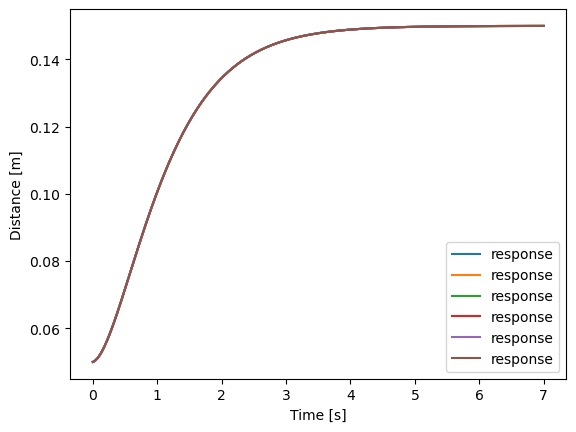

In [16]:
evaluate_policy(model,env,n_eval_episodes=2,render=True)

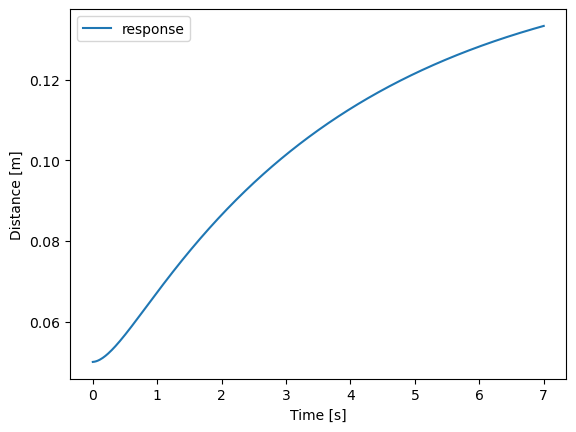

In [31]:
env.render()

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.13.0 at http://localhost:6006/ (Press CTRL+C to quit)
forrtl: error (200): program aborting due to window-CLOSE event
Image              PC                Routine            Line        Source             
libifcoremd.dll    00007FFF056CDF54  Unknown               Unknown  Unknown
KERNELBASE.dll     00007FFFE1BF2A23  Unknown               Unknown  Unknown
KERNEL32.DLL       00007FFFE20A7344  Unknown               Unknown  Unknown
ntdll.dll          00007FFFE40826B1  Unknown               Unknown  Unknown


kill: 8532: No such process
